In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 1576)
(657450, 8)
validation
(74368, 1576)
(74368, 8)
test
(91684, 1576)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2304904 (8.79 MB)


Trainable params: 2304904 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:50 - loss: 2.0117 - STD: 0.0503 - MAE: 0.2153

 3/66 [>.............................] - ETA: 2s - loss: 1.6435 - STD: 0.1001 - MAE: 0.1867  

 5/66 [=>............................] - ETA: 2s - loss: 1.5292 - STD: 0.1513 - MAE: 0.1648

 7/66 [==>...........................] - ETA: 2s - loss: 1.4885 - STD: 0.1786 - MAE: 0.1535

 9/66 [===>..........................] - ETA: 2s - loss: 1.4588 - STD: 0.1903 - MAE: 0.1484

11/66 [====>.........................] - ETA: 1s - loss: 1.4348 - STD: 0.1927 - MAE: 0.1470

12/66 [====>.........................] - ETA: 6s - loss: 1.4276 - STD: 0.1920 - MAE: 0.1470

14/66 [=====>........................] - ETA: 5s - loss: 1.4135 - STD: 0.1896 - MAE: 0.1478

16/66 [======>.......................] - ETA: 5s - loss: 1.4021 - STD: 0.1875 - MAE: 0.1483

18/66 [=======>......................] - ETA: 4s - loss: 1.3922 - STD: 0.1868 - MAE: 0.1484

20/66 [========>.....................] - ETA: 4s - loss: 1.3841 - STD: 0.1875 - MAE: 0.1479

22/66 [=========>....................] - ETA: 3s - loss: 1.3770 - STD: 0.1890 - MAE: 0.1472

24/66 [=========>....................] - ETA: 3s - loss: 1.3722 - STD: 0.1907 - MAE: 0.1465

26/66 [==========>...................] - ETA: 3s - loss: 1.3685 - STD: 0.1920 - MAE: 0.1459

28/66 [===========>..................] - ETA: 2s - loss: 1.3642 - STD: 0.1926 - MAE: 0.1456

30/66 [============>.................] - ETA: 2s - loss: 1.3613 - STD: 0.1924 - MAE: 0.1457

32/66 [=============>................] - ETA: 2s - loss: 1.3591 - STD: 0.1919 - MAE: 0.1459

34/66 [==============>...............] - ETA: 2s - loss: 1.3565 - STD: 0.1913 - MAE: 0.1461

36/66 [===============>..............] - ETA: 1s - loss: 1.3538 - STD: 0.1908 - MAE: 0.1462

38/66 [================>.............] - ETA: 1s - loss: 1.3515 - STD: 0.1907 - MAE: 0.1462

40/66 [=================>............] - ETA: 1s - loss: 1.3495 - STD: 0.1909 - MAE: 0.1461

42/66 [==================>...........] - ETA: 1s - loss: 1.3482 - STD: 0.1912 - MAE: 0.1460

44/66 [===================>..........] - ETA: 1s - loss: 1.3465 - STD: 0.1915 - MAE: 0.1459

46/66 [===================>..........] - ETA: 1s - loss: 1.3453 - STD: 0.1917 - MAE: 0.1458

48/66 [====================>.........] - ETA: 1s - loss: 1.3440 - STD: 0.1916 - MAE: 0.1458

50/66 [=====================>........] - ETA: 0s - loss: 1.3428 - STD: 0.1915 - MAE: 0.1458

52/66 [======================>.......] - ETA: 0s - loss: 1.3407 - STD: 0.1913 - MAE: 0.1459

54/66 [=======================>......] - ETA: 0s - loss: 1.3392 - STD: 0.1912 - MAE: 0.1458

56/66 [========================>.....] - ETA: 0s - loss: 1.3383 - STD: 0.1912 - MAE: 0.1458

58/66 [=========================>....] - ETA: 0s - loss: 1.3372 - STD: 0.1914 - MAE: 0.1457

60/66 [==========================>...] - ETA: 0s - loss: 1.3359 - STD: 0.1915 - MAE: 0.1456

62/66 [===========================>..] - ETA: 0s - loss: 1.3348 - STD: 0.1916 - MAE: 0.1456

64/66 [============================>.] - ETA: 0s - loss: 1.3338 - STD: 0.1917 - MAE: 0.1455

66/66 [==============================] - ETA: 0s - loss: 1.3330 - STD: 0.1917 - MAE: 0.1455

66/66 [==============================] - 6s 66ms/step - loss: 1.3330 - STD: 0.1917 - MAE: 0.1455 - val_loss: 1.2451 - val_STD: 0.1907 - val_MAE: 0.1424


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3256 - STD: 0.1906 - MAE: 0.1464

 3/66 [>.............................] - ETA: 2s - loss: 1.3074 - STD: 0.1903 - MAE: 0.1456

 5/66 [=>............................] - ETA: 2s - loss: 1.3081 - STD: 0.1905 - MAE: 0.1455

 7/66 [==>...........................] - ETA: 2s - loss: 1.3066 - STD: 0.1912 - MAE: 0.1452

 9/66 [===>..........................] - ETA: 2s - loss: 1.3030 - STD: 0.1920 - MAE: 0.1447

11/66 [====>.........................] - ETA: 1s - loss: 1.3065 - STD: 0.1926 - MAE: 0.1447

13/66 [====>.........................] - ETA: 1s - loss: 1.3057 - STD: 0.1928 - MAE: 0.1446

15/66 [=====>........................] - ETA: 1s - loss: 1.3052 - STD: 0.1926 - MAE: 0.1446

17/66 [======>.......................] - ETA: 1s - loss: 1.3054 - STD: 0.1923 - MAE: 0.1447

19/66 [=======>......................] - ETA: 1s - loss: 1.3078 - STD: 0.1921 - MAE: 0.1450

21/66 [========>.....................] - ETA: 1s - loss: 1.3071 - STD: 0.1919 - MAE: 0.1450

23/66 [=========>....................] - ETA: 1s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1451

25/66 [==========>...................] - ETA: 1s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

27/66 [===========>..................] - ETA: 1s - loss: 1.3074 - STD: 0.1920 - MAE: 0.1449

29/66 [============>.................] - ETA: 1s - loss: 1.3071 - STD: 0.1922 - MAE: 0.1449

31/66 [=============>................] - ETA: 1s - loss: 1.3083 - STD: 0.1923 - MAE: 0.1449

33/66 [==============>...............] - ETA: 1s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

35/66 [==============>...............] - ETA: 1s - loss: 1.3077 - STD: 0.1920 - MAE: 0.1450

37/66 [===============>..............] - ETA: 1s - loss: 1.3075 - STD: 0.1919 - MAE: 0.1450

39/66 [================>.............] - ETA: 0s - loss: 1.3073 - STD: 0.1919 - MAE: 0.1450

41/66 [=================>............] - ETA: 0s - loss: 1.3079 - STD: 0.1920 - MAE: 0.1450

43/66 [==================>...........] - ETA: 0s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450

45/66 [===================>..........] - ETA: 0s - loss: 1.3084 - STD: 0.1921 - MAE: 0.1450

47/66 [====================>.........] - ETA: 0s - loss: 1.3086 - STD: 0.1921 - MAE: 0.1450

49/66 [=====================>........] - ETA: 0s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1451

51/66 [======================>.......] - ETA: 0s - loss: 1.3089 - STD: 0.1919 - MAE: 0.1451

53/66 [=======================>......] - ETA: 0s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

55/66 [========================>.....] - ETA: 0s - loss: 1.3087 - STD: 0.1919 - MAE: 0.1451

57/66 [========================>.....] - ETA: 0s - loss: 1.3083 - STD: 0.1920 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1451

61/66 [==========================>...] - ETA: 0s - loss: 1.3084 - STD: 0.1920 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1451

65/66 [============================>.] - ETA: 0s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1450

66/66 [==============================] - 3s 40ms/step - loss: 1.3083 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2434 - val_STD: 0.1946 - val_MAE: 0.1408


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3064 - STD: 0.1945 - MAE: 0.1441

 3/66 [>.............................] - ETA: 2s - loss: 1.3052 - STD: 0.1940 - MAE: 0.1441

 5/66 [=>............................] - ETA: 2s - loss: 1.3088 - STD: 0.1931 - MAE: 0.1447

 7/66 [==>...........................] - ETA: 2s - loss: 1.3056 - STD: 0.1922 - MAE: 0.1449

 9/66 [===>..........................] - ETA: 1s - loss: 1.3043 - STD: 0.1918 - MAE: 0.1449

11/66 [====>.........................] - ETA: 1s - loss: 1.3026 - STD: 0.1921 - MAE: 0.1447

13/66 [====>.........................] - ETA: 1s - loss: 1.3052 - STD: 0.1926 - MAE: 0.1446

15/66 [=====>........................] - ETA: 1s - loss: 1.3072 - STD: 0.1928 - MAE: 0.1447

17/66 [======>.......................] - ETA: 1s - loss: 1.3083 - STD: 0.1925 - MAE: 0.1448

19/66 [=======>......................] - ETA: 1s - loss: 1.3083 - STD: 0.1920 - MAE: 0.1450

21/66 [========>.....................] - ETA: 1s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

23/66 [=========>....................] - ETA: 1s - loss: 1.3082 - STD: 0.1918 - MAE: 0.1451

25/66 [==========>...................] - ETA: 1s - loss: 1.3081 - STD: 0.1921 - MAE: 0.1449

27/66 [===========>..................] - ETA: 1s - loss: 1.3078 - STD: 0.1923 - MAE: 0.1448

29/66 [============>.................] - ETA: 1s - loss: 1.3083 - STD: 0.1923 - MAE: 0.1449

31/66 [=============>................] - ETA: 1s - loss: 1.3077 - STD: 0.1921 - MAE: 0.1449

33/66 [==============>...............] - ETA: 1s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3057 - STD: 0.1920 - MAE: 0.1449

37/66 [===============>..............] - ETA: 1s - loss: 1.3059 - STD: 0.1923 - MAE: 0.1447

39/66 [================>.............] - ETA: 0s - loss: 1.3061 - STD: 0.1925 - MAE: 0.1447

41/66 [=================>............] - ETA: 0s - loss: 1.3056 - STD: 0.1925 - MAE: 0.1446

43/66 [==================>...........] - ETA: 0s - loss: 1.3056 - STD: 0.1924 - MAE: 0.1447

45/66 [===================>..........] - ETA: 0s - loss: 1.3061 - STD: 0.1923 - MAE: 0.1447

47/66 [====================>.........] - ETA: 0s - loss: 1.3065 - STD: 0.1923 - MAE: 0.1448

49/66 [=====================>........] - ETA: 0s - loss: 1.3062 - STD: 0.1923 - MAE: 0.1448

51/66 [======================>.......] - ETA: 0s - loss: 1.3065 - STD: 0.1923 - MAE: 0.1448

53/66 [=======================>......] - ETA: 0s - loss: 1.3064 - STD: 0.1922 - MAE: 0.1448

55/66 [========================>.....] - ETA: 0s - loss: 1.3061 - STD: 0.1922 - MAE: 0.1448

57/66 [========================>.....] - ETA: 0s - loss: 1.3067 - STD: 0.1922 - MAE: 0.1448

59/66 [=========================>....] - ETA: 0s - loss: 1.3072 - STD: 0.1921 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3075 - STD: 0.1920 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3069 - STD: 0.1920 - MAE: 0.1449

66/66 [==============================] - 3s 40ms/step - loss: 1.3068 - STD: 0.1920 - MAE: 0.1449 - val_loss: 1.2391 - val_STD: 0.1922 - val_MAE: 0.1414


Epoch 4/10000


 1/66 [..............................] - ETA: 4s - loss: 1.2867 - STD: 0.1896 - MAE: 0.1452

 3/66 [>.............................] - ETA: 2s - loss: 1.3004 - STD: 0.1893 - MAE: 0.1458

 5/66 [=>............................] - ETA: 2s - loss: 1.2950 - STD: 0.1911 - MAE: 0.1447

 7/66 [==>...........................] - ETA: 2s - loss: 1.2965 - STD: 0.1919 - MAE: 0.1444

 9/66 [===>..........................] - ETA: 2s - loss: 1.2973 - STD: 0.1912 - MAE: 0.1447

11/66 [====>.........................] - ETA: 1s - loss: 1.2970 - STD: 0.1915 - MAE: 0.1446

13/66 [====>.........................] - ETA: 1s - loss: 1.2974 - STD: 0.1917 - MAE: 0.1445

15/66 [=====>........................] - ETA: 1s - loss: 1.2973 - STD: 0.1914 - MAE: 0.1445

17/66 [======>.......................] - ETA: 1s - loss: 1.2964 - STD: 0.1916 - MAE: 0.1444

19/66 [=======>......................] - ETA: 1s - loss: 1.2955 - STD: 0.1916 - MAE: 0.1443

21/66 [========>.....................] - ETA: 1s - loss: 1.2949 - STD: 0.1917 - MAE: 0.1443

23/66 [=========>....................] - ETA: 1s - loss: 1.2938 - STD: 0.1916 - MAE: 0.1442

25/66 [==========>...................] - ETA: 1s - loss: 1.2930 - STD: 0.1917 - MAE: 0.1441

27/66 [===========>..................] - ETA: 1s - loss: 1.2924 - STD: 0.1915 - MAE: 0.1442

29/66 [============>.................] - ETA: 1s - loss: 1.2911 - STD: 0.1920 - MAE: 0.1439

31/66 [=============>................] - ETA: 1s - loss: 1.2896 - STD: 0.1918 - MAE: 0.1439

33/66 [==============>...............] - ETA: 1s - loss: 1.2882 - STD: 0.1923 - MAE: 0.1436

35/66 [==============>...............] - ETA: 1s - loss: 1.2870 - STD: 0.1922 - MAE: 0.1436

37/66 [===============>..............] - ETA: 1s - loss: 1.2863 - STD: 0.1927 - MAE: 0.1434

39/66 [================>.............] - ETA: 0s - loss: 1.2851 - STD: 0.1926 - MAE: 0.1433

41/66 [=================>............] - ETA: 0s - loss: 1.2839 - STD: 0.1929 - MAE: 0.1432

43/66 [==================>...........] - ETA: 0s - loss: 1.2835 - STD: 0.1930 - MAE: 0.1431

45/66 [===================>..........] - ETA: 0s - loss: 1.2834 - STD: 0.1931 - MAE: 0.1430

47/66 [====================>.........] - ETA: 0s - loss: 1.2827 - STD: 0.1933 - MAE: 0.1429

49/66 [=====================>........] - ETA: 0s - loss: 1.2822 - STD: 0.1935 - MAE: 0.1428

51/66 [======================>.......] - ETA: 0s - loss: 1.2817 - STD: 0.1935 - MAE: 0.1428

53/66 [=======================>......] - ETA: 0s - loss: 1.2806 - STD: 0.1937 - MAE: 0.1427

55/66 [========================>.....] - ETA: 0s - loss: 1.2803 - STD: 0.1938 - MAE: 0.1426

57/66 [========================>.....] - ETA: 0s - loss: 1.2797 - STD: 0.1940 - MAE: 0.1425

59/66 [=========================>....] - ETA: 0s - loss: 1.2785 - STD: 0.1941 - MAE: 0.1424

61/66 [==========================>...] - ETA: 0s - loss: 1.2776 - STD: 0.1943 - MAE: 0.1423

63/66 [===========================>..] - ETA: 0s - loss: 1.2769 - STD: 0.1945 - MAE: 0.1422

65/66 [============================>.] - ETA: 0s - loss: 1.2759 - STD: 0.1945 - MAE: 0.1421

66/66 [==============================] - 3s 40ms/step - loss: 1.2757 - STD: 0.1947 - MAE: 0.1420 - val_loss: 1.1869 - val_STD: 0.1982 - val_MAE: 0.1359


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2653 - STD: 0.1890 - MAE: 0.1440

 3/66 [>.............................] - ETA: 2s - loss: 1.2541 - STD: 0.1974 - MAE: 0.1398

 5/66 [=>............................] - ETA: 2s - loss: 1.2571 - STD: 0.1961 - MAE: 0.1405

 7/66 [==>...........................] - ETA: 2s - loss: 1.2537 - STD: 0.1992 - MAE: 0.1390

 9/66 [===>..........................] - ETA: 1s - loss: 1.2553 - STD: 0.1972 - MAE: 0.1399

11/66 [====>.........................] - ETA: 1s - loss: 1.2545 - STD: 0.1983 - MAE: 0.1394

13/66 [====>.........................] - ETA: 1s - loss: 1.2546 - STD: 0.1986 - MAE: 0.1392

15/66 [=====>........................] - ETA: 1s - loss: 1.2552 - STD: 0.1981 - MAE: 0.1395

17/66 [======>.......................] - ETA: 1s - loss: 1.2538 - STD: 0.1994 - MAE: 0.1389

19/66 [=======>......................] - ETA: 1s - loss: 1.2553 - STD: 0.1979 - MAE: 0.1396

21/66 [========>.....................] - ETA: 1s - loss: 1.2543 - STD: 0.1990 - MAE: 0.1390

23/66 [=========>....................] - ETA: 1s - loss: 1.2536 - STD: 0.1984 - MAE: 0.1393

25/66 [==========>...................] - ETA: 1s - loss: 1.2531 - STD: 0.1992 - MAE: 0.1389

27/66 [===========>..................] - ETA: 1s - loss: 1.2535 - STD: 0.1986 - MAE: 0.1392

29/66 [============>.................] - ETA: 1s - loss: 1.2535 - STD: 0.1988 - MAE: 0.1391

31/66 [=============>................] - ETA: 1s - loss: 1.2527 - STD: 0.1992 - MAE: 0.1389

33/66 [==============>...............] - ETA: 1s - loss: 1.2534 - STD: 0.1988 - MAE: 0.1391

35/66 [==============>...............] - ETA: 1s - loss: 1.2535 - STD: 0.1992 - MAE: 0.1389

37/66 [===============>..............] - ETA: 1s - loss: 1.2529 - STD: 0.1988 - MAE: 0.1391

39/66 [================>.............] - ETA: 0s - loss: 1.2527 - STD: 0.1993 - MAE: 0.1389

41/66 [=================>............] - ETA: 0s - loss: 1.2523 - STD: 0.1988 - MAE: 0.1390

43/66 [==================>...........] - ETA: 0s - loss: 1.2524 - STD: 0.1993 - MAE: 0.1388

45/66 [===================>..........] - ETA: 0s - loss: 1.2524 - STD: 0.1988 - MAE: 0.1391

47/66 [====================>.........] - ETA: 0s - loss: 1.2529 - STD: 0.1992 - MAE: 0.1389

49/66 [=====================>........] - ETA: 0s - loss: 1.2528 - STD: 0.1988 - MAE: 0.1391

51/66 [======================>.......] - ETA: 0s - loss: 1.2529 - STD: 0.1993 - MAE: 0.1389

53/66 [=======================>......] - ETA: 0s - loss: 1.2528 - STD: 0.1990 - MAE: 0.1390

55/66 [========================>.....] - ETA: 0s - loss: 1.2529 - STD: 0.1992 - MAE: 0.1389

57/66 [========================>.....] - ETA: 0s - loss: 1.2527 - STD: 0.1991 - MAE: 0.1390

59/66 [=========================>....] - ETA: 0s - loss: 1.2524 - STD: 0.1993 - MAE: 0.1389

61/66 [==========================>...] - ETA: 0s - loss: 1.2519 - STD: 0.1991 - MAE: 0.1389

63/66 [===========================>..] - ETA: 0s - loss: 1.2515 - STD: 0.1993 - MAE: 0.1389

65/66 [============================>.] - ETA: 0s - loss: 1.2511 - STD: 0.1992 - MAE: 0.1389

66/66 [==============================] - 3s 40ms/step - loss: 1.2508 - STD: 0.1993 - MAE: 0.1388 - val_loss: 1.1743 - val_STD: 0.2133 - val_MAE: 0.1291


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2329 - STD: 0.2050 - MAE: 0.1356

 3/66 [>.............................] - ETA: 2s - loss: 1.2424 - STD: 0.1993 - MAE: 0.1384

 5/66 [=>............................] - ETA: 2s - loss: 1.2436 - STD: 0.2012 - MAE: 0.1378

 7/66 [==>...........................] - ETA: 2s - loss: 1.2406 - STD: 0.2009 - MAE: 0.1378

 9/66 [===>..........................] - ETA: 2s - loss: 1.2355 - STD: 0.2008 - MAE: 0.1376

11/66 [====>.........................] - ETA: 1s - loss: 1.2334 - STD: 0.2013 - MAE: 0.1372

13/66 [====>.........................] - ETA: 1s - loss: 1.2327 - STD: 0.2022 - MAE: 0.1369

15/66 [=====>........................] - ETA: 1s - loss: 1.2340 - STD: 0.2012 - MAE: 0.1374

17/66 [======>.......................] - ETA: 1s - loss: 1.2337 - STD: 0.2009 - MAE: 0.1375

19/66 [=======>......................] - ETA: 1s - loss: 1.2354 - STD: 0.2014 - MAE: 0.1374

21/66 [========>.....................] - ETA: 1s - loss: 1.2347 - STD: 0.2011 - MAE: 0.1375

23/66 [=========>....................] - ETA: 1s - loss: 1.2349 - STD: 0.2005 - MAE: 0.1378

25/66 [==========>...................] - ETA: 1s - loss: 1.2360 - STD: 0.2012 - MAE: 0.1376

27/66 [===========>..................] - ETA: 1s - loss: 1.2363 - STD: 0.2003 - MAE: 0.1380

29/66 [============>.................] - ETA: 1s - loss: 1.2358 - STD: 0.2005 - MAE: 0.1379

31/66 [=============>................] - ETA: 1s - loss: 1.2346 - STD: 0.2004 - MAE: 0.1379

33/66 [==============>...............] - ETA: 1s - loss: 1.2348 - STD: 0.2004 - MAE: 0.1379

35/66 [==============>...............] - ETA: 1s - loss: 1.2339 - STD: 0.2006 - MAE: 0.1378

37/66 [===============>..............] - ETA: 1s - loss: 1.2331 - STD: 0.2004 - MAE: 0.1379

39/66 [================>.............] - ETA: 0s - loss: 1.2327 - STD: 0.2008 - MAE: 0.1377

41/66 [=================>............] - ETA: 0s - loss: 1.2324 - STD: 0.2004 - MAE: 0.1379

43/66 [==================>...........] - ETA: 0s - loss: 1.2317 - STD: 0.2005 - MAE: 0.1378

45/66 [===================>..........] - ETA: 0s - loss: 1.2307 - STD: 0.2005 - MAE: 0.1378

47/66 [====================>.........] - ETA: 0s - loss: 1.2299 - STD: 0.2006 - MAE: 0.1377

49/66 [=====================>........] - ETA: 0s - loss: 1.2287 - STD: 0.2006 - MAE: 0.1377

51/66 [======================>.......] - ETA: 0s - loss: 1.2280 - STD: 0.2005 - MAE: 0.1377

53/66 [=======================>......] - ETA: 0s - loss: 1.2269 - STD: 0.2005 - MAE: 0.1377

55/66 [========================>.....] - ETA: 0s - loss: 1.2255 - STD: 0.2008 - MAE: 0.1375

57/66 [========================>.....] - ETA: 0s - loss: 1.2244 - STD: 0.2007 - MAE: 0.1375

59/66 [=========================>....] - ETA: 0s - loss: 1.2240 - STD: 0.2010 - MAE: 0.1374

61/66 [==========================>...] - ETA: 0s - loss: 1.2231 - STD: 0.2005 - MAE: 0.1376

63/66 [===========================>..] - ETA: 0s - loss: 1.2229 - STD: 0.2007 - MAE: 0.1375

65/66 [============================>.] - ETA: 0s - loss: 1.2221 - STD: 0.2008 - MAE: 0.1374

66/66 [==============================] - 3s 40ms/step - loss: 1.2217 - STD: 0.2008 - MAE: 0.1374 - val_loss: 1.1300 - val_STD: 0.2254 - val_MAE: 0.1230


Epoch 7/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1782 - STD: 0.2159 - MAE: 0.1301

 3/66 [>.............................] - ETA: 2s - loss: 1.1875 - STD: 0.2022 - MAE: 0.1360

 5/66 [=>............................] - ETA: 2s - loss: 1.1824 - STD: 0.2062 - MAE: 0.1342

 7/66 [==>...........................] - ETA: 2s - loss: 1.1830 - STD: 0.2033 - MAE: 0.1354

 9/66 [===>..........................] - ETA: 2s - loss: 1.1842 - STD: 0.2034 - MAE: 0.1354

11/66 [====>.........................] - ETA: 1s - loss: 1.1851 - STD: 0.2042 - MAE: 0.1351

13/66 [====>.........................] - ETA: 1s - loss: 1.1837 - STD: 0.2028 - MAE: 0.1356

15/66 [=====>........................] - ETA: 1s - loss: 1.1847 - STD: 0.2036 - MAE: 0.1354

17/66 [======>.......................] - ETA: 1s - loss: 1.1843 - STD: 0.2032 - MAE: 0.1355

19/66 [=======>......................] - ETA: 1s - loss: 1.1830 - STD: 0.2038 - MAE: 0.1352

21/66 [========>.....................] - ETA: 1s - loss: 1.1816 - STD: 0.2035 - MAE: 0.1353

23/66 [=========>....................] - ETA: 1s - loss: 1.1818 - STD: 0.2037 - MAE: 0.1353

25/66 [==========>...................] - ETA: 1s - loss: 1.1820 - STD: 0.2037 - MAE: 0.1353

27/66 [===========>..................] - ETA: 1s - loss: 1.1820 - STD: 0.2033 - MAE: 0.1354

29/66 [============>.................] - ETA: 1s - loss: 1.1817 - STD: 0.2036 - MAE: 0.1353

31/66 [=============>................] - ETA: 1s - loss: 1.1807 - STD: 0.2038 - MAE: 0.1352

33/66 [==============>...............] - ETA: 1s - loss: 1.1807 - STD: 0.2038 - MAE: 0.1352

35/66 [==============>...............] - ETA: 1s - loss: 1.1801 - STD: 0.2034 - MAE: 0.1353

37/66 [===============>..............] - ETA: 1s - loss: 1.1799 - STD: 0.2039 - MAE: 0.1351

39/66 [================>.............] - ETA: 0s - loss: 1.1788 - STD: 0.2038 - MAE: 0.1351

41/66 [=================>............] - ETA: 0s - loss: 1.1791 - STD: 0.2039 - MAE: 0.1351

43/66 [==================>...........] - ETA: 0s - loss: 1.1787 - STD: 0.2040 - MAE: 0.1350

45/66 [===================>..........] - ETA: 0s - loss: 1.1783 - STD: 0.2040 - MAE: 0.1350

47/66 [====================>.........] - ETA: 0s - loss: 1.1782 - STD: 0.2040 - MAE: 0.1350

49/66 [=====================>........] - ETA: 0s - loss: 1.1779 - STD: 0.2041 - MAE: 0.1350

51/66 [======================>.......] - ETA: 0s - loss: 1.1786 - STD: 0.2041 - MAE: 0.1350

53/66 [=======================>......] - ETA: 0s - loss: 1.1788 - STD: 0.2039 - MAE: 0.1351

55/66 [========================>.....] - ETA: 0s - loss: 1.1788 - STD: 0.2041 - MAE: 0.1351

57/66 [========================>.....] - ETA: 0s - loss: 1.1785 - STD: 0.2039 - MAE: 0.1351

59/66 [=========================>....] - ETA: 0s - loss: 1.1781 - STD: 0.2040 - MAE: 0.1351

61/66 [==========================>...] - ETA: 0s - loss: 1.1775 - STD: 0.2040 - MAE: 0.1350

63/66 [===========================>..] - ETA: 0s - loss: 1.1769 - STD: 0.2042 - MAE: 0.1350

65/66 [============================>.] - ETA: 0s - loss: 1.1768 - STD: 0.2040 - MAE: 0.1350

66/66 [==============================] - 3s 40ms/step - loss: 1.1764 - STD: 0.2042 - MAE: 0.1349 - val_loss: 1.0962 - val_STD: 0.2169 - val_MAE: 0.1254


Epoch 8/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1572 - STD: 0.2084 - MAE: 0.1326

 3/66 [>.............................] - ETA: 2s - loss: 1.1549 - STD: 0.2051 - MAE: 0.1339

 5/66 [=>............................] - ETA: 2s - loss: 1.1562 - STD: 0.2050 - MAE: 0.1340

 7/66 [==>...........................] - ETA: 2s - loss: 1.1592 - STD: 0.2050 - MAE: 0.1342

 9/66 [===>..........................] - ETA: 2s - loss: 1.1601 - STD: 0.2050 - MAE: 0.1343

11/66 [====>.........................] - ETA: 1s - loss: 1.1596 - STD: 0.2048 - MAE: 0.1343

13/66 [====>.........................] - ETA: 1s - loss: 1.1597 - STD: 0.2052 - MAE: 0.1341

15/66 [=====>........................] - ETA: 1s - loss: 1.1601 - STD: 0.2049 - MAE: 0.1343

17/66 [======>.......................] - ETA: 1s - loss: 1.1598 - STD: 0.2048 - MAE: 0.1343

19/66 [=======>......................] - ETA: 1s - loss: 1.1580 - STD: 0.2051 - MAE: 0.1342

21/66 [========>.....................] - ETA: 1s - loss: 1.1560 - STD: 0.2053 - MAE: 0.1340

23/66 [=========>....................] - ETA: 1s - loss: 1.1554 - STD: 0.2055 - MAE: 0.1339

25/66 [==========>...................] - ETA: 1s - loss: 1.1552 - STD: 0.2052 - MAE: 0.1340

27/66 [===========>..................] - ETA: 1s - loss: 1.1549 - STD: 0.2056 - MAE: 0.1338

29/66 [============>.................] - ETA: 1s - loss: 1.1550 - STD: 0.2054 - MAE: 0.1339

31/66 [=============>................] - ETA: 1s - loss: 1.1548 - STD: 0.2055 - MAE: 0.1339

33/66 [==============>...............] - ETA: 1s - loss: 1.1549 - STD: 0.2056 - MAE: 0.1338

35/66 [==============>...............] - ETA: 1s - loss: 1.1550 - STD: 0.2054 - MAE: 0.1339

37/66 [===============>..............] - ETA: 1s - loss: 1.1542 - STD: 0.2059 - MAE: 0.1337

39/66 [================>.............] - ETA: 0s - loss: 1.1541 - STD: 0.2055 - MAE: 0.1338

41/66 [=================>............] - ETA: 0s - loss: 1.1536 - STD: 0.2057 - MAE: 0.1337

43/66 [==================>...........] - ETA: 0s - loss: 1.1542 - STD: 0.2057 - MAE: 0.1337

45/66 [===================>..........] - ETA: 0s - loss: 1.1541 - STD: 0.2056 - MAE: 0.1338

47/66 [====================>.........] - ETA: 0s - loss: 1.1546 - STD: 0.2061 - MAE: 0.1336

49/66 [=====================>........] - ETA: 0s - loss: 1.1550 - STD: 0.2054 - MAE: 0.1339

51/66 [======================>.......] - ETA: 0s - loss: 1.1550 - STD: 0.2058 - MAE: 0.1337

53/66 [=======================>......] - ETA: 0s - loss: 1.1554 - STD: 0.2059 - MAE: 0.1337

55/66 [========================>.....] - ETA: 0s - loss: 1.1567 - STD: 0.2054 - MAE: 0.1340

57/66 [========================>.....] - ETA: 0s - loss: 1.1573 - STD: 0.2059 - MAE: 0.1338

59/66 [=========================>....] - ETA: 0s - loss: 1.1579 - STD: 0.2055 - MAE: 0.1340

61/66 [==========================>...] - ETA: 0s - loss: 1.1582 - STD: 0.2056 - MAE: 0.1339

63/66 [===========================>..] - ETA: 0s - loss: 1.1584 - STD: 0.2057 - MAE: 0.1339

65/66 [============================>.] - ETA: 0s - loss: 1.1587 - STD: 0.2056 - MAE: 0.1339

66/66 [==============================] - 3s 40ms/step - loss: 1.1589 - STD: 0.2054 - MAE: 0.1340 - val_loss: 1.0982 - val_STD: 0.2231 - val_MAE: 0.1231


Epoch 9/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1581 - STD: 0.2150 - MAE: 0.1301

 3/66 [>.............................] - ETA: 2s - loss: 1.1480 - STD: 0.2107 - MAE: 0.1314

 5/66 [=>............................] - ETA: 2s - loss: 1.1507 - STD: 0.2086 - MAE: 0.1324

 7/66 [==>...........................] - ETA: 2s - loss: 1.1511 - STD: 0.2071 - MAE: 0.1331

 9/66 [===>..........................] - ETA: 2s - loss: 1.1509 - STD: 0.2077 - MAE: 0.1329

11/66 [====>.........................] - ETA: 1s - loss: 1.1502 - STD: 0.2064 - MAE: 0.1333

13/66 [====>.........................] - ETA: 1s - loss: 1.1504 - STD: 0.2073 - MAE: 0.1330

15/66 [=====>........................] - ETA: 1s - loss: 1.1495 - STD: 0.2064 - MAE: 0.1333

17/66 [======>.......................] - ETA: 1s - loss: 1.1480 - STD: 0.2066 - MAE: 0.1332

19/66 [=======>......................] - ETA: 1s - loss: 1.1465 - STD: 0.2066 - MAE: 0.1331

21/66 [========>.....................] - ETA: 1s - loss: 1.1459 - STD: 0.2066 - MAE: 0.1331

23/66 [=========>....................] - ETA: 1s - loss: 1.1470 - STD: 0.2064 - MAE: 0.1332

25/66 [==========>...................] - ETA: 1s - loss: 1.1467 - STD: 0.2064 - MAE: 0.1333

27/66 [===========>..................] - ETA: 1s - loss: 1.1469 - STD: 0.2062 - MAE: 0.1334

29/66 [============>.................] - ETA: 1s - loss: 1.1461 - STD: 0.2064 - MAE: 0.1332

31/66 [=============>................] - ETA: 1s - loss: 1.1454 - STD: 0.2064 - MAE: 0.1332

33/66 [==============>...............] - ETA: 1s - loss: 1.1454 - STD: 0.2064 - MAE: 0.1332

35/66 [==============>...............] - ETA: 1s - loss: 1.1451 - STD: 0.2065 - MAE: 0.1332

37/66 [===============>..............] - ETA: 1s - loss: 1.1452 - STD: 0.2063 - MAE: 0.1332

39/66 [================>.............] - ETA: 0s - loss: 1.1453 - STD: 0.2063 - MAE: 0.1333

41/66 [=================>............] - ETA: 0s - loss: 1.1445 - STD: 0.2064 - MAE: 0.1332

43/66 [==================>...........] - ETA: 0s - loss: 1.1443 - STD: 0.2064 - MAE: 0.1332

45/66 [===================>..........] - ETA: 0s - loss: 1.1445 - STD: 0.2063 - MAE: 0.1332

47/66 [====================>.........] - ETA: 0s - loss: 1.1446 - STD: 0.2064 - MAE: 0.1332

49/66 [=====================>........] - ETA: 0s - loss: 1.1443 - STD: 0.2065 - MAE: 0.1332

51/66 [======================>.......] - ETA: 0s - loss: 1.1440 - STD: 0.2063 - MAE: 0.1332

53/66 [=======================>......] - ETA: 0s - loss: 1.1437 - STD: 0.2063 - MAE: 0.1332

55/66 [========================>.....] - ETA: 0s - loss: 1.1438 - STD: 0.2064 - MAE: 0.1332

57/66 [========================>.....] - ETA: 0s - loss: 1.1437 - STD: 0.2062 - MAE: 0.1333

59/66 [=========================>....] - ETA: 0s - loss: 1.1432 - STD: 0.2064 - MAE: 0.1332

61/66 [==========================>...] - ETA: 0s - loss: 1.1430 - STD: 0.2064 - MAE: 0.1332

63/66 [===========================>..] - ETA: 0s - loss: 1.1432 - STD: 0.2064 - MAE: 0.1332

65/66 [============================>.] - ETA: 0s - loss: 1.1432 - STD: 0.2063 - MAE: 0.1332

66/66 [==============================] - 3s 40ms/step - loss: 1.1429 - STD: 0.2064 - MAE: 0.1332 - val_loss: 1.0719 - val_STD: 0.2164 - val_MAE: 0.1250


Epoch 10/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1307 - STD: 0.2086 - MAE: 0.1317

 3/66 [>.............................] - ETA: 2s - loss: 1.1346 - STD: 0.2072 - MAE: 0.1326

 5/66 [=>............................] - ETA: 2s - loss: 1.1352 - STD: 0.2070 - MAE: 0.1327

 7/66 [==>...........................] - ETA: 2s - loss: 1.1360 - STD: 0.2068 - MAE: 0.1327

 9/66 [===>..........................] - ETA: 2s - loss: 1.1320 - STD: 0.2075 - MAE: 0.1323

11/66 [====>.........................] - ETA: 1s - loss: 1.1342 - STD: 0.2076 - MAE: 0.1324

13/66 [====>.........................] - ETA: 1s - loss: 1.1346 - STD: 0.2069 - MAE: 0.1326

15/66 [=====>........................] - ETA: 1s - loss: 1.1362 - STD: 0.2069 - MAE: 0.1328

17/66 [======>.......................] - ETA: 1s - loss: 1.1371 - STD: 0.2066 - MAE: 0.1329

19/66 [=======>......................] - ETA: 1s - loss: 1.1371 - STD: 0.2071 - MAE: 0.1327

21/66 [========>.....................] - ETA: 1s - loss: 1.1374 - STD: 0.2063 - MAE: 0.1331

23/66 [=========>....................] - ETA: 1s - loss: 1.1378 - STD: 0.2069 - MAE: 0.1329

25/66 [==========>...................] - ETA: 1s - loss: 1.1375 - STD: 0.2065 - MAE: 0.1330

27/66 [===========>..................] - ETA: 1s - loss: 1.1374 - STD: 0.2067 - MAE: 0.1330

29/66 [============>.................] - ETA: 1s - loss: 1.1366 - STD: 0.2065 - MAE: 0.1330

31/66 [=============>................] - ETA: 1s - loss: 1.1346 - STD: 0.2070 - MAE: 0.1327

33/66 [==============>...............] - ETA: 1s - loss: 1.1347 - STD: 0.2069 - MAE: 0.1327

35/66 [==============>...............] - ETA: 1s - loss: 1.1343 - STD: 0.2069 - MAE: 0.1327

37/66 [===============>..............] - ETA: 1s - loss: 1.1337 - STD: 0.2070 - MAE: 0.1326

39/66 [================>.............] - ETA: 0s - loss: 1.1340 - STD: 0.2071 - MAE: 0.1326

41/66 [=================>............] - ETA: 0s - loss: 1.1330 - STD: 0.2070 - MAE: 0.1326

43/66 [==================>...........] - ETA: 0s - loss: 1.1332 - STD: 0.2072 - MAE: 0.1325

45/66 [===================>..........] - ETA: 0s - loss: 1.1343 - STD: 0.2072 - MAE: 0.1325

47/66 [====================>.........] - ETA: 0s - loss: 1.1343 - STD: 0.2071 - MAE: 0.1326

49/66 [=====================>........] - ETA: 0s - loss: 1.1340 - STD: 0.2073 - MAE: 0.1325

51/66 [======================>.......] - ETA: 0s - loss: 1.1336 - STD: 0.2073 - MAE: 0.1325

53/66 [=======================>......] - ETA: 0s - loss: 1.1337 - STD: 0.2073 - MAE: 0.1325

55/66 [========================>.....] - ETA: 0s - loss: 1.1338 - STD: 0.2075 - MAE: 0.1324

57/66 [========================>.....] - ETA: 0s - loss: 1.1337 - STD: 0.2072 - MAE: 0.1325

59/66 [=========================>....] - ETA: 0s - loss: 1.1333 - STD: 0.2075 - MAE: 0.1324

61/66 [==========================>...] - ETA: 0s - loss: 1.1334 - STD: 0.2073 - MAE: 0.1325

63/66 [===========================>..] - ETA: 0s - loss: 1.1338 - STD: 0.2073 - MAE: 0.1325

65/66 [============================>.] - ETA: 0s - loss: 1.1337 - STD: 0.2073 - MAE: 0.1325

66/66 [==============================] - 3s 40ms/step - loss: 1.1337 - STD: 0.2072 - MAE: 0.1325 - val_loss: 1.0727 - val_STD: 0.2163 - val_MAE: 0.1250


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1270 - STD: 0.2102 - MAE: 0.1309

 3/66 [>.............................] - ETA: 2s - loss: 1.1164 - STD: 0.2118 - MAE: 0.1297

 5/66 [=>............................] - ETA: 2s - loss: 1.1243 - STD: 0.2083 - MAE: 0.1315

 7/66 [==>...........................] - ETA: 2s - loss: 1.1264 - STD: 0.2082 - MAE: 0.1317

 9/66 [===>..........................] - ETA: 2s - loss: 1.1246 - STD: 0.2085 - MAE: 0.1315

11/66 [====>.........................] - ETA: 1s - loss: 1.1246 - STD: 0.2086 - MAE: 0.1315

13/66 [====>.........................] - ETA: 1s - loss: 1.1237 - STD: 0.2089 - MAE: 0.1313

15/66 [=====>........................] - ETA: 1s - loss: 1.1244 - STD: 0.2093 - MAE: 0.1311

17/66 [======>.......................] - ETA: 1s - loss: 1.1255 - STD: 0.2084 - MAE: 0.1316

19/66 [=======>......................] - ETA: 1s - loss: 1.1255 - STD: 0.2091 - MAE: 0.1313

21/66 [========>.....................] - ETA: 1s - loss: 1.1261 - STD: 0.2081 - MAE: 0.1318

23/66 [=========>....................] - ETA: 1s - loss: 1.1261 - STD: 0.2086 - MAE: 0.1315

25/66 [==========>...................] - ETA: 1s - loss: 1.1254 - STD: 0.2082 - MAE: 0.1317

27/66 [===========>..................] - ETA: 1s - loss: 1.1252 - STD: 0.2084 - MAE: 0.1316

29/66 [============>.................] - ETA: 1s - loss: 1.1252 - STD: 0.2083 - MAE: 0.1317

31/66 [=============>................] - ETA: 1s - loss: 1.1249 - STD: 0.2084 - MAE: 0.1316

33/66 [==============>...............] - ETA: 1s - loss: 1.1249 - STD: 0.2083 - MAE: 0.1317

35/66 [==============>...............] - ETA: 1s - loss: 1.1250 - STD: 0.2083 - MAE: 0.1317

37/66 [===============>..............] - ETA: 1s - loss: 1.1245 - STD: 0.2082 - MAE: 0.1317

39/66 [================>.............] - ETA: 0s - loss: 1.1237 - STD: 0.2082 - MAE: 0.1317

41/66 [=================>............] - ETA: 0s - loss: 1.1240 - STD: 0.2082 - MAE: 0.1317

43/66 [==================>...........] - ETA: 0s - loss: 1.1235 - STD: 0.2080 - MAE: 0.1318

45/66 [===================>..........] - ETA: 0s - loss: 1.1233 - STD: 0.2082 - MAE: 0.1317

47/66 [====================>.........] - ETA: 0s - loss: 1.1227 - STD: 0.2079 - MAE: 0.1318

49/66 [=====================>........] - ETA: 0s - loss: 1.1229 - STD: 0.2083 - MAE: 0.1316

51/66 [======================>.......] - ETA: 0s - loss: 1.1228 - STD: 0.2079 - MAE: 0.1318

53/66 [=======================>......] - ETA: 0s - loss: 1.1226 - STD: 0.2084 - MAE: 0.1316

55/66 [========================>.....] - ETA: 0s - loss: 1.1226 - STD: 0.2079 - MAE: 0.1318

57/66 [========================>.....] - ETA: 0s - loss: 1.1228 - STD: 0.2081 - MAE: 0.1317

59/66 [=========================>....] - ETA: 0s - loss: 1.1222 - STD: 0.2080 - MAE: 0.1317

61/66 [==========================>...] - ETA: 0s - loss: 1.1223 - STD: 0.2081 - MAE: 0.1317

63/66 [===========================>..] - ETA: 0s - loss: 1.1216 - STD: 0.2082 - MAE: 0.1317

65/66 [============================>.] - ETA: 0s - loss: 1.1210 - STD: 0.2081 - MAE: 0.1317

66/66 [==============================] - 3s 40ms/step - loss: 1.1208 - STD: 0.2083 - MAE: 0.1316 - val_loss: 1.0574 - val_STD: 0.2198 - val_MAE: 0.1230


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1028 - STD: 0.2112 - MAE: 0.1297

 3/66 [>.............................] - ETA: 2s - loss: 1.1050 - STD: 0.2061 - MAE: 0.1319

 5/66 [=>............................] - ETA: 2s - loss: 1.1038 - STD: 0.2101 - MAE: 0.1301

 7/66 [==>...........................] - ETA: 2s - loss: 1.1044 - STD: 0.2082 - MAE: 0.1310

 9/66 [===>..........................] - ETA: 2s - loss: 1.1060 - STD: 0.2087 - MAE: 0.1308

11/66 [====>.........................] - ETA: 1s - loss: 1.1072 - STD: 0.2084 - MAE: 0.1310

13/66 [====>.........................] - ETA: 1s - loss: 1.1082 - STD: 0.2088 - MAE: 0.1309

15/66 [=====>........................] - ETA: 1s - loss: 1.1069 - STD: 0.2086 - MAE: 0.1309

17/66 [======>.......................] - ETA: 1s - loss: 1.1057 - STD: 0.2090 - MAE: 0.1307

19/66 [=======>......................] - ETA: 1s - loss: 1.1055 - STD: 0.2092 - MAE: 0.1306

21/66 [========>.....................] - ETA: 1s - loss: 1.1073 - STD: 0.2091 - MAE: 0.1307

23/66 [=========>....................] - ETA: 1s - loss: 1.1077 - STD: 0.2093 - MAE: 0.1306

25/66 [==========>...................] - ETA: 1s - loss: 1.1080 - STD: 0.2091 - MAE: 0.1307

27/66 [===========>..................] - ETA: 1s - loss: 1.1082 - STD: 0.2092 - MAE: 0.1307

29/66 [============>.................] - ETA: 1s - loss: 1.1083 - STD: 0.2092 - MAE: 0.1307

31/66 [=============>................] - ETA: 1s - loss: 1.1096 - STD: 0.2092 - MAE: 0.1308

33/66 [==============>...............] - ETA: 1s - loss: 1.1093 - STD: 0.2093 - MAE: 0.1307

35/66 [==============>...............] - ETA: 1s - loss: 1.1105 - STD: 0.2091 - MAE: 0.1308

37/66 [===============>..............] - ETA: 1s - loss: 1.1108 - STD: 0.2094 - MAE: 0.1307

39/66 [================>.............] - ETA: 0s - loss: 1.1108 - STD: 0.2093 - MAE: 0.1308

41/66 [=================>............] - ETA: 0s - loss: 1.1110 - STD: 0.2093 - MAE: 0.1308

43/66 [==================>...........] - ETA: 0s - loss: 1.1111 - STD: 0.2095 - MAE: 0.1307

45/66 [===================>..........] - ETA: 0s - loss: 1.1111 - STD: 0.2093 - MAE: 0.1308

47/66 [====================>.........] - ETA: 0s - loss: 1.1106 - STD: 0.2094 - MAE: 0.1307

49/66 [=====================>........] - ETA: 0s - loss: 1.1101 - STD: 0.2094 - MAE: 0.1307

51/66 [======================>.......] - ETA: 0s - loss: 1.1101 - STD: 0.2095 - MAE: 0.1306

53/66 [=======================>......] - ETA: 0s - loss: 1.1100 - STD: 0.2094 - MAE: 0.1307

55/66 [========================>.....] - ETA: 0s - loss: 1.1100 - STD: 0.2094 - MAE: 0.1306

57/66 [========================>.....] - ETA: 0s - loss: 1.1107 - STD: 0.2092 - MAE: 0.1308

59/66 [=========================>....] - ETA: 0s - loss: 1.1102 - STD: 0.2094 - MAE: 0.1307

61/66 [==========================>...] - ETA: 0s - loss: 1.1097 - STD: 0.2093 - MAE: 0.1307

63/66 [===========================>..] - ETA: 0s - loss: 1.1094 - STD: 0.2095 - MAE: 0.1306

65/66 [============================>.] - ETA: 0s - loss: 1.1092 - STD: 0.2092 - MAE: 0.1307

66/66 [==============================] - 3s 40ms/step - loss: 1.1090 - STD: 0.2094 - MAE: 0.1306 - val_loss: 1.0568 - val_STD: 0.2263 - val_MAE: 0.1203


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0921 - STD: 0.2170 - MAE: 0.1269

 3/66 [>.............................] - ETA: 2s - loss: 1.0951 - STD: 0.2068 - MAE: 0.1312

 5/66 [=>............................] - ETA: 2s - loss: 1.0942 - STD: 0.2115 - MAE: 0.1292

 7/66 [==>...........................] - ETA: 2s - loss: 1.0950 - STD: 0.2090 - MAE: 0.1302

 9/66 [===>..........................] - ETA: 2s - loss: 1.1014 - STD: 0.2097 - MAE: 0.1303

11/66 [====>.........................] - ETA: 1s - loss: 1.1008 - STD: 0.2085 - MAE: 0.1308

13/66 [====>.........................] - ETA: 1s - loss: 1.1007 - STD: 0.2096 - MAE: 0.1303

15/66 [=====>........................] - ETA: 1s - loss: 1.0988 - STD: 0.2088 - MAE: 0.1305

17/66 [======>.......................] - ETA: 1s - loss: 1.1003 - STD: 0.2096 - MAE: 0.1302

19/66 [=======>......................] - ETA: 1s - loss: 1.1008 - STD: 0.2091 - MAE: 0.1305

21/66 [========>.....................] - ETA: 1s - loss: 1.0997 - STD: 0.2098 - MAE: 0.1301

23/66 [=========>....................] - ETA: 1s - loss: 1.0992 - STD: 0.2095 - MAE: 0.1302

25/66 [==========>...................] - ETA: 1s - loss: 1.0984 - STD: 0.2099 - MAE: 0.1300

27/66 [===========>..................] - ETA: 1s - loss: 1.0975 - STD: 0.2098 - MAE: 0.1300

29/66 [============>.................] - ETA: 1s - loss: 1.0974 - STD: 0.2099 - MAE: 0.1299

31/66 [=============>................] - ETA: 1s - loss: 1.0980 - STD: 0.2099 - MAE: 0.1299

33/66 [==============>...............] - ETA: 1s - loss: 1.0971 - STD: 0.2101 - MAE: 0.1298

35/66 [==============>...............] - ETA: 1s - loss: 1.0964 - STD: 0.2101 - MAE: 0.1298

37/66 [===============>..............] - ETA: 1s - loss: 1.0958 - STD: 0.2101 - MAE: 0.1297

39/66 [================>.............] - ETA: 0s - loss: 1.0975 - STD: 0.2102 - MAE: 0.1298

41/66 [=================>............] - ETA: 0s - loss: 1.0984 - STD: 0.2102 - MAE: 0.1298

43/66 [==================>...........] - ETA: 0s - loss: 1.0993 - STD: 0.2101 - MAE: 0.1299

45/66 [===================>..........] - ETA: 0s - loss: 1.0985 - STD: 0.2104 - MAE: 0.1297

47/66 [====================>.........] - ETA: 0s - loss: 1.0987 - STD: 0.2104 - MAE: 0.1298

49/66 [=====================>........] - ETA: 0s - loss: 1.0989 - STD: 0.2104 - MAE: 0.1298

51/66 [======================>.......] - ETA: 0s - loss: 1.0987 - STD: 0.2105 - MAE: 0.1297

53/66 [=======================>......] - ETA: 0s - loss: 1.0983 - STD: 0.2104 - MAE: 0.1297

55/66 [========================>.....] - ETA: 0s - loss: 1.0980 - STD: 0.2105 - MAE: 0.1297

57/66 [========================>.....] - ETA: 0s - loss: 1.0977 - STD: 0.2104 - MAE: 0.1297

59/66 [=========================>....] - ETA: 0s - loss: 1.0974 - STD: 0.2105 - MAE: 0.1296

61/66 [==========================>...] - ETA: 0s - loss: 1.0971 - STD: 0.2104 - MAE: 0.1296

63/66 [===========================>..] - ETA: 0s - loss: 1.0968 - STD: 0.2105 - MAE: 0.1296

65/66 [============================>.] - ETA: 0s - loss: 1.0967 - STD: 0.2104 - MAE: 0.1296

66/66 [==============================] - 3s 40ms/step - loss: 1.0964 - STD: 0.2106 - MAE: 0.1296 - val_loss: 1.0408 - val_STD: 0.2198 - val_MAE: 0.1224


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1015 - STD: 0.2088 - MAE: 0.1306

 3/66 [>.............................] - ETA: 2s - loss: 1.0903 - STD: 0.2088 - MAE: 0.1300

 5/66 [=>............................] - ETA: 2s - loss: 1.0904 - STD: 0.2107 - MAE: 0.1292

 7/66 [==>...........................] - ETA: 2s - loss: 1.0900 - STD: 0.2121 - MAE: 0.1285

 9/66 [===>..........................] - ETA: 2s - loss: 1.0931 - STD: 0.2098 - MAE: 0.1296

11/66 [====>.........................] - ETA: 1s - loss: 1.0920 - STD: 0.2116 - MAE: 0.1288

13/66 [====>.........................] - ETA: 1s - loss: 1.0908 - STD: 0.2103 - MAE: 0.1293

15/66 [=====>........................] - ETA: 1s - loss: 1.0900 - STD: 0.2113 - MAE: 0.1289

17/66 [======>.......................] - ETA: 1s - loss: 1.0899 - STD: 0.2107 - MAE: 0.1292

19/66 [=======>......................] - ETA: 1s - loss: 1.0887 - STD: 0.2112 - MAE: 0.1289

21/66 [========>.....................] - ETA: 1s - loss: 1.0890 - STD: 0.2110 - MAE: 0.1290

23/66 [=========>....................] - ETA: 1s - loss: 1.0876 - STD: 0.2113 - MAE: 0.1288

25/66 [==========>...................] - ETA: 1s - loss: 1.0861 - STD: 0.2112 - MAE: 0.1288

27/66 [===========>..................] - ETA: 1s - loss: 1.0851 - STD: 0.2113 - MAE: 0.1287

29/66 [============>.................] - ETA: 1s - loss: 1.0847 - STD: 0.2113 - MAE: 0.1287

31/66 [=============>................] - ETA: 1s - loss: 1.0845 - STD: 0.2114 - MAE: 0.1287

33/66 [==============>...............] - ETA: 1s - loss: 1.0847 - STD: 0.2114 - MAE: 0.1287

35/66 [==============>...............] - ETA: 1s - loss: 1.0839 - STD: 0.2113 - MAE: 0.1287

37/66 [===============>..............] - ETA: 1s - loss: 1.0842 - STD: 0.2114 - MAE: 0.1287

39/66 [================>.............] - ETA: 0s - loss: 1.0837 - STD: 0.2115 - MAE: 0.1286

41/66 [=================>............] - ETA: 0s - loss: 1.0829 - STD: 0.2115 - MAE: 0.1286

43/66 [==================>...........] - ETA: 0s - loss: 1.0832 - STD: 0.2116 - MAE: 0.1285

45/66 [===================>..........] - ETA: 0s - loss: 1.0840 - STD: 0.2116 - MAE: 0.1286

47/66 [====================>.........] - ETA: 0s - loss: 1.0841 - STD: 0.2115 - MAE: 0.1286

49/66 [=====================>........] - ETA: 0s - loss: 1.0845 - STD: 0.2117 - MAE: 0.1285

51/66 [======================>.......] - ETA: 0s - loss: 1.0848 - STD: 0.2116 - MAE: 0.1286

53/66 [=======================>......] - ETA: 0s - loss: 1.0851 - STD: 0.2117 - MAE: 0.1286

55/66 [========================>.....] - ETA: 0s - loss: 1.0857 - STD: 0.2117 - MAE: 0.1286

57/66 [========================>.....] - ETA: 0s - loss: 1.0855 - STD: 0.2117 - MAE: 0.1286

59/66 [=========================>....] - ETA: 0s - loss: 1.0860 - STD: 0.2117 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0866 - STD: 0.2118 - MAE: 0.1286

63/66 [===========================>..] - ETA: 0s - loss: 1.0872 - STD: 0.2116 - MAE: 0.1287

65/66 [============================>.] - ETA: 0s - loss: 1.0875 - STD: 0.2120 - MAE: 0.1286

66/66 [==============================] - 3s 40ms/step - loss: 1.0876 - STD: 0.2118 - MAE: 0.1286 - val_loss: 1.0377 - val_STD: 0.2150 - val_MAE: 0.1242


Epoch 15/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0946 - STD: 0.2050 - MAE: 0.1320

 3/66 [>.............................] - ETA: 2s - loss: 1.0888 - STD: 0.2112 - MAE: 0.1290

 5/66 [=>............................] - ETA: 2s - loss: 1.0893 - STD: 0.2096 - MAE: 0.1298

 7/66 [==>...........................] - ETA: 2s - loss: 1.0835 - STD: 0.2100 - MAE: 0.1293

 9/66 [===>..........................] - ETA: 2s - loss: 1.0858 - STD: 0.2104 - MAE: 0.1292

11/66 [====>.........................] - ETA: 1s - loss: 1.0838 - STD: 0.2110 - MAE: 0.1288

13/66 [====>.........................] - ETA: 1s - loss: 1.0808 - STD: 0.2112 - MAE: 0.1286

15/66 [=====>........................] - ETA: 1s - loss: 1.0800 - STD: 0.2116 - MAE: 0.1284

17/66 [======>.......................] - ETA: 1s - loss: 1.0796 - STD: 0.2117 - MAE: 0.1284

19/66 [=======>......................] - ETA: 1s - loss: 1.0776 - STD: 0.2118 - MAE: 0.1282

21/66 [========>.....................] - ETA: 1s - loss: 1.0777 - STD: 0.2117 - MAE: 0.1283

23/66 [=========>....................] - ETA: 1s - loss: 1.0774 - STD: 0.2120 - MAE: 0.1282

25/66 [==========>...................] - ETA: 1s - loss: 1.0771 - STD: 0.2117 - MAE: 0.1283

27/66 [===========>..................] - ETA: 1s - loss: 1.0766 - STD: 0.2119 - MAE: 0.1281

29/66 [============>.................] - ETA: 1s - loss: 1.0762 - STD: 0.2119 - MAE: 0.1281

31/66 [=============>................] - ETA: 1s - loss: 1.0761 - STD: 0.2119 - MAE: 0.1281

33/66 [==============>...............] - ETA: 1s - loss: 1.0765 - STD: 0.2121 - MAE: 0.1280

35/66 [==============>...............] - ETA: 1s - loss: 1.0767 - STD: 0.2120 - MAE: 0.1281

37/66 [===============>..............] - ETA: 1s - loss: 1.0778 - STD: 0.2120 - MAE: 0.1281

39/66 [================>.............] - ETA: 0s - loss: 1.0770 - STD: 0.2121 - MAE: 0.1281

41/66 [=================>............] - ETA: 0s - loss: 1.0771 - STD: 0.2121 - MAE: 0.1281

43/66 [==================>...........] - ETA: 0s - loss: 1.0766 - STD: 0.2122 - MAE: 0.1280

45/66 [===================>..........] - ETA: 0s - loss: 1.0758 - STD: 0.2123 - MAE: 0.1279

47/66 [====================>.........] - ETA: 0s - loss: 1.0764 - STD: 0.2122 - MAE: 0.1280

49/66 [=====================>........] - ETA: 0s - loss: 1.0760 - STD: 0.2124 - MAE: 0.1279

51/66 [======================>.......] - ETA: 0s - loss: 1.0766 - STD: 0.2122 - MAE: 0.1280

53/66 [=======================>......] - ETA: 0s - loss: 1.0771 - STD: 0.2123 - MAE: 0.1280

55/66 [========================>.....] - ETA: 0s - loss: 1.0767 - STD: 0.2126 - MAE: 0.1279

57/66 [========================>.....] - ETA: 0s - loss: 1.0766 - STD: 0.2123 - MAE: 0.1280

59/66 [=========================>....] - ETA: 0s - loss: 1.0765 - STD: 0.2126 - MAE: 0.1278

61/66 [==========================>...] - ETA: 0s - loss: 1.0764 - STD: 0.2123 - MAE: 0.1280

63/66 [===========================>..] - ETA: 0s - loss: 1.0764 - STD: 0.2127 - MAE: 0.1278

65/66 [============================>.] - ETA: 0s - loss: 1.0764 - STD: 0.2123 - MAE: 0.1280

66/66 [==============================] - 3s 39ms/step - loss: 1.0762 - STD: 0.2124 - MAE: 0.1279 - val_loss: 1.0580 - val_STD: 0.2422 - val_MAE: 0.1136


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0759 - STD: 0.2328 - MAE: 0.1189

 3/66 [>.............................] - ETA: 2s - loss: 1.0742 - STD: 0.2119 - MAE: 0.1280

 5/66 [=>............................] - ETA: 2s - loss: 1.0784 - STD: 0.2148 - MAE: 0.1271

 7/66 [==>...........................] - ETA: 2s - loss: 1.0785 - STD: 0.2115 - MAE: 0.1285

 9/66 [===>..........................] - ETA: 2s - loss: 1.0751 - STD: 0.2134 - MAE: 0.1275

11/66 [====>.........................] - ETA: 1s - loss: 1.0727 - STD: 0.2129 - MAE: 0.1276

13/66 [====>.........................] - ETA: 1s - loss: 1.0728 - STD: 0.2130 - MAE: 0.1275

15/66 [=====>........................] - ETA: 1s - loss: 1.0734 - STD: 0.2132 - MAE: 0.1275

17/66 [======>.......................] - ETA: 1s - loss: 1.0738 - STD: 0.2131 - MAE: 0.1276

19/66 [=======>......................] - ETA: 1s - loss: 1.0738 - STD: 0.2126 - MAE: 0.1278

21/66 [========>.....................] - ETA: 1s - loss: 1.0715 - STD: 0.2130 - MAE: 0.1275

23/66 [=========>....................] - ETA: 1s - loss: 1.0707 - STD: 0.2132 - MAE: 0.1274

25/66 [==========>...................] - ETA: 1s - loss: 1.0708 - STD: 0.2131 - MAE: 0.1275

27/66 [===========>..................] - ETA: 1s - loss: 1.0707 - STD: 0.2130 - MAE: 0.1275

29/66 [============>.................] - ETA: 1s - loss: 1.0700 - STD: 0.2132 - MAE: 0.1274

31/66 [=============>................] - ETA: 1s - loss: 1.0699 - STD: 0.2130 - MAE: 0.1275

33/66 [==============>...............] - ETA: 1s - loss: 1.0699 - STD: 0.2130 - MAE: 0.1275

35/66 [==============>...............] - ETA: 1s - loss: 1.0691 - STD: 0.2129 - MAE: 0.1275

37/66 [===============>..............] - ETA: 1s - loss: 1.0685 - STD: 0.2131 - MAE: 0.1274

39/66 [================>.............] - ETA: 0s - loss: 1.0681 - STD: 0.2130 - MAE: 0.1274

41/66 [=================>............] - ETA: 0s - loss: 1.0680 - STD: 0.2133 - MAE: 0.1273

43/66 [==================>...........] - ETA: 0s - loss: 1.0670 - STD: 0.2132 - MAE: 0.1272

45/66 [===================>..........] - ETA: 0s - loss: 1.0675 - STD: 0.2133 - MAE: 0.1272

47/66 [====================>.........] - ETA: 0s - loss: 1.0674 - STD: 0.2133 - MAE: 0.1272

49/66 [=====================>........] - ETA: 0s - loss: 1.0670 - STD: 0.2134 - MAE: 0.1272

51/66 [======================>.......] - ETA: 0s - loss: 1.0668 - STD: 0.2134 - MAE: 0.1271

53/66 [=======================>......] - ETA: 0s - loss: 1.0668 - STD: 0.2133 - MAE: 0.1272

55/66 [========================>.....] - ETA: 0s - loss: 1.0666 - STD: 0.2136 - MAE: 0.1270

57/66 [========================>.....] - ETA: 0s - loss: 1.0668 - STD: 0.2134 - MAE: 0.1271

59/66 [=========================>....] - ETA: 0s - loss: 1.0670 - STD: 0.2135 - MAE: 0.1271

61/66 [==========================>...] - ETA: 0s - loss: 1.0670 - STD: 0.2133 - MAE: 0.1272

63/66 [===========================>..] - ETA: 0s - loss: 1.0668 - STD: 0.2135 - MAE: 0.1271

65/66 [============================>.] - ETA: 0s - loss: 1.0665 - STD: 0.2134 - MAE: 0.1271

66/66 [==============================] - 3s 40ms/step - loss: 1.0666 - STD: 0.2135 - MAE: 0.1271 - val_loss: 1.0217 - val_STD: 0.2172 - val_MAE: 0.1228


Epoch 17/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0597 - STD: 0.2083 - MAE: 0.1294

 3/66 [>.............................] - ETA: 2s - loss: 1.0706 - STD: 0.2111 - MAE: 0.1285

 5/66 [=>............................] - ETA: 2s - loss: 1.0638 - STD: 0.2130 - MAE: 0.1273

 7/66 [==>...........................] - ETA: 2s - loss: 1.0624 - STD: 0.2139 - MAE: 0.1268

 9/66 [===>..........................] - ETA: 2s - loss: 1.0630 - STD: 0.2130 - MAE: 0.1272

11/66 [====>.........................] - ETA: 1s - loss: 1.0630 - STD: 0.2137 - MAE: 0.1269

13/66 [====>.........................] - ETA: 1s - loss: 1.0619 - STD: 0.2136 - MAE: 0.1269

15/66 [=====>........................] - ETA: 1s - loss: 1.0626 - STD: 0.2142 - MAE: 0.1267

17/66 [======>.......................] - ETA: 1s - loss: 1.0622 - STD: 0.2138 - MAE: 0.1268

19/66 [=======>......................] - ETA: 1s - loss: 1.0612 - STD: 0.2146 - MAE: 0.1264

21/66 [========>.....................] - ETA: 1s - loss: 1.0621 - STD: 0.2140 - MAE: 0.1267

23/66 [=========>....................] - ETA: 1s - loss: 1.0624 - STD: 0.2144 - MAE: 0.1265

25/66 [==========>...................] - ETA: 1s - loss: 1.0638 - STD: 0.2141 - MAE: 0.1267

27/66 [===========>..................] - ETA: 1s - loss: 1.0647 - STD: 0.2141 - MAE: 0.1268

29/66 [============>.................] - ETA: 1s - loss: 1.0638 - STD: 0.2141 - MAE: 0.1267

31/66 [=============>................] - ETA: 1s - loss: 1.0629 - STD: 0.2140 - MAE: 0.1267

33/66 [==============>...............] - ETA: 1s - loss: 1.0627 - STD: 0.2143 - MAE: 0.1266

35/66 [==============>...............] - ETA: 1s - loss: 1.0628 - STD: 0.2137 - MAE: 0.1268

37/66 [===============>..............] - ETA: 1s - loss: 1.0634 - STD: 0.2140 - MAE: 0.1268

39/66 [================>.............] - ETA: 0s - loss: 1.0626 - STD: 0.2139 - MAE: 0.1267

41/66 [=================>............] - ETA: 0s - loss: 1.0623 - STD: 0.2139 - MAE: 0.1267

43/66 [==================>...........] - ETA: 0s - loss: 1.0627 - STD: 0.2141 - MAE: 0.1267

45/66 [===================>..........] - ETA: 0s - loss: 1.0628 - STD: 0.2139 - MAE: 0.1268

47/66 [====================>.........] - ETA: 0s - loss: 1.0626 - STD: 0.2141 - MAE: 0.1267

49/66 [=====================>........] - ETA: 0s - loss: 1.0623 - STD: 0.2140 - MAE: 0.1267

51/66 [======================>.......] - ETA: 0s - loss: 1.0623 - STD: 0.2140 - MAE: 0.1267

53/66 [=======================>......] - ETA: 0s - loss: 1.0617 - STD: 0.2140 - MAE: 0.1267

55/66 [========================>.....] - ETA: 0s - loss: 1.0618 - STD: 0.2141 - MAE: 0.1267

57/66 [========================>.....] - ETA: 0s - loss: 1.0619 - STD: 0.2140 - MAE: 0.1267

59/66 [=========================>....] - ETA: 0s - loss: 1.0623 - STD: 0.2140 - MAE: 0.1267

61/66 [==========================>...] - ETA: 0s - loss: 1.0627 - STD: 0.2140 - MAE: 0.1267

63/66 [===========================>..] - ETA: 0s - loss: 1.0630 - STD: 0.2140 - MAE: 0.1268

65/66 [============================>.] - ETA: 0s - loss: 1.0647 - STD: 0.2140 - MAE: 0.1269

66/66 [==============================] - 3s 39ms/step - loss: 1.0649 - STD: 0.2141 - MAE: 0.1268 - val_loss: 1.0836 - val_STD: 0.2377 - val_MAE: 0.1155


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1131 - STD: 0.2284 - MAE: 0.1219

 3/66 [>.............................] - ETA: 2s - loss: 1.0815 - STD: 0.2133 - MAE: 0.1276

 5/66 [=>............................] - ETA: 2s - loss: 1.0737 - STD: 0.2155 - MAE: 0.1264

 7/66 [==>...........................] - ETA: 2s - loss: 1.0706 - STD: 0.2121 - MAE: 0.1277

 9/66 [===>..........................] - ETA: 2s - loss: 1.0698 - STD: 0.2129 - MAE: 0.1274

11/66 [====>.........................] - ETA: 2s - loss: 1.0683 - STD: 0.2131 - MAE: 0.1273

13/66 [====>.........................] - ETA: 1s - loss: 1.0688 - STD: 0.2129 - MAE: 0.1274

15/66 [=====>........................] - ETA: 1s - loss: 1.0660 - STD: 0.2134 - MAE: 0.1271

17/66 [======>.......................] - ETA: 1s - loss: 1.0644 - STD: 0.2128 - MAE: 0.1273

19/66 [=======>......................] - ETA: 1s - loss: 1.0629 - STD: 0.2132 - MAE: 0.1271

21/66 [========>.....................] - ETA: 1s - loss: 1.0624 - STD: 0.2130 - MAE: 0.1271

23/66 [=========>....................] - ETA: 1s - loss: 1.0606 - STD: 0.2136 - MAE: 0.1268

25/66 [==========>...................] - ETA: 1s - loss: 1.0605 - STD: 0.2135 - MAE: 0.1268

27/66 [===========>..................] - ETA: 1s - loss: 1.0604 - STD: 0.2135 - MAE: 0.1268

29/66 [============>.................] - ETA: 1s - loss: 1.0599 - STD: 0.2137 - MAE: 0.1267

31/66 [=============>................] - ETA: 1s - loss: 1.0589 - STD: 0.2136 - MAE: 0.1267

33/66 [==============>...............] - ETA: 1s - loss: 1.0581 - STD: 0.2137 - MAE: 0.1266

35/66 [==============>...............] - ETA: 1s - loss: 1.0580 - STD: 0.2138 - MAE: 0.1266

37/66 [===============>..............] - ETA: 1s - loss: 1.0576 - STD: 0.2140 - MAE: 0.1265

39/66 [================>.............] - ETA: 0s - loss: 1.0571 - STD: 0.2140 - MAE: 0.1265

41/66 [=================>............] - ETA: 0s - loss: 1.0570 - STD: 0.2141 - MAE: 0.1264

43/66 [==================>...........] - ETA: 0s - loss: 1.0569 - STD: 0.2140 - MAE: 0.1265

45/66 [===================>..........] - ETA: 0s - loss: 1.0566 - STD: 0.2142 - MAE: 0.1264

47/66 [====================>.........] - ETA: 0s - loss: 1.0559 - STD: 0.2142 - MAE: 0.1263

49/66 [=====================>........] - ETA: 0s - loss: 1.0553 - STD: 0.2144 - MAE: 0.1262

51/66 [======================>.......] - ETA: 0s - loss: 1.0551 - STD: 0.2142 - MAE: 0.1263

53/66 [=======================>......] - ETA: 0s - loss: 1.0552 - STD: 0.2143 - MAE: 0.1263

55/66 [========================>.....] - ETA: 0s - loss: 1.0547 - STD: 0.2143 - MAE: 0.1263

57/66 [========================>.....] - ETA: 0s - loss: 1.0542 - STD: 0.2144 - MAE: 0.1262

59/66 [=========================>....] - ETA: 0s - loss: 1.0541 - STD: 0.2143 - MAE: 0.1262

61/66 [==========================>...] - ETA: 0s - loss: 1.0542 - STD: 0.2144 - MAE: 0.1262

63/66 [===========================>..] - ETA: 0s - loss: 1.0543 - STD: 0.2143 - MAE: 0.1263

65/66 [============================>.] - ETA: 0s - loss: 1.0546 - STD: 0.2143 - MAE: 0.1263

66/66 [==============================] - 3s 40ms/step - loss: 1.0544 - STD: 0.2143 - MAE: 0.1263 - val_loss: 1.0362 - val_STD: 0.2280 - val_MAE: 0.1185


Epoch 19/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0629 - STD: 0.2192 - MAE: 0.1247

 3/66 [>.............................] - ETA: 2s - loss: 1.0638 - STD: 0.2169 - MAE: 0.1256

 5/66 [=>............................] - ETA: 2s - loss: 1.0710 - STD: 0.2157 - MAE: 0.1264

 7/66 [==>...........................] - ETA: 2s - loss: 1.0714 - STD: 0.2161 - MAE: 0.1263

 9/66 [===>..........................] - ETA: 2s - loss: 1.0702 - STD: 0.2152 - MAE: 0.1267

11/66 [====>.........................] - ETA: 1s - loss: 1.0662 - STD: 0.2145 - MAE: 0.1268

13/66 [====>.........................] - ETA: 1s - loss: 1.0629 - STD: 0.2150 - MAE: 0.1264

15/66 [=====>........................] - ETA: 1s - loss: 1.0616 - STD: 0.2142 - MAE: 0.1267

17/66 [======>.......................] - ETA: 1s - loss: 1.0604 - STD: 0.2146 - MAE: 0.1265

19/66 [=======>......................] - ETA: 1s - loss: 1.0575 - STD: 0.2148 - MAE: 0.1263

21/66 [========>.....................] - ETA: 1s - loss: 1.0562 - STD: 0.2146 - MAE: 0.1263

23/66 [=========>....................] - ETA: 1s - loss: 1.0564 - STD: 0.2150 - MAE: 0.1262

25/66 [==========>...................] - ETA: 1s - loss: 1.0559 - STD: 0.2144 - MAE: 0.1264

27/66 [===========>..................] - ETA: 1s - loss: 1.0543 - STD: 0.2148 - MAE: 0.1261

29/66 [============>.................] - ETA: 1s - loss: 1.0541 - STD: 0.2146 - MAE: 0.1262

31/66 [=============>................] - ETA: 1s - loss: 1.0537 - STD: 0.2149 - MAE: 0.1261

33/66 [==============>...............] - ETA: 1s - loss: 1.0542 - STD: 0.2146 - MAE: 0.1262

35/66 [==============>...............] - ETA: 1s - loss: 1.0536 - STD: 0.2149 - MAE: 0.1261

37/66 [===============>..............] - ETA: 1s - loss: 1.0530 - STD: 0.2148 - MAE: 0.1261

39/66 [================>.............] - ETA: 0s - loss: 1.0529 - STD: 0.2149 - MAE: 0.1260

41/66 [=================>............] - ETA: 0s - loss: 1.0529 - STD: 0.2149 - MAE: 0.1260

43/66 [==================>...........] - ETA: 0s - loss: 1.0523 - STD: 0.2149 - MAE: 0.1260

45/66 [===================>..........] - ETA: 0s - loss: 1.0525 - STD: 0.2149 - MAE: 0.1260

47/66 [====================>.........] - ETA: 0s - loss: 1.0524 - STD: 0.2150 - MAE: 0.1259

49/66 [=====================>........] - ETA: 0s - loss: 1.0525 - STD: 0.2150 - MAE: 0.1259

51/66 [======================>.......] - ETA: 0s - loss: 1.0523 - STD: 0.2150 - MAE: 0.1259

53/66 [=======================>......] - ETA: 0s - loss: 1.0518 - STD: 0.2150 - MAE: 0.1259

55/66 [========================>.....] - ETA: 0s - loss: 1.0512 - STD: 0.2150 - MAE: 0.1259

57/66 [========================>.....] - ETA: 0s - loss: 1.0509 - STD: 0.2151 - MAE: 0.1258

59/66 [=========================>....] - ETA: 0s - loss: 1.0504 - STD: 0.2151 - MAE: 0.1258

61/66 [==========================>...] - ETA: 0s - loss: 1.0499 - STD: 0.2151 - MAE: 0.1258

63/66 [===========================>..] - ETA: 0s - loss: 1.0496 - STD: 0.2151 - MAE: 0.1257

65/66 [============================>.] - ETA: 0s - loss: 1.0498 - STD: 0.2151 - MAE: 0.1258

66/66 [==============================] - 3s 40ms/step - loss: 1.0497 - STD: 0.2151 - MAE: 0.1258 - val_loss: 1.0092 - val_STD: 0.2242 - val_MAE: 0.1194


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0468 - STD: 0.2167 - MAE: 0.1250

 3/66 [>.............................] - ETA: 2s - loss: 1.0464 - STD: 0.2158 - MAE: 0.1254

 5/66 [=>............................] - ETA: 2s - loss: 1.0522 - STD: 0.2146 - MAE: 0.1262

 7/66 [==>...........................] - ETA: 2s - loss: 1.0466 - STD: 0.2157 - MAE: 0.1254

 9/66 [===>..........................] - ETA: 2s - loss: 1.0470 - STD: 0.2146 - MAE: 0.1259

11/66 [====>.........................] - ETA: 1s - loss: 1.0442 - STD: 0.2157 - MAE: 0.1253

13/66 [====>.........................] - ETA: 1s - loss: 1.0437 - STD: 0.2157 - MAE: 0.1253

15/66 [=====>........................] - ETA: 1s - loss: 1.0445 - STD: 0.2151 - MAE: 0.1256

17/66 [======>.......................] - ETA: 1s - loss: 1.0435 - STD: 0.2154 - MAE: 0.1254

19/66 [=======>......................] - ETA: 1s - loss: 1.0439 - STD: 0.2153 - MAE: 0.1255

21/66 [========>.....................] - ETA: 1s - loss: 1.0440 - STD: 0.2153 - MAE: 0.1254

23/66 [=========>....................] - ETA: 1s - loss: 1.0433 - STD: 0.2154 - MAE: 0.1254

25/66 [==========>...................] - ETA: 1s - loss: 1.0434 - STD: 0.2152 - MAE: 0.1255

27/66 [===========>..................] - ETA: 1s - loss: 1.0437 - STD: 0.2153 - MAE: 0.1254

29/66 [============>.................] - ETA: 1s - loss: 1.0434 - STD: 0.2154 - MAE: 0.1254

31/66 [=============>................] - ETA: 1s - loss: 1.0439 - STD: 0.2151 - MAE: 0.1255

33/66 [==============>...............] - ETA: 1s - loss: 1.0431 - STD: 0.2154 - MAE: 0.1254

35/66 [==============>...............] - ETA: 1s - loss: 1.0424 - STD: 0.2154 - MAE: 0.1254

37/66 [===============>..............] - ETA: 1s - loss: 1.0418 - STD: 0.2155 - MAE: 0.1253

39/66 [================>.............] - ETA: 0s - loss: 1.0419 - STD: 0.2156 - MAE: 0.1252

41/66 [=================>............] - ETA: 0s - loss: 1.0421 - STD: 0.2157 - MAE: 0.1252

43/66 [==================>...........] - ETA: 0s - loss: 1.0419 - STD: 0.2153 - MAE: 0.1254

45/66 [===================>..........] - ETA: 0s - loss: 1.0416 - STD: 0.2155 - MAE: 0.1253

47/66 [====================>.........] - ETA: 0s - loss: 1.0416 - STD: 0.2157 - MAE: 0.1252

49/66 [=====================>........] - ETA: 0s - loss: 1.0419 - STD: 0.2154 - MAE: 0.1254

51/66 [======================>.......] - ETA: 0s - loss: 1.0415 - STD: 0.2154 - MAE: 0.1253

53/66 [=======================>......] - ETA: 0s - loss: 1.0415 - STD: 0.2157 - MAE: 0.1252

55/66 [========================>.....] - ETA: 0s - loss: 1.0416 - STD: 0.2156 - MAE: 0.1252

57/66 [========================>.....] - ETA: 0s - loss: 1.0418 - STD: 0.2156 - MAE: 0.1253

59/66 [=========================>....] - ETA: 0s - loss: 1.0419 - STD: 0.2155 - MAE: 0.1253

61/66 [==========================>...] - ETA: 0s - loss: 1.0418 - STD: 0.2156 - MAE: 0.1253

63/66 [===========================>..] - ETA: 0s - loss: 1.0417 - STD: 0.2157 - MAE: 0.1252

65/66 [============================>.] - ETA: 0s - loss: 1.0417 - STD: 0.2156 - MAE: 0.1252

66/66 [==============================] - 3s 39ms/step - loss: 1.0413 - STD: 0.2157 - MAE: 0.1252 - val_loss: 1.0198 - val_STD: 0.2272 - val_MAE: 0.1186


Epoch 21/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0359 - STD: 0.2196 - MAE: 0.1228

 3/66 [>.............................] - ETA: 2s - loss: 1.0308 - STD: 0.2173 - MAE: 0.1238

 5/66 [=>............................] - ETA: 2s - loss: 1.0373 - STD: 0.2163 - MAE: 0.1247

 7/66 [==>...........................] - ETA: 2s - loss: 1.0371 - STD: 0.2155 - MAE: 0.1251

 9/66 [===>..........................] - ETA: 2s - loss: 1.0343 - STD: 0.2166 - MAE: 0.1244

11/66 [====>.........................] - ETA: 1s - loss: 1.0350 - STD: 0.2166 - MAE: 0.1244

13/66 [====>.........................] - ETA: 1s - loss: 1.0364 - STD: 0.2163 - MAE: 0.1246

15/66 [=====>........................] - ETA: 1s - loss: 1.0365 - STD: 0.2162 - MAE: 0.1246

17/66 [======>.......................] - ETA: 1s - loss: 1.0356 - STD: 0.2167 - MAE: 0.1244

19/66 [=======>......................] - ETA: 1s - loss: 1.0357 - STD: 0.2164 - MAE: 0.1246

21/66 [========>.....................] - ETA: 1s - loss: 1.0383 - STD: 0.2162 - MAE: 0.1248

23/66 [=========>....................] - ETA: 1s - loss: 1.0401 - STD: 0.2163 - MAE: 0.1248

25/66 [==========>...................] - ETA: 1s - loss: 1.0421 - STD: 0.2167 - MAE: 0.1248

27/66 [===========>..................] - ETA: 1s - loss: 1.0444 - STD: 0.2159 - MAE: 0.1252

29/66 [============>.................] - ETA: 1s - loss: 1.0448 - STD: 0.2166 - MAE: 0.1250

31/66 [=============>................] - ETA: 1s - loss: 1.0446 - STD: 0.2161 - MAE: 0.1252

33/66 [==============>...............] - ETA: 1s - loss: 1.0459 - STD: 0.2159 - MAE: 0.1253

35/66 [==============>...............] - ETA: 1s - loss: 1.0471 - STD: 0.2160 - MAE: 0.1253

37/66 [===============>..............] - ETA: 1s - loss: 1.0463 - STD: 0.2158 - MAE: 0.1254

39/66 [================>.............] - ETA: 0s - loss: 1.0466 - STD: 0.2158 - MAE: 0.1254

41/66 [=================>............] - ETA: 0s - loss: 1.0472 - STD: 0.2157 - MAE: 0.1255

43/66 [==================>...........] - ETA: 0s - loss: 1.0474 - STD: 0.2156 - MAE: 0.1256

45/66 [===================>..........] - ETA: 0s - loss: 1.0471 - STD: 0.2158 - MAE: 0.1254

47/66 [====================>.........] - ETA: 0s - loss: 1.0473 - STD: 0.2155 - MAE: 0.1256

49/66 [=====================>........] - ETA: 0s - loss: 1.0470 - STD: 0.2155 - MAE: 0.1256

51/66 [======================>.......] - ETA: 0s - loss: 1.0467 - STD: 0.2156 - MAE: 0.1255

53/66 [=======================>......] - ETA: 0s - loss: 1.0463 - STD: 0.2156 - MAE: 0.1255

55/66 [========================>.....] - ETA: 0s - loss: 1.0467 - STD: 0.2156 - MAE: 0.1255

57/66 [========================>.....] - ETA: 0s - loss: 1.0463 - STD: 0.2154 - MAE: 0.1256

59/66 [=========================>....] - ETA: 0s - loss: 1.0458 - STD: 0.2156 - MAE: 0.1255

61/66 [==========================>...] - ETA: 0s - loss: 1.0458 - STD: 0.2155 - MAE: 0.1255

63/66 [===========================>..] - ETA: 0s - loss: 1.0454 - STD: 0.2155 - MAE: 0.1255

65/66 [============================>.] - ETA: 0s - loss: 1.0450 - STD: 0.2156 - MAE: 0.1254

66/66 [==============================] - 3s 39ms/step - loss: 1.0449 - STD: 0.2156 - MAE: 0.1254 - val_loss: 1.0094 - val_STD: 0.2210 - val_MAE: 0.1207


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0502 - STD: 0.2139 - MAE: 0.1266

 3/66 [>.............................] - ETA: 2s - loss: 1.0338 - STD: 0.2154 - MAE: 0.1250

 5/66 [=>............................] - ETA: 2s - loss: 1.0451 - STD: 0.2149 - MAE: 0.1259

 7/66 [==>...........................] - ETA: 2s - loss: 1.0445 - STD: 0.2164 - MAE: 0.1252

 9/66 [===>..........................] - ETA: 2s - loss: 1.0435 - STD: 0.2153 - MAE: 0.1255

11/66 [====>.........................] - ETA: 1s - loss: 1.0432 - STD: 0.2156 - MAE: 0.1254

13/66 [====>.........................] - ETA: 1s - loss: 1.0428 - STD: 0.2152 - MAE: 0.1255

15/66 [=====>........................] - ETA: 1s - loss: 1.0418 - STD: 0.2152 - MAE: 0.1256

17/66 [======>.......................] - ETA: 1s - loss: 1.0393 - STD: 0.2155 - MAE: 0.1253

19/66 [=======>......................] - ETA: 1s - loss: 1.0386 - STD: 0.2150 - MAE: 0.1255

21/66 [========>.....................] - ETA: 1s - loss: 1.0382 - STD: 0.2157 - MAE: 0.1251

23/66 [=========>....................] - ETA: 1s - loss: 1.0365 - STD: 0.2157 - MAE: 0.1251

25/66 [==========>...................] - ETA: 1s - loss: 1.0366 - STD: 0.2158 - MAE: 0.1250

27/66 [===========>..................] - ETA: 1s - loss: 1.0370 - STD: 0.2159 - MAE: 0.1250

29/66 [============>.................] - ETA: 1s - loss: 1.0366 - STD: 0.2157 - MAE: 0.1250

31/66 [=============>................] - ETA: 1s - loss: 1.0358 - STD: 0.2159 - MAE: 0.1249

33/66 [==============>...............] - ETA: 1s - loss: 1.0355 - STD: 0.2159 - MAE: 0.1249

35/66 [==============>...............] - ETA: 1s - loss: 1.0357 - STD: 0.2161 - MAE: 0.1249

37/66 [===============>..............] - ETA: 1s - loss: 1.0350 - STD: 0.2159 - MAE: 0.1249

39/66 [================>.............] - ETA: 0s - loss: 1.0346 - STD: 0.2163 - MAE: 0.1247

41/66 [=================>............] - ETA: 0s - loss: 1.0344 - STD: 0.2160 - MAE: 0.1248

43/66 [==================>...........] - ETA: 0s - loss: 1.0347 - STD: 0.2161 - MAE: 0.1248

45/66 [===================>..........] - ETA: 0s - loss: 1.0348 - STD: 0.2161 - MAE: 0.1248

47/66 [====================>.........] - ETA: 0s - loss: 1.0347 - STD: 0.2161 - MAE: 0.1248

49/66 [=====================>........] - ETA: 0s - loss: 1.0348 - STD: 0.2161 - MAE: 0.1248

51/66 [======================>.......] - ETA: 0s - loss: 1.0343 - STD: 0.2161 - MAE: 0.1247

53/66 [=======================>......] - ETA: 0s - loss: 1.0339 - STD: 0.2161 - MAE: 0.1247

55/66 [========================>.....] - ETA: 0s - loss: 1.0335 - STD: 0.2162 - MAE: 0.1247

57/66 [========================>.....] - ETA: 0s - loss: 1.0337 - STD: 0.2161 - MAE: 0.1247

59/66 [=========================>....] - ETA: 0s - loss: 1.0336 - STD: 0.2163 - MAE: 0.1247

61/66 [==========================>...] - ETA: 0s - loss: 1.0339 - STD: 0.2161 - MAE: 0.1247

63/66 [===========================>..] - ETA: 0s - loss: 1.0337 - STD: 0.2162 - MAE: 0.1247

65/66 [============================>.] - ETA: 0s - loss: 1.0332 - STD: 0.2161 - MAE: 0.1247

66/66 [==============================] - 3s 39ms/step - loss: 1.0333 - STD: 0.2163 - MAE: 0.1246 - val_loss: 1.0096 - val_STD: 0.2245 - val_MAE: 0.1193


Epoch 23/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0239 - STD: 0.2175 - MAE: 0.1231

 3/66 [>.............................] - ETA: 2s - loss: 1.0250 - STD: 0.2163 - MAE: 0.1240

 5/66 [=>............................] - ETA: 2s - loss: 1.0270 - STD: 0.2157 - MAE: 0.1244

 7/66 [==>...........................] - ETA: 2s - loss: 1.0318 - STD: 0.2165 - MAE: 0.1243

 9/66 [===>..........................] - ETA: 2s - loss: 1.0314 - STD: 0.2163 - MAE: 0.1244

11/66 [====>.........................] - ETA: 1s - loss: 1.0322 - STD: 0.2157 - MAE: 0.1248

13/66 [====>.........................] - ETA: 1s - loss: 1.0300 - STD: 0.2171 - MAE: 0.1240

15/66 [=====>........................] - ETA: 1s - loss: 1.0277 - STD: 0.2166 - MAE: 0.1242

17/66 [======>.......................] - ETA: 1s - loss: 1.0272 - STD: 0.2167 - MAE: 0.1241

19/66 [=======>......................] - ETA: 1s - loss: 1.0290 - STD: 0.2173 - MAE: 0.1239

21/66 [========>.....................] - ETA: 1s - loss: 1.0289 - STD: 0.2164 - MAE: 0.1243

23/66 [=========>....................] - ETA: 1s - loss: 1.0287 - STD: 0.2168 - MAE: 0.1242

25/66 [==========>...................] - ETA: 1s - loss: 1.0290 - STD: 0.2168 - MAE: 0.1241

27/66 [===========>..................] - ETA: 1s - loss: 1.0295 - STD: 0.2167 - MAE: 0.1242

29/66 [============>.................] - ETA: 1s - loss: 1.0292 - STD: 0.2170 - MAE: 0.1241

31/66 [=============>................] - ETA: 1s - loss: 1.0290 - STD: 0.2166 - MAE: 0.1242

33/66 [==============>...............] - ETA: 1s - loss: 1.0293 - STD: 0.2167 - MAE: 0.1242

35/66 [==============>...............] - ETA: 1s - loss: 1.0292 - STD: 0.2168 - MAE: 0.1242

37/66 [===============>..............] - ETA: 1s - loss: 1.0290 - STD: 0.2167 - MAE: 0.1242

39/66 [================>.............] - ETA: 0s - loss: 1.0286 - STD: 0.2168 - MAE: 0.1242

41/66 [=================>............] - ETA: 0s - loss: 1.0281 - STD: 0.2167 - MAE: 0.1242

43/66 [==================>...........] - ETA: 0s - loss: 1.0284 - STD: 0.2168 - MAE: 0.1242

45/66 [===================>..........] - ETA: 0s - loss: 1.0287 - STD: 0.2166 - MAE: 0.1243

47/66 [====================>.........] - ETA: 0s - loss: 1.0295 - STD: 0.2168 - MAE: 0.1242

49/66 [=====================>........] - ETA: 0s - loss: 1.0303 - STD: 0.2166 - MAE: 0.1244

51/66 [======================>.......] - ETA: 0s - loss: 1.0299 - STD: 0.2168 - MAE: 0.1242

53/66 [=======================>......] - ETA: 0s - loss: 1.0303 - STD: 0.2166 - MAE: 0.1243

55/66 [========================>.....] - ETA: 0s - loss: 1.0308 - STD: 0.2166 - MAE: 0.1244

57/66 [========================>.....] - ETA: 0s - loss: 1.0310 - STD: 0.2167 - MAE: 0.1243

59/66 [=========================>....] - ETA: 0s - loss: 1.0309 - STD: 0.2166 - MAE: 0.1244

61/66 [==========================>...] - ETA: 0s - loss: 1.0317 - STD: 0.2166 - MAE: 0.1244

63/66 [===========================>..] - ETA: 0s - loss: 1.0321 - STD: 0.2166 - MAE: 0.1244

65/66 [============================>.] - ETA: 0s - loss: 1.0327 - STD: 0.2166 - MAE: 0.1245

66/66 [==============================] - 3s 40ms/step - loss: 1.0338 - STD: 0.2166 - MAE: 0.1245 - val_loss: 1.0266 - val_STD: 0.2268 - val_MAE: 0.1188


Epoch 24/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0563 - STD: 0.2204 - MAE: 0.1245

 3/66 [>.............................] - ETA: 2s - loss: 1.0411 - STD: 0.2188 - MAE: 0.1241

 5/66 [=>............................] - ETA: 2s - loss: 1.0364 - STD: 0.2152 - MAE: 0.1253

 7/66 [==>...........................] - ETA: 2s - loss: 1.0335 - STD: 0.2165 - MAE: 0.1246

 9/66 [===>..........................] - ETA: 2s - loss: 1.0340 - STD: 0.2169 - MAE: 0.1245

11/66 [====>.........................] - ETA: 1s - loss: 1.0348 - STD: 0.2154 - MAE: 0.1251

13/66 [====>.........................] - ETA: 1s - loss: 1.0332 - STD: 0.2169 - MAE: 0.1244

15/66 [=====>........................] - ETA: 1s - loss: 1.0343 - STD: 0.2159 - MAE: 0.1249

17/66 [======>.......................] - ETA: 1s - loss: 1.0342 - STD: 0.2164 - MAE: 0.1246

19/66 [=======>......................] - ETA: 1s - loss: 1.0327 - STD: 0.2159 - MAE: 0.1248

21/66 [========>.....................] - ETA: 1s - loss: 1.0334 - STD: 0.2165 - MAE: 0.1246

23/66 [=========>....................] - ETA: 1s - loss: 1.0328 - STD: 0.2161 - MAE: 0.1247

25/66 [==========>...................] - ETA: 1s - loss: 1.0324 - STD: 0.2164 - MAE: 0.1246

27/66 [===========>..................] - ETA: 1s - loss: 1.0323 - STD: 0.2162 - MAE: 0.1247

29/66 [============>.................] - ETA: 1s - loss: 1.0317 - STD: 0.2165 - MAE: 0.1245

31/66 [=============>................] - ETA: 1s - loss: 1.0311 - STD: 0.2163 - MAE: 0.1246

33/66 [==============>...............] - ETA: 1s - loss: 1.0301 - STD: 0.2166 - MAE: 0.1244

35/66 [==============>...............] - ETA: 1s - loss: 1.0295 - STD: 0.2165 - MAE: 0.1244

37/66 [===============>..............] - ETA: 1s - loss: 1.0290 - STD: 0.2166 - MAE: 0.1244

39/66 [================>.............] - ETA: 0s - loss: 1.0286 - STD: 0.2164 - MAE: 0.1244

41/66 [=================>............] - ETA: 0s - loss: 1.0288 - STD: 0.2166 - MAE: 0.1244

43/66 [==================>...........] - ETA: 0s - loss: 1.0281 - STD: 0.2165 - MAE: 0.1244

45/66 [===================>..........] - ETA: 0s - loss: 1.0280 - STD: 0.2167 - MAE: 0.1243

47/66 [====================>.........] - ETA: 0s - loss: 1.0274 - STD: 0.2167 - MAE: 0.1243

49/66 [=====================>........] - ETA: 0s - loss: 1.0273 - STD: 0.2166 - MAE: 0.1243

51/66 [======================>.......] - ETA: 0s - loss: 1.0276 - STD: 0.2168 - MAE: 0.1243

53/66 [=======================>......] - ETA: 0s - loss: 1.0277 - STD: 0.2166 - MAE: 0.1243

55/66 [========================>.....] - ETA: 0s - loss: 1.0276 - STD: 0.2167 - MAE: 0.1243

57/66 [========================>.....] - ETA: 0s - loss: 1.0278 - STD: 0.2167 - MAE: 0.1243

59/66 [=========================>....] - ETA: 0s - loss: 1.0281 - STD: 0.2166 - MAE: 0.1244

61/66 [==========================>...] - ETA: 0s - loss: 1.0282 - STD: 0.2165 - MAE: 0.1244

63/66 [===========================>..] - ETA: 0s - loss: 1.0279 - STD: 0.2166 - MAE: 0.1243

65/66 [============================>.] - ETA: 0s - loss: 1.0279 - STD: 0.2166 - MAE: 0.1243

66/66 [==============================] - 3s 39ms/step - loss: 1.0279 - STD: 0.2167 - MAE: 0.1243 - val_loss: 1.0275 - val_STD: 0.2210 - val_MAE: 0.1216


Epoch 25/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0439 - STD: 0.2138 - MAE: 0.1266

 3/66 [>.............................] - ETA: 2s - loss: 1.0271 - STD: 0.2163 - MAE: 0.1246

 5/66 [=>............................] - ETA: 2s - loss: 1.0319 - STD: 0.2167 - MAE: 0.1247

 7/66 [==>...........................] - ETA: 2s - loss: 1.0275 - STD: 0.2168 - MAE: 0.1244

 9/66 [===>..........................] - ETA: 2s - loss: 1.0255 - STD: 0.2168 - MAE: 0.1242

11/66 [====>.........................] - ETA: 1s - loss: 1.0258 - STD: 0.2176 - MAE: 0.1238

13/66 [====>.........................] - ETA: 1s - loss: 1.0267 - STD: 0.2168 - MAE: 0.1243

15/66 [=====>........................] - ETA: 1s - loss: 1.0257 - STD: 0.2170 - MAE: 0.1241

17/66 [======>.......................] - ETA: 1s - loss: 1.0268 - STD: 0.2174 - MAE: 0.1239

19/66 [=======>......................] - ETA: 1s - loss: 1.0294 - STD: 0.2175 - MAE: 0.1241

21/66 [========>.....................] - ETA: 1s - loss: 1.0297 - STD: 0.2171 - MAE: 0.1242

23/66 [=========>....................] - ETA: 1s - loss: 1.0292 - STD: 0.2170 - MAE: 0.1242

25/66 [==========>...................] - ETA: 1s - loss: 1.0292 - STD: 0.2174 - MAE: 0.1240

27/66 [===========>..................] - ETA: 1s - loss: 1.0289 - STD: 0.2167 - MAE: 0.1243

29/66 [============>.................] - ETA: 1s - loss: 1.0289 - STD: 0.2170 - MAE: 0.1242

31/66 [=============>................] - ETA: 1s - loss: 1.0279 - STD: 0.2168 - MAE: 0.1243

33/66 [==============>...............] - ETA: 1s - loss: 1.0277 - STD: 0.2170 - MAE: 0.1242

35/66 [==============>...............] - ETA: 1s - loss: 1.0271 - STD: 0.2170 - MAE: 0.1241

37/66 [===============>..............] - ETA: 1s - loss: 1.0266 - STD: 0.2169 - MAE: 0.1241

39/66 [================>.............] - ETA: 0s - loss: 1.0276 - STD: 0.2169 - MAE: 0.1242

41/66 [=================>............] - ETA: 0s - loss: 1.0277 - STD: 0.2169 - MAE: 0.1242

43/66 [==================>...........] - ETA: 0s - loss: 1.0276 - STD: 0.2169 - MAE: 0.1242

45/66 [===================>..........] - ETA: 0s - loss: 1.0283 - STD: 0.2169 - MAE: 0.1242

47/66 [====================>.........] - ETA: 0s - loss: 1.0277 - STD: 0.2171 - MAE: 0.1241

49/66 [=====================>........] - ETA: 0s - loss: 1.0274 - STD: 0.2168 - MAE: 0.1242

51/66 [======================>.......] - ETA: 0s - loss: 1.0273 - STD: 0.2171 - MAE: 0.1241

53/66 [=======================>......] - ETA: 0s - loss: 1.0272 - STD: 0.2169 - MAE: 0.1242

55/66 [========================>.....] - ETA: 0s - loss: 1.0281 - STD: 0.2168 - MAE: 0.1243

57/66 [========================>.....] - ETA: 0s - loss: 1.0279 - STD: 0.2169 - MAE: 0.1242

59/66 [=========================>....] - ETA: 0s - loss: 1.0280 - STD: 0.2167 - MAE: 0.1243

61/66 [==========================>...] - ETA: 0s - loss: 1.0277 - STD: 0.2168 - MAE: 0.1242

63/66 [===========================>..] - ETA: 0s - loss: 1.0275 - STD: 0.2168 - MAE: 0.1242

65/66 [============================>.] - ETA: 0s - loss: 1.0272 - STD: 0.2170 - MAE: 0.1241

66/66 [==============================] - 3s 40ms/step - loss: 1.0269 - STD: 0.2169 - MAE: 0.1241 - val_loss: 1.0105 - val_STD: 0.2234 - val_MAE: 0.1197


Epoch 26/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0084 - STD: 0.2162 - MAE: 0.1236

 3/66 [>.............................] - ETA: 2s - loss: 1.0117 - STD: 0.2178 - MAE: 0.1231

 5/66 [=>............................] - ETA: 2s - loss: 1.0079 - STD: 0.2180 - MAE: 0.1229

 7/66 [==>...........................] - ETA: 2s - loss: 1.0123 - STD: 0.2178 - MAE: 0.1231

 9/66 [===>..........................] - ETA: 2s - loss: 1.0102 - STD: 0.2177 - MAE: 0.1231

11/66 [====>.........................] - ETA: 1s - loss: 1.0087 - STD: 0.2181 - MAE: 0.1229

13/66 [====>.........................] - ETA: 1s - loss: 1.0097 - STD: 0.2181 - MAE: 0.1229

15/66 [=====>........................] - ETA: 1s - loss: 1.0110 - STD: 0.2173 - MAE: 0.1233

17/66 [======>.......................] - ETA: 1s - loss: 1.0131 - STD: 0.2179 - MAE: 0.1232

19/66 [=======>......................] - ETA: 1s - loss: 1.0144 - STD: 0.2174 - MAE: 0.1235

21/66 [========>.....................] - ETA: 1s - loss: 1.0140 - STD: 0.2177 - MAE: 0.1233

23/66 [=========>....................] - ETA: 1s - loss: 1.0146 - STD: 0.2178 - MAE: 0.1233

25/66 [==========>...................] - ETA: 1s - loss: 1.0150 - STD: 0.2175 - MAE: 0.1234

27/66 [===========>..................] - ETA: 1s - loss: 1.0154 - STD: 0.2178 - MAE: 0.1233

29/66 [============>.................] - ETA: 1s - loss: 1.0150 - STD: 0.2178 - MAE: 0.1233

31/66 [=============>................] - ETA: 1s - loss: 1.0162 - STD: 0.2176 - MAE: 0.1234

33/66 [==============>...............] - ETA: 1s - loss: 1.0160 - STD: 0.2177 - MAE: 0.1233

35/66 [==============>...............] - ETA: 1s - loss: 1.0164 - STD: 0.2175 - MAE: 0.1234

37/66 [===============>..............] - ETA: 1s - loss: 1.0163 - STD: 0.2178 - MAE: 0.1233

39/66 [================>.............] - ETA: 0s - loss: 1.0160 - STD: 0.2177 - MAE: 0.1233

41/66 [=================>............] - ETA: 0s - loss: 1.0164 - STD: 0.2177 - MAE: 0.1233

43/66 [==================>...........] - ETA: 0s - loss: 1.0163 - STD: 0.2176 - MAE: 0.1234

45/66 [===================>..........] - ETA: 0s - loss: 1.0164 - STD: 0.2177 - MAE: 0.1233

47/66 [====================>.........] - ETA: 0s - loss: 1.0165 - STD: 0.2177 - MAE: 0.1233

49/66 [=====================>........] - ETA: 0s - loss: 1.0166 - STD: 0.2176 - MAE: 0.1234

51/66 [======================>.......] - ETA: 0s - loss: 1.0164 - STD: 0.2177 - MAE: 0.1234

53/66 [=======================>......] - ETA: 0s - loss: 1.0168 - STD: 0.2176 - MAE: 0.1234

55/66 [========================>.....] - ETA: 0s - loss: 1.0172 - STD: 0.2175 - MAE: 0.1235

57/66 [========================>.....] - ETA: 0s - loss: 1.0170 - STD: 0.2176 - MAE: 0.1234

59/66 [=========================>....] - ETA: 0s - loss: 1.0169 - STD: 0.2178 - MAE: 0.1233

61/66 [==========================>...] - ETA: 0s - loss: 1.0168 - STD: 0.2176 - MAE: 0.1234

63/66 [===========================>..] - ETA: 0s - loss: 1.0168 - STD: 0.2178 - MAE: 0.1233

65/66 [============================>.] - ETA: 0s - loss: 1.0170 - STD: 0.2177 - MAE: 0.1234

66/66 [==============================] - 3s 40ms/step - loss: 1.0168 - STD: 0.2177 - MAE: 0.1234 - val_loss: 1.0071 - val_STD: 0.2280 - val_MAE: 0.1178


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0020 - STD: 0.2203 - MAE: 0.1215

 3/66 [>.............................] - ETA: 2s - loss: 1.0065 - STD: 0.2183 - MAE: 0.1228

 5/66 [=>............................] - ETA: 2s - loss: 1.0134 - STD: 0.2193 - MAE: 0.1226

 7/66 [==>...........................] - ETA: 2s - loss: 1.0113 - STD: 0.2177 - MAE: 0.1232

 9/66 [===>..........................] - ETA: 1s - loss: 1.0126 - STD: 0.2185 - MAE: 0.1230

11/66 [====>.........................] - ETA: 1s - loss: 1.0126 - STD: 0.2182 - MAE: 0.1231

13/66 [====>.........................] - ETA: 1s - loss: 1.0122 - STD: 0.2179 - MAE: 0.1231

15/66 [=====>........................] - ETA: 1s - loss: 1.0121 - STD: 0.2183 - MAE: 0.1229

17/66 [======>.......................] - ETA: 1s - loss: 1.0125 - STD: 0.2188 - MAE: 0.1227

19/66 [=======>......................] - ETA: 1s - loss: 1.0128 - STD: 0.2180 - MAE: 0.1231

21/66 [========>.....................] - ETA: 1s - loss: 1.0121 - STD: 0.2186 - MAE: 0.1228

23/66 [=========>....................] - ETA: 1s - loss: 1.0124 - STD: 0.2183 - MAE: 0.1229

25/66 [==========>...................] - ETA: 1s - loss: 1.0114 - STD: 0.2184 - MAE: 0.1228

27/66 [===========>..................] - ETA: 1s - loss: 1.0114 - STD: 0.2184 - MAE: 0.1228

29/66 [============>.................] - ETA: 1s - loss: 1.0121 - STD: 0.2183 - MAE: 0.1229

31/66 [=============>................] - ETA: 1s - loss: 1.0128 - STD: 0.2185 - MAE: 0.1229

33/66 [==============>...............] - ETA: 1s - loss: 1.0140 - STD: 0.2182 - MAE: 0.1231

35/66 [==============>...............] - ETA: 1s - loss: 1.0154 - STD: 0.2185 - MAE: 0.1230

37/66 [===============>..............] - ETA: 1s - loss: 1.0157 - STD: 0.2185 - MAE: 0.1231

39/66 [================>.............] - ETA: 0s - loss: 1.0165 - STD: 0.2181 - MAE: 0.1233

41/66 [=================>............] - ETA: 0s - loss: 1.0164 - STD: 0.2184 - MAE: 0.1231

43/66 [==================>...........] - ETA: 0s - loss: 1.0160 - STD: 0.2181 - MAE: 0.1232

45/66 [===================>..........] - ETA: 0s - loss: 1.0163 - STD: 0.2181 - MAE: 0.1232

47/66 [====================>.........] - ETA: 0s - loss: 1.0161 - STD: 0.2182 - MAE: 0.1232

49/66 [=====================>........] - ETA: 0s - loss: 1.0162 - STD: 0.2181 - MAE: 0.1232

51/66 [======================>.......] - ETA: 0s - loss: 1.0160 - STD: 0.2181 - MAE: 0.1232

53/66 [=======================>......] - ETA: 0s - loss: 1.0161 - STD: 0.2181 - MAE: 0.1232

55/66 [========================>.....] - ETA: 0s - loss: 1.0162 - STD: 0.2180 - MAE: 0.1233

57/66 [========================>.....] - ETA: 0s - loss: 1.0159 - STD: 0.2180 - MAE: 0.1232

59/66 [=========================>....] - ETA: 0s - loss: 1.0158 - STD: 0.2180 - MAE: 0.1232

61/66 [==========================>...] - ETA: 0s - loss: 1.0153 - STD: 0.2180 - MAE: 0.1232

63/66 [===========================>..] - ETA: 0s - loss: 1.0153 - STD: 0.2180 - MAE: 0.1232

65/66 [============================>.] - ETA: 0s - loss: 1.0152 - STD: 0.2180 - MAE: 0.1232

66/66 [==============================] - 3s 40ms/step - loss: 1.0151 - STD: 0.2180 - MAE: 0.1232 - val_loss: 1.0056 - val_STD: 0.2279 - val_MAE: 0.1176


Epoch 28/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0170 - STD: 0.2198 - MAE: 0.1225

 3/66 [>.............................] - ETA: 2s - loss: 1.0115 - STD: 0.2172 - MAE: 0.1235

 5/66 [=>............................] - ETA: 2s - loss: 1.0123 - STD: 0.2176 - MAE: 0.1234

 7/66 [==>...........................] - ETA: 2s - loss: 1.0128 - STD: 0.2182 - MAE: 0.1232

 9/66 [===>..........................] - ETA: 2s - loss: 1.0106 - STD: 0.2173 - MAE: 0.1235

11/66 [====>.........................] - ETA: 1s - loss: 1.0088 - STD: 0.2181 - MAE: 0.1231

13/66 [====>.........................] - ETA: 1s - loss: 1.0079 - STD: 0.2179 - MAE: 0.1230

15/66 [=====>........................] - ETA: 1s - loss: 1.0079 - STD: 0.2180 - MAE: 0.1229

17/66 [======>.......................] - ETA: 1s - loss: 1.0086 - STD: 0.2181 - MAE: 0.1229

19/66 [=======>......................] - ETA: 1s - loss: 1.0086 - STD: 0.2182 - MAE: 0.1228

21/66 [========>.....................] - ETA: 1s - loss: 1.0094 - STD: 0.2182 - MAE: 0.1229

23/66 [=========>....................] - ETA: 1s - loss: 1.0100 - STD: 0.2182 - MAE: 0.1229

25/66 [==========>...................] - ETA: 1s - loss: 1.0095 - STD: 0.2185 - MAE: 0.1228

27/66 [===========>..................] - ETA: 1s - loss: 1.0087 - STD: 0.2184 - MAE: 0.1227

29/66 [============>.................] - ETA: 1s - loss: 1.0095 - STD: 0.2182 - MAE: 0.1229

31/66 [=============>................] - ETA: 1s - loss: 1.0095 - STD: 0.2184 - MAE: 0.1228

33/66 [==============>...............] - ETA: 1s - loss: 1.0098 - STD: 0.2184 - MAE: 0.1228

35/66 [==============>...............] - ETA: 1s - loss: 1.0099 - STD: 0.2183 - MAE: 0.1228

37/66 [===============>..............] - ETA: 1s - loss: 1.0098 - STD: 0.2185 - MAE: 0.1227

39/66 [================>.............] - ETA: 0s - loss: 1.0103 - STD: 0.2183 - MAE: 0.1228

41/66 [=================>............] - ETA: 0s - loss: 1.0108 - STD: 0.2185 - MAE: 0.1228

43/66 [==================>...........] - ETA: 0s - loss: 1.0107 - STD: 0.2185 - MAE: 0.1228

45/66 [===================>..........] - ETA: 0s - loss: 1.0107 - STD: 0.2184 - MAE: 0.1228

47/66 [====================>.........] - ETA: 0s - loss: 1.0098 - STD: 0.2186 - MAE: 0.1227

49/66 [=====================>........] - ETA: 0s - loss: 1.0094 - STD: 0.2185 - MAE: 0.1227

51/66 [======================>.......] - ETA: 0s - loss: 1.0097 - STD: 0.2184 - MAE: 0.1228

53/66 [=======================>......] - ETA: 0s - loss: 1.0095 - STD: 0.2185 - MAE: 0.1227

55/66 [========================>.....] - ETA: 0s - loss: 1.0093 - STD: 0.2185 - MAE: 0.1227

57/66 [========================>.....] - ETA: 0s - loss: 1.0094 - STD: 0.2184 - MAE: 0.1228

59/66 [=========================>....] - ETA: 0s - loss: 1.0093 - STD: 0.2185 - MAE: 0.1227

61/66 [==========================>...] - ETA: 0s - loss: 1.0094 - STD: 0.2185 - MAE: 0.1228

63/66 [===========================>..] - ETA: 0s - loss: 1.0094 - STD: 0.2185 - MAE: 0.1228

65/66 [============================>.] - ETA: 0s - loss: 1.0092 - STD: 0.2184 - MAE: 0.1228

66/66 [==============================] - 3s 39ms/step - loss: 1.0093 - STD: 0.2185 - MAE: 0.1228 - val_loss: 1.0074 - val_STD: 0.2277 - val_MAE: 0.1178


Epoch 29/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0153 - STD: 0.2187 - MAE: 0.1231

 3/66 [>.............................] - ETA: 2s - loss: 1.0066 - STD: 0.2177 - MAE: 0.1228

 5/66 [=>............................] - ETA: 2s - loss: 1.0102 - STD: 0.2184 - MAE: 0.1227

 7/66 [==>...........................] - ETA: 2s - loss: 1.0098 - STD: 0.2180 - MAE: 0.1229

 9/66 [===>..........................] - ETA: 2s - loss: 1.0082 - STD: 0.2193 - MAE: 0.1223

11/66 [====>.........................] - ETA: 1s - loss: 1.0074 - STD: 0.2186 - MAE: 0.1225

13/66 [====>.........................] - ETA: 1s - loss: 1.0081 - STD: 0.2188 - MAE: 0.1225

15/66 [=====>........................] - ETA: 1s - loss: 1.0076 - STD: 0.2185 - MAE: 0.1227

17/66 [======>.......................] - ETA: 1s - loss: 1.0079 - STD: 0.2186 - MAE: 0.1226

19/66 [=======>......................] - ETA: 1s - loss: 1.0063 - STD: 0.2188 - MAE: 0.1224

21/66 [========>.....................] - ETA: 1s - loss: 1.0068 - STD: 0.2186 - MAE: 0.1226

23/66 [=========>....................] - ETA: 1s - loss: 1.0067 - STD: 0.2188 - MAE: 0.1225

25/66 [==========>...................] - ETA: 1s - loss: 1.0056 - STD: 0.2190 - MAE: 0.1223

27/66 [===========>..................] - ETA: 1s - loss: 1.0064 - STD: 0.2187 - MAE: 0.1225

29/66 [============>.................] - ETA: 1s - loss: 1.0071 - STD: 0.2185 - MAE: 0.1226

31/66 [=============>................] - ETA: 1s - loss: 1.0066 - STD: 0.2190 - MAE: 0.1223

33/66 [==============>...............] - ETA: 1s - loss: 1.0070 - STD: 0.2186 - MAE: 0.1226

35/66 [==============>...............] - ETA: 1s - loss: 1.0073 - STD: 0.2188 - MAE: 0.1225

37/66 [===============>..............] - ETA: 1s - loss: 1.0078 - STD: 0.2191 - MAE: 0.1224

39/66 [================>.............] - ETA: 0s - loss: 1.0076 - STD: 0.2186 - MAE: 0.1226

41/66 [=================>............] - ETA: 0s - loss: 1.0079 - STD: 0.2189 - MAE: 0.1225

43/66 [==================>...........] - ETA: 0s - loss: 1.0087 - STD: 0.2187 - MAE: 0.1226

45/66 [===================>..........] - ETA: 0s - loss: 1.0090 - STD: 0.2187 - MAE: 0.1226

47/66 [====================>.........] - ETA: 0s - loss: 1.0086 - STD: 0.2190 - MAE: 0.1225

49/66 [=====================>........] - ETA: 0s - loss: 1.0087 - STD: 0.2186 - MAE: 0.1227

51/66 [======================>.......] - ETA: 0s - loss: 1.0087 - STD: 0.2189 - MAE: 0.1226

53/66 [=======================>......] - ETA: 0s - loss: 1.0088 - STD: 0.2187 - MAE: 0.1226

55/66 [========================>.....] - ETA: 0s - loss: 1.0089 - STD: 0.2189 - MAE: 0.1226

57/66 [========================>.....] - ETA: 0s - loss: 1.0088 - STD: 0.2186 - MAE: 0.1226

59/66 [=========================>....] - ETA: 0s - loss: 1.0087 - STD: 0.2188 - MAE: 0.1226

61/66 [==========================>...] - ETA: 0s - loss: 1.0091 - STD: 0.2188 - MAE: 0.1226

63/66 [===========================>..] - ETA: 0s - loss: 1.0092 - STD: 0.2186 - MAE: 0.1227

65/66 [============================>.] - ETA: 0s - loss: 1.0092 - STD: 0.2187 - MAE: 0.1226

66/66 [==============================] - 3s 40ms/step - loss: 1.0094 - STD: 0.2186 - MAE: 0.1227 - val_loss: 1.0249 - val_STD: 0.2272 - val_MAE: 0.1186


Epoch 30/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0410 - STD: 0.2199 - MAE: 0.1236

 3/66 [>.............................] - ETA: 2s - loss: 1.0387 - STD: 0.2190 - MAE: 0.1242

 5/66 [=>............................] - ETA: 2s - loss: 1.0385 - STD: 0.2192 - MAE: 0.1241

 7/66 [==>...........................] - ETA: 2s - loss: 1.0395 - STD: 0.2198 - MAE: 0.1238

 9/66 [===>..........................] - ETA: 2s - loss: 1.0321 - STD: 0.2184 - MAE: 0.1241

11/66 [====>.........................] - ETA: 1s - loss: 1.0299 - STD: 0.2186 - MAE: 0.1238

13/66 [====>.........................] - ETA: 1s - loss: 1.0286 - STD: 0.2188 - MAE: 0.1236

15/66 [=====>........................] - ETA: 1s - loss: 1.0259 - STD: 0.2177 - MAE: 0.1239

17/66 [======>.......................] - ETA: 1s - loss: 1.0250 - STD: 0.2190 - MAE: 0.1233

19/66 [=======>......................] - ETA: 1s - loss: 1.0246 - STD: 0.2174 - MAE: 0.1240

21/66 [========>.....................] - ETA: 1s - loss: 1.0237 - STD: 0.2182 - MAE: 0.1236

23/66 [=========>....................] - ETA: 1s - loss: 1.0227 - STD: 0.2177 - MAE: 0.1238

25/66 [==========>...................] - ETA: 1s - loss: 1.0212 - STD: 0.2182 - MAE: 0.1235

27/66 [===========>..................] - ETA: 1s - loss: 1.0196 - STD: 0.2181 - MAE: 0.1235

29/66 [============>.................] - ETA: 1s - loss: 1.0192 - STD: 0.2183 - MAE: 0.1233

31/66 [=============>................] - ETA: 1s - loss: 1.0186 - STD: 0.2182 - MAE: 0.1234

33/66 [==============>...............] - ETA: 1s - loss: 1.0176 - STD: 0.2185 - MAE: 0.1232

35/66 [==============>...............] - ETA: 1s - loss: 1.0167 - STD: 0.2183 - MAE: 0.1232

37/66 [===============>..............] - ETA: 1s - loss: 1.0170 - STD: 0.2183 - MAE: 0.1233

39/66 [================>.............] - ETA: 0s - loss: 1.0164 - STD: 0.2184 - MAE: 0.1232

41/66 [=================>............] - ETA: 0s - loss: 1.0160 - STD: 0.2181 - MAE: 0.1233

43/66 [==================>...........] - ETA: 0s - loss: 1.0154 - STD: 0.2183 - MAE: 0.1232

45/66 [===================>..........] - ETA: 0s - loss: 1.0155 - STD: 0.2182 - MAE: 0.1232

47/66 [====================>.........] - ETA: 0s - loss: 1.0148 - STD: 0.2182 - MAE: 0.1232

49/66 [=====================>........] - ETA: 0s - loss: 1.0145 - STD: 0.2183 - MAE: 0.1231

51/66 [======================>.......] - ETA: 0s - loss: 1.0145 - STD: 0.2180 - MAE: 0.1232

53/66 [=======================>......] - ETA: 0s - loss: 1.0137 - STD: 0.2183 - MAE: 0.1231

55/66 [========================>.....] - ETA: 0s - loss: 1.0134 - STD: 0.2183 - MAE: 0.1231

57/66 [========================>.....] - ETA: 0s - loss: 1.0131 - STD: 0.2183 - MAE: 0.1231

59/66 [=========================>....] - ETA: 0s - loss: 1.0126 - STD: 0.2184 - MAE: 0.1230

61/66 [==========================>...] - ETA: 0s - loss: 1.0122 - STD: 0.2183 - MAE: 0.1230

63/66 [===========================>..] - ETA: 0s - loss: 1.0119 - STD: 0.2184 - MAE: 0.1230

65/66 [============================>.] - ETA: 0s - loss: 1.0112 - STD: 0.2183 - MAE: 0.1230

66/66 [==============================] - 3s 40ms/step - loss: 1.0111 - STD: 0.2185 - MAE: 0.1229 - val_loss: 1.0041 - val_STD: 0.2268 - val_MAE: 0.1179


Epoch 31/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9958 - STD: 0.2193 - MAE: 0.1219

 3/66 [>.............................] - ETA: 2s - loss: 0.9974 - STD: 0.2182 - MAE: 0.1225

 5/66 [=>............................] - ETA: 2s - loss: 0.9988 - STD: 0.2178 - MAE: 0.1227

 7/66 [==>...........................] - ETA: 2s - loss: 0.9985 - STD: 0.2186 - MAE: 0.1223

 9/66 [===>..........................] - ETA: 1s - loss: 0.9989 - STD: 0.2187 - MAE: 0.1222

11/66 [====>.........................] - ETA: 1s - loss: 0.9994 - STD: 0.2183 - MAE: 0.1224

13/66 [====>.........................] - ETA: 1s - loss: 1.0003 - STD: 0.2188 - MAE: 0.1222

15/66 [=====>........................] - ETA: 1s - loss: 1.0006 - STD: 0.2193 - MAE: 0.1220

17/66 [======>.......................] - ETA: 1s - loss: 1.0022 - STD: 0.2186 - MAE: 0.1224

19/66 [=======>......................] - ETA: 1s - loss: 1.0026 - STD: 0.2188 - MAE: 0.1223

21/66 [========>.....................] - ETA: 1s - loss: 1.0018 - STD: 0.2191 - MAE: 0.1222

23/66 [=========>....................] - ETA: 1s - loss: 1.0010 - STD: 0.2186 - MAE: 0.1223

25/66 [==========>...................] - ETA: 1s - loss: 1.0006 - STD: 0.2191 - MAE: 0.1221

27/66 [===========>..................] - ETA: 1s - loss: 1.0001 - STD: 0.2190 - MAE: 0.1221

29/66 [============>.................] - ETA: 1s - loss: 0.9994 - STD: 0.2191 - MAE: 0.1221

31/66 [=============>................] - ETA: 1s - loss: 0.9999 - STD: 0.2192 - MAE: 0.1221

33/66 [==============>...............] - ETA: 1s - loss: 0.9996 - STD: 0.2192 - MAE: 0.1221

35/66 [==============>...............] - ETA: 1s - loss: 0.9991 - STD: 0.2195 - MAE: 0.1219

37/66 [===============>..............] - ETA: 1s - loss: 0.9991 - STD: 0.2191 - MAE: 0.1221

39/66 [================>.............] - ETA: 0s - loss: 0.9994 - STD: 0.2196 - MAE: 0.1219

41/66 [=================>............] - ETA: 0s - loss: 0.9995 - STD: 0.2192 - MAE: 0.1220

43/66 [==================>...........] - ETA: 0s - loss: 0.9998 - STD: 0.2192 - MAE: 0.1221

45/66 [===================>..........] - ETA: 0s - loss: 0.9999 - STD: 0.2193 - MAE: 0.1221

47/66 [====================>.........] - ETA: 0s - loss: 0.9998 - STD: 0.2191 - MAE: 0.1221

49/66 [=====================>........] - ETA: 0s - loss: 0.9999 - STD: 0.2191 - MAE: 0.1221

51/66 [======================>.......] - ETA: 0s - loss: 1.0000 - STD: 0.2192 - MAE: 0.1221

53/66 [=======================>......] - ETA: 0s - loss: 1.0005 - STD: 0.2191 - MAE: 0.1222

55/66 [========================>.....] - ETA: 0s - loss: 1.0005 - STD: 0.2191 - MAE: 0.1222

57/66 [========================>.....] - ETA: 0s - loss: 1.0005 - STD: 0.2193 - MAE: 0.1221

59/66 [=========================>....] - ETA: 0s - loss: 1.0006 - STD: 0.2191 - MAE: 0.1221

61/66 [==========================>...] - ETA: 0s - loss: 1.0006 - STD: 0.2193 - MAE: 0.1221

63/66 [===========================>..] - ETA: 0s - loss: 1.0014 - STD: 0.2192 - MAE: 0.1222

65/66 [============================>.] - ETA: 0s - loss: 1.0019 - STD: 0.2193 - MAE: 0.1221

66/66 [==============================] - 3s 39ms/step - loss: 1.0022 - STD: 0.2192 - MAE: 0.1222 - val_loss: 1.0184 - val_STD: 0.2335 - val_MAE: 0.1156


Epoch 32/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0070 - STD: 0.2263 - MAE: 0.1193

 3/66 [>.............................] - ETA: 2s - loss: 1.0195 - STD: 0.2191 - MAE: 0.1229

 5/66 [=>............................] - ETA: 2s - loss: 1.0174 - STD: 0.2204 - MAE: 0.1224

 7/66 [==>...........................] - ETA: 2s - loss: 1.0176 - STD: 0.2197 - MAE: 0.1227

 9/66 [===>..........................] - ETA: 2s - loss: 1.0136 - STD: 0.2185 - MAE: 0.1230

11/66 [====>.........................] - ETA: 1s - loss: 1.0090 - STD: 0.2201 - MAE: 0.1221

13/66 [====>.........................] - ETA: 1s - loss: 1.0095 - STD: 0.2187 - MAE: 0.1227

15/66 [=====>........................] - ETA: 1s - loss: 1.0097 - STD: 0.2192 - MAE: 0.1225

17/66 [======>.......................] - ETA: 1s - loss: 1.0097 - STD: 0.2191 - MAE: 0.1226

19/66 [=======>......................] - ETA: 1s - loss: 1.0078 - STD: 0.2188 - MAE: 0.1226

21/66 [========>.....................] - ETA: 1s - loss: 1.0070 - STD: 0.2188 - MAE: 0.1226

23/66 [=========>....................] - ETA: 1s - loss: 1.0073 - STD: 0.2191 - MAE: 0.1225

25/66 [==========>...................] - ETA: 1s - loss: 1.0082 - STD: 0.2187 - MAE: 0.1227

27/66 [===========>..................] - ETA: 1s - loss: 1.0076 - STD: 0.2187 - MAE: 0.1227

29/66 [============>.................] - ETA: 1s - loss: 1.0072 - STD: 0.2189 - MAE: 0.1226

31/66 [=============>................] - ETA: 1s - loss: 1.0063 - STD: 0.2186 - MAE: 0.1227

33/66 [==============>...............] - ETA: 1s - loss: 1.0053 - STD: 0.2189 - MAE: 0.1225

35/66 [==============>...............] - ETA: 1s - loss: 1.0049 - STD: 0.2188 - MAE: 0.1225

37/66 [===============>..............] - ETA: 1s - loss: 1.0048 - STD: 0.2187 - MAE: 0.1225

39/66 [================>.............] - ETA: 0s - loss: 1.0046 - STD: 0.2190 - MAE: 0.1224

41/66 [=================>............] - ETA: 0s - loss: 1.0040 - STD: 0.2189 - MAE: 0.1224

43/66 [==================>...........] - ETA: 0s - loss: 1.0041 - STD: 0.2190 - MAE: 0.1224

45/66 [===================>..........] - ETA: 0s - loss: 1.0045 - STD: 0.2190 - MAE: 0.1224

47/66 [====================>.........] - ETA: 0s - loss: 1.0040 - STD: 0.2190 - MAE: 0.1223

49/66 [=====================>........] - ETA: 0s - loss: 1.0041 - STD: 0.2191 - MAE: 0.1223

51/66 [======================>.......] - ETA: 0s - loss: 1.0038 - STD: 0.2191 - MAE: 0.1223

53/66 [=======================>......] - ETA: 0s - loss: 1.0036 - STD: 0.2191 - MAE: 0.1223

55/66 [========================>.....] - ETA: 0s - loss: 1.0035 - STD: 0.2191 - MAE: 0.1223

57/66 [========================>.....] - ETA: 0s - loss: 1.0034 - STD: 0.2191 - MAE: 0.1223

59/66 [=========================>....] - ETA: 0s - loss: 1.0029 - STD: 0.2193 - MAE: 0.1222

61/66 [==========================>...] - ETA: 0s - loss: 1.0026 - STD: 0.2191 - MAE: 0.1223

63/66 [===========================>..] - ETA: 0s - loss: 1.0024 - STD: 0.2192 - MAE: 0.1222

65/66 [============================>.] - ETA: 0s - loss: 1.0019 - STD: 0.2192 - MAE: 0.1222

66/66 [==============================] - 3s 40ms/step - loss: 1.0017 - STD: 0.2193 - MAE: 0.1222 - val_loss: 0.9971 - val_STD: 0.2226 - val_MAE: 0.1196


Epoch 33/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9881 - STD: 0.2152 - MAE: 0.1232

 3/66 [>.............................] - ETA: 2s - loss: 0.9879 - STD: 0.2187 - MAE: 0.1217

 5/66 [=>............................] - ETA: 2s - loss: 0.9890 - STD: 0.2194 - MAE: 0.1214

 7/66 [==>...........................] - ETA: 2s - loss: 0.9848 - STD: 0.2188 - MAE: 0.1215

 9/66 [===>..........................] - ETA: 2s - loss: 0.9831 - STD: 0.2199 - MAE: 0.1210

11/66 [====>.........................] - ETA: 1s - loss: 0.9839 - STD: 0.2203 - MAE: 0.1209

13/66 [====>.........................] - ETA: 1s - loss: 0.9862 - STD: 0.2195 - MAE: 0.1213

15/66 [=====>........................] - ETA: 1s - loss: 0.9885 - STD: 0.2195 - MAE: 0.1214

17/66 [======>.......................] - ETA: 1s - loss: 0.9900 - STD: 0.2201 - MAE: 0.1213

19/66 [=======>......................] - ETA: 1s - loss: 0.9904 - STD: 0.2195 - MAE: 0.1215

21/66 [========>.....................] - ETA: 1s - loss: 0.9908 - STD: 0.2195 - MAE: 0.1215

23/66 [=========>....................] - ETA: 1s - loss: 0.9914 - STD: 0.2198 - MAE: 0.1215

25/66 [==========>...................] - ETA: 1s - loss: 0.9921 - STD: 0.2193 - MAE: 0.1217

27/66 [===========>..................] - ETA: 1s - loss: 0.9927 - STD: 0.2197 - MAE: 0.1215

29/66 [============>.................] - ETA: 1s - loss: 0.9948 - STD: 0.2194 - MAE: 0.1218

31/66 [=============>................] - ETA: 1s - loss: 0.9949 - STD: 0.2196 - MAE: 0.1217

33/66 [==============>...............] - ETA: 1s - loss: 0.9951 - STD: 0.2198 - MAE: 0.1216

35/66 [==============>...............] - ETA: 1s - loss: 0.9954 - STD: 0.2194 - MAE: 0.1218

37/66 [===============>..............] - ETA: 1s - loss: 0.9959 - STD: 0.2197 - MAE: 0.1217

39/66 [================>.............] - ETA: 0s - loss: 0.9960 - STD: 0.2196 - MAE: 0.1218

41/66 [=================>............] - ETA: 0s - loss: 0.9961 - STD: 0.2196 - MAE: 0.1218

43/66 [==================>...........] - ETA: 0s - loss: 0.9955 - STD: 0.2196 - MAE: 0.1217

45/66 [===================>..........] - ETA: 0s - loss: 0.9955 - STD: 0.2196 - MAE: 0.1217

47/66 [====================>.........] - ETA: 0s - loss: 0.9959 - STD: 0.2195 - MAE: 0.1218

49/66 [=====================>........] - ETA: 0s - loss: 0.9961 - STD: 0.2195 - MAE: 0.1218

51/66 [======================>.......] - ETA: 0s - loss: 0.9958 - STD: 0.2197 - MAE: 0.1217

53/66 [=======================>......] - ETA: 0s - loss: 0.9953 - STD: 0.2196 - MAE: 0.1218

55/66 [========================>.....] - ETA: 0s - loss: 0.9952 - STD: 0.2197 - MAE: 0.1217

57/66 [========================>.....] - ETA: 0s - loss: 0.9951 - STD: 0.2196 - MAE: 0.1217

59/66 [=========================>....] - ETA: 0s - loss: 0.9949 - STD: 0.2198 - MAE: 0.1216

61/66 [==========================>...] - ETA: 0s - loss: 0.9948 - STD: 0.2196 - MAE: 0.1217

63/66 [===========================>..] - ETA: 0s - loss: 0.9949 - STD: 0.2197 - MAE: 0.1217

65/66 [============================>.] - ETA: 0s - loss: 0.9950 - STD: 0.2197 - MAE: 0.1217

66/66 [==============================] - 3s 40ms/step - loss: 0.9950 - STD: 0.2197 - MAE: 0.1217 - val_loss: 1.0073 - val_STD: 0.2311 - val_MAE: 0.1162


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0018 - STD: 0.2239 - MAE: 0.1203

 3/66 [>.............................] - ETA: 2s - loss: 0.9960 - STD: 0.2194 - MAE: 0.1218

 5/66 [=>............................] - ETA: 2s - loss: 0.9947 - STD: 0.2211 - MAE: 0.1210

 7/66 [==>...........................] - ETA: 2s - loss: 0.9981 - STD: 0.2198 - MAE: 0.1218

 9/66 [===>..........................] - ETA: 2s - loss: 0.9962 - STD: 0.2200 - MAE: 0.1216

11/66 [====>.........................] - ETA: 1s - loss: 0.9927 - STD: 0.2199 - MAE: 0.1215

13/66 [====>.........................] - ETA: 1s - loss: 0.9940 - STD: 0.2196 - MAE: 0.1217

15/66 [=====>........................] - ETA: 1s - loss: 0.9927 - STD: 0.2203 - MAE: 0.1213

17/66 [======>.......................] - ETA: 1s - loss: 0.9914 - STD: 0.2199 - MAE: 0.1214

19/66 [=======>......................] - ETA: 1s - loss: 0.9908 - STD: 0.2201 - MAE: 0.1213

21/66 [========>.....................] - ETA: 1s - loss: 0.9903 - STD: 0.2201 - MAE: 0.1213

23/66 [=========>....................] - ETA: 1s - loss: 0.9905 - STD: 0.2201 - MAE: 0.1213

25/66 [==========>...................] - ETA: 1s - loss: 0.9905 - STD: 0.2201 - MAE: 0.1213

27/66 [===========>..................] - ETA: 1s - loss: 0.9907 - STD: 0.2203 - MAE: 0.1212

29/66 [============>.................] - ETA: 1s - loss: 0.9905 - STD: 0.2200 - MAE: 0.1213

31/66 [=============>................] - ETA: 1s - loss: 0.9907 - STD: 0.2203 - MAE: 0.1212

33/66 [==============>...............] - ETA: 1s - loss: 0.9905 - STD: 0.2204 - MAE: 0.1212

35/66 [==============>...............] - ETA: 1s - loss: 0.9908 - STD: 0.2202 - MAE: 0.1213

37/66 [===============>..............] - ETA: 1s - loss: 0.9910 - STD: 0.2201 - MAE: 0.1214

39/66 [================>.............] - ETA: 0s - loss: 0.9907 - STD: 0.2202 - MAE: 0.1213

41/66 [=================>............] - ETA: 0s - loss: 0.9908 - STD: 0.2203 - MAE: 0.1212

43/66 [==================>...........] - ETA: 0s - loss: 0.9909 - STD: 0.2203 - MAE: 0.1212

45/66 [===================>..........] - ETA: 0s - loss: 0.9910 - STD: 0.2200 - MAE: 0.1214

47/66 [====================>.........] - ETA: 0s - loss: 0.9916 - STD: 0.2202 - MAE: 0.1213

49/66 [=====================>........] - ETA: 0s - loss: 0.9919 - STD: 0.2202 - MAE: 0.1213

51/66 [======================>.......] - ETA: 0s - loss: 0.9914 - STD: 0.2200 - MAE: 0.1214

53/66 [=======================>......] - ETA: 0s - loss: 0.9910 - STD: 0.2201 - MAE: 0.1214

55/66 [========================>.....] - ETA: 0s - loss: 0.9914 - STD: 0.2201 - MAE: 0.1214

57/66 [========================>.....] - ETA: 0s - loss: 0.9914 - STD: 0.2200 - MAE: 0.1214

59/66 [=========================>....] - ETA: 0s - loss: 0.9914 - STD: 0.2201 - MAE: 0.1214

61/66 [==========================>...] - ETA: 0s - loss: 0.9913 - STD: 0.2201 - MAE: 0.1214

63/66 [===========================>..] - ETA: 0s - loss: 0.9909 - STD: 0.2201 - MAE: 0.1214

65/66 [============================>.] - ETA: 0s - loss: 0.9907 - STD: 0.2202 - MAE: 0.1213

66/66 [==============================] - 3s 40ms/step - loss: 0.9907 - STD: 0.2202 - MAE: 0.1213 - val_loss: 0.9910 - val_STD: 0.2257 - val_MAE: 0.1179


Epoch 35/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9927 - STD: 0.2170 - MAE: 0.1229

 3/66 [>.............................] - ETA: 2s - loss: 0.9831 - STD: 0.2193 - MAE: 0.1214

 5/66 [=>............................] - ETA: 2s - loss: 0.9776 - STD: 0.2218 - MAE: 0.1200

 7/66 [==>...........................] - ETA: 2s - loss: 0.9810 - STD: 0.2212 - MAE: 0.1204

 9/66 [===>..........................] - ETA: 2s - loss: 0.9794 - STD: 0.2213 - MAE: 0.1202

11/66 [====>.........................] - ETA: 1s - loss: 0.9801 - STD: 0.2207 - MAE: 0.1205

13/66 [====>.........................] - ETA: 1s - loss: 0.9790 - STD: 0.2214 - MAE: 0.1201

15/66 [=====>........................] - ETA: 1s - loss: 0.9802 - STD: 0.2212 - MAE: 0.1204

17/66 [======>.......................] - ETA: 1s - loss: 0.9809 - STD: 0.2209 - MAE: 0.1205

19/66 [=======>......................] - ETA: 1s - loss: 0.9813 - STD: 0.2212 - MAE: 0.1204

21/66 [========>.....................] - ETA: 1s - loss: 0.9817 - STD: 0.2209 - MAE: 0.1205

23/66 [=========>....................] - ETA: 1s - loss: 0.9832 - STD: 0.2207 - MAE: 0.1207

25/66 [==========>...................] - ETA: 1s - loss: 0.9845 - STD: 0.2207 - MAE: 0.1208

27/66 [===========>..................] - ETA: 1s - loss: 0.9853 - STD: 0.2209 - MAE: 0.1207

29/66 [============>.................] - ETA: 1s - loss: 0.9853 - STD: 0.2206 - MAE: 0.1208

31/66 [=============>................] - ETA: 1s - loss: 0.9852 - STD: 0.2208 - MAE: 0.1207

33/66 [==============>...............] - ETA: 1s - loss: 0.9854 - STD: 0.2207 - MAE: 0.1207

35/66 [==============>...............] - ETA: 1s - loss: 0.9857 - STD: 0.2206 - MAE: 0.1208

37/66 [===============>..............] - ETA: 1s - loss: 0.9853 - STD: 0.2207 - MAE: 0.1208

39/66 [================>.............] - ETA: 0s - loss: 0.9848 - STD: 0.2207 - MAE: 0.1208

41/66 [=================>............] - ETA: 0s - loss: 0.9857 - STD: 0.2206 - MAE: 0.1209

43/66 [==================>...........] - ETA: 0s - loss: 0.9862 - STD: 0.2207 - MAE: 0.1208

45/66 [===================>..........] - ETA: 0s - loss: 0.9867 - STD: 0.2205 - MAE: 0.1209

47/66 [====================>.........] - ETA: 0s - loss: 0.9864 - STD: 0.2203 - MAE: 0.1210

49/66 [=====================>........] - ETA: 0s - loss: 0.9865 - STD: 0.2205 - MAE: 0.1209

51/66 [======================>.......] - ETA: 0s - loss: 0.9865 - STD: 0.2206 - MAE: 0.1209

53/66 [=======================>......] - ETA: 0s - loss: 0.9862 - STD: 0.2204 - MAE: 0.1210

55/66 [========================>.....] - ETA: 0s - loss: 0.9864 - STD: 0.2205 - MAE: 0.1209

57/66 [========================>.....] - ETA: 0s - loss: 0.9868 - STD: 0.2206 - MAE: 0.1209

59/66 [=========================>....] - ETA: 0s - loss: 0.9866 - STD: 0.2205 - MAE: 0.1209

61/66 [==========================>...] - ETA: 0s - loss: 0.9869 - STD: 0.2205 - MAE: 0.1210

63/66 [===========================>..] - ETA: 0s - loss: 0.9869 - STD: 0.2205 - MAE: 0.1210

65/66 [============================>.] - ETA: 0s - loss: 0.9867 - STD: 0.2205 - MAE: 0.1210

66/66 [==============================] - 3s 39ms/step - loss: 0.9870 - STD: 0.2205 - MAE: 0.1210 - val_loss: 1.0179 - val_STD: 0.2209 - val_MAE: 0.1211


Epoch 36/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9897 - STD: 0.2140 - MAE: 0.1240

 3/66 [>.............................] - ETA: 2s - loss: 0.9949 - STD: 0.2197 - MAE: 0.1219

 5/66 [=>............................] - ETA: 2s - loss: 1.0004 - STD: 0.2188 - MAE: 0.1226

 7/66 [==>...........................] - ETA: 2s - loss: 1.0073 - STD: 0.2202 - MAE: 0.1223

 9/66 [===>..........................] - ETA: 2s - loss: 1.0095 - STD: 0.2192 - MAE: 0.1229

11/66 [====>.........................] - ETA: 1s - loss: 1.0096 - STD: 0.2201 - MAE: 0.1225

13/66 [====>.........................] - ETA: 1s - loss: 1.0064 - STD: 0.2196 - MAE: 0.1226

15/66 [=====>........................] - ETA: 1s - loss: 1.0050 - STD: 0.2198 - MAE: 0.1224

17/66 [======>.......................] - ETA: 1s - loss: 1.0042 - STD: 0.2198 - MAE: 0.1223

19/66 [=======>......................] - ETA: 1s - loss: 1.0038 - STD: 0.2196 - MAE: 0.1224

21/66 [========>.....................] - ETA: 1s - loss: 1.0019 - STD: 0.2205 - MAE: 0.1219

23/66 [=========>....................] - ETA: 1s - loss: 1.0009 - STD: 0.2196 - MAE: 0.1222

25/66 [==========>...................] - ETA: 1s - loss: 1.0003 - STD: 0.2199 - MAE: 0.1221

27/66 [===========>..................] - ETA: 1s - loss: 1.0000 - STD: 0.2201 - MAE: 0.1220

29/66 [============>.................] - ETA: 1s - loss: 0.9997 - STD: 0.2197 - MAE: 0.1221

31/66 [=============>................] - ETA: 1s - loss: 0.9988 - STD: 0.2199 - MAE: 0.1220

33/66 [==============>...............] - ETA: 1s - loss: 0.9979 - STD: 0.2199 - MAE: 0.1219

35/66 [==============>...............] - ETA: 1s - loss: 0.9972 - STD: 0.2200 - MAE: 0.1218

37/66 [===============>..............] - ETA: 1s - loss: 0.9978 - STD: 0.2197 - MAE: 0.1220

39/66 [================>.............] - ETA: 0s - loss: 0.9975 - STD: 0.2202 - MAE: 0.1217

41/66 [=================>............] - ETA: 0s - loss: 0.9967 - STD: 0.2197 - MAE: 0.1219

43/66 [==================>...........] - ETA: 0s - loss: 0.9968 - STD: 0.2201 - MAE: 0.1218

45/66 [===================>..........] - ETA: 0s - loss: 0.9964 - STD: 0.2199 - MAE: 0.1218

47/66 [====================>.........] - ETA: 0s - loss: 0.9959 - STD: 0.2199 - MAE: 0.1218

49/66 [=====================>........] - ETA: 0s - loss: 0.9956 - STD: 0.2200 - MAE: 0.1217

51/66 [======================>.......] - ETA: 0s - loss: 0.9950 - STD: 0.2202 - MAE: 0.1216

53/66 [=======================>......] - ETA: 0s - loss: 0.9945 - STD: 0.2202 - MAE: 0.1216

55/66 [========================>.....] - ETA: 0s - loss: 0.9940 - STD: 0.2203 - MAE: 0.1215

57/66 [========================>.....] - ETA: 0s - loss: 0.9936 - STD: 0.2201 - MAE: 0.1215

59/66 [=========================>....] - ETA: 0s - loss: 0.9937 - STD: 0.2203 - MAE: 0.1215

61/66 [==========================>...] - ETA: 0s - loss: 0.9934 - STD: 0.2202 - MAE: 0.1215

63/66 [===========================>..] - ETA: 0s - loss: 0.9930 - STD: 0.2202 - MAE: 0.1215

65/66 [============================>.] - ETA: 0s - loss: 0.9923 - STD: 0.2203 - MAE: 0.1214

66/66 [==============================] - 3s 39ms/step - loss: 0.9921 - STD: 0.2203 - MAE: 0.1214 - val_loss: 0.9934 - val_STD: 0.2260 - val_MAE: 0.1180


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9795 - STD: 0.2196 - MAE: 0.1212

 3/66 [>.............................] - ETA: 2s - loss: 0.9792 - STD: 0.2208 - MAE: 0.1206

 5/66 [=>............................] - ETA: 2s - loss: 0.9749 - STD: 0.2211 - MAE: 0.1201

 7/66 [==>...........................] - ETA: 2s - loss: 0.9785 - STD: 0.2200 - MAE: 0.1209

 9/66 [===>..........................] - ETA: 2s - loss: 0.9801 - STD: 0.2219 - MAE: 0.1201

11/66 [====>.........................] - ETA: 1s - loss: 0.9824 - STD: 0.2213 - MAE: 0.1205

13/66 [====>.........................] - ETA: 1s - loss: 0.9830 - STD: 0.2208 - MAE: 0.1208

15/66 [=====>........................] - ETA: 1s - loss: 0.9858 - STD: 0.2206 - MAE: 0.1210

17/66 [======>.......................] - ETA: 1s - loss: 0.9865 - STD: 0.2208 - MAE: 0.1209

19/66 [=======>......................] - ETA: 1s - loss: 0.9856 - STD: 0.2209 - MAE: 0.1208

21/66 [========>.....................] - ETA: 1s - loss: 0.9868 - STD: 0.2211 - MAE: 0.1208

23/66 [=========>....................] - ETA: 1s - loss: 0.9871 - STD: 0.2211 - MAE: 0.1208

25/66 [==========>...................] - ETA: 1s - loss: 0.9864 - STD: 0.2209 - MAE: 0.1208

27/66 [===========>..................] - ETA: 1s - loss: 0.9859 - STD: 0.2206 - MAE: 0.1209

29/66 [============>.................] - ETA: 1s - loss: 0.9857 - STD: 0.2211 - MAE: 0.1207

31/66 [=============>................] - ETA: 1s - loss: 0.9858 - STD: 0.2206 - MAE: 0.1210

33/66 [==============>...............] - ETA: 1s - loss: 0.9860 - STD: 0.2210 - MAE: 0.1208

35/66 [==============>...............] - ETA: 1s - loss: 0.9855 - STD: 0.2205 - MAE: 0.1210

37/66 [===============>..............] - ETA: 1s - loss: 0.9856 - STD: 0.2208 - MAE: 0.1209

39/66 [================>.............] - ETA: 0s - loss: 0.9849 - STD: 0.2207 - MAE: 0.1209

41/66 [=================>............] - ETA: 0s - loss: 0.9848 - STD: 0.2209 - MAE: 0.1209

43/66 [==================>...........] - ETA: 0s - loss: 0.9845 - STD: 0.2209 - MAE: 0.1208

45/66 [===================>..........] - ETA: 0s - loss: 0.9845 - STD: 0.2208 - MAE: 0.1209

47/66 [====================>.........] - ETA: 0s - loss: 0.9848 - STD: 0.2209 - MAE: 0.1208

49/66 [=====================>........] - ETA: 0s - loss: 0.9846 - STD: 0.2209 - MAE: 0.1209

51/66 [======================>.......] - ETA: 0s - loss: 0.9849 - STD: 0.2210 - MAE: 0.1208

53/66 [=======================>......] - ETA: 0s - loss: 0.9852 - STD: 0.2206 - MAE: 0.1210

55/66 [========================>.....] - ETA: 0s - loss: 0.9851 - STD: 0.2209 - MAE: 0.1209

57/66 [========================>.....] - ETA: 0s - loss: 0.9849 - STD: 0.2207 - MAE: 0.1210

59/66 [=========================>....] - ETA: 0s - loss: 0.9854 - STD: 0.2208 - MAE: 0.1209

61/66 [==========================>...] - ETA: 0s - loss: 0.9857 - STD: 0.2206 - MAE: 0.1210

63/66 [===========================>..] - ETA: 0s - loss: 0.9857 - STD: 0.2207 - MAE: 0.1210

65/66 [============================>.] - ETA: 0s - loss: 0.9855 - STD: 0.2206 - MAE: 0.1210

66/66 [==============================] - 3s 40ms/step - loss: 0.9854 - STD: 0.2207 - MAE: 0.1209 - val_loss: 0.9947 - val_STD: 0.2277 - val_MAE: 0.1169


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9804 - STD: 0.2210 - MAE: 0.1206

 3/66 [>.............................] - ETA: 2s - loss: 0.9784 - STD: 0.2201 - MAE: 0.1206

 5/66 [=>............................] - ETA: 2s - loss: 0.9799 - STD: 0.2204 - MAE: 0.1206

 7/66 [==>...........................] - ETA: 2s - loss: 0.9799 - STD: 0.2216 - MAE: 0.1200

 9/66 [===>..........................] - ETA: 2s - loss: 0.9782 - STD: 0.2213 - MAE: 0.1201

11/66 [====>.........................] - ETA: 1s - loss: 0.9784 - STD: 0.2209 - MAE: 0.1203

13/66 [====>.........................] - ETA: 1s - loss: 0.9794 - STD: 0.2210 - MAE: 0.1203

15/66 [=====>........................] - ETA: 1s - loss: 0.9797 - STD: 0.2210 - MAE: 0.1204

17/66 [======>.......................] - ETA: 1s - loss: 0.9798 - STD: 0.2210 - MAE: 0.1204

19/66 [=======>......................] - ETA: 1s - loss: 0.9793 - STD: 0.2209 - MAE: 0.1204

21/66 [========>.....................] - ETA: 1s - loss: 0.9801 - STD: 0.2209 - MAE: 0.1205

23/66 [=========>....................] - ETA: 1s - loss: 0.9804 - STD: 0.2210 - MAE: 0.1205

25/66 [==========>...................] - ETA: 1s - loss: 0.9803 - STD: 0.2208 - MAE: 0.1206

27/66 [===========>..................] - ETA: 1s - loss: 0.9822 - STD: 0.2212 - MAE: 0.1205

29/66 [============>.................] - ETA: 1s - loss: 0.9835 - STD: 0.2208 - MAE: 0.1208

31/66 [=============>................] - ETA: 1s - loss: 0.9846 - STD: 0.2211 - MAE: 0.1207

33/66 [==============>...............] - ETA: 1s - loss: 0.9848 - STD: 0.2211 - MAE: 0.1207

35/66 [==============>...............] - ETA: 1s - loss: 0.9842 - STD: 0.2208 - MAE: 0.1208

37/66 [===============>..............] - ETA: 1s - loss: 0.9848 - STD: 0.2211 - MAE: 0.1207

39/66 [================>.............] - ETA: 0s - loss: 0.9849 - STD: 0.2208 - MAE: 0.1209

41/66 [=================>............] - ETA: 0s - loss: 0.9847 - STD: 0.2209 - MAE: 0.1208

43/66 [==================>...........] - ETA: 0s - loss: 0.9844 - STD: 0.2207 - MAE: 0.1209

45/66 [===================>..........] - ETA: 0s - loss: 0.9842 - STD: 0.2210 - MAE: 0.1208

47/66 [====================>.........] - ETA: 0s - loss: 0.9836 - STD: 0.2207 - MAE: 0.1209

49/66 [=====================>........] - ETA: 0s - loss: 0.9834 - STD: 0.2207 - MAE: 0.1208

51/66 [======================>.......] - ETA: 0s - loss: 0.9829 - STD: 0.2209 - MAE: 0.1208

53/66 [=======================>......] - ETA: 0s - loss: 0.9831 - STD: 0.2207 - MAE: 0.1208

55/66 [========================>.....] - ETA: 0s - loss: 0.9830 - STD: 0.2208 - MAE: 0.1208

57/66 [========================>.....] - ETA: 0s - loss: 0.9834 - STD: 0.2207 - MAE: 0.1208

59/66 [=========================>....] - ETA: 0s - loss: 0.9827 - STD: 0.2209 - MAE: 0.1207

61/66 [==========================>...] - ETA: 0s - loss: 0.9825 - STD: 0.2208 - MAE: 0.1207

63/66 [===========================>..] - ETA: 0s - loss: 0.9828 - STD: 0.2209 - MAE: 0.1207

65/66 [============================>.] - ETA: 0s - loss: 0.9825 - STD: 0.2210 - MAE: 0.1206

66/66 [==============================] - 3s 40ms/step - loss: 0.9826 - STD: 0.2209 - MAE: 0.1207 - val_loss: 1.0029 - val_STD: 0.2171 - val_MAE: 0.1220


Epoch 39/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9809 - STD: 0.2109 - MAE: 0.1247

 3/66 [>.............................] - ETA: 2s - loss: 0.9798 - STD: 0.2224 - MAE: 0.1198

 5/66 [=>............................] - ETA: 2s - loss: 0.9832 - STD: 0.2211 - MAE: 0.1206

 7/66 [==>...........................] - ETA: 2s - loss: 0.9786 - STD: 0.2215 - MAE: 0.1203

 9/66 [===>..........................] - ETA: 2s - loss: 0.9765 - STD: 0.2217 - MAE: 0.1201

11/66 [====>.........................] - ETA: 1s - loss: 0.9781 - STD: 0.2210 - MAE: 0.1206

13/66 [====>.........................] - ETA: 1s - loss: 0.9780 - STD: 0.2216 - MAE: 0.1203

15/66 [=====>........................] - ETA: 1s - loss: 0.9773 - STD: 0.2211 - MAE: 0.1205

17/66 [======>.......................] - ETA: 1s - loss: 0.9782 - STD: 0.2214 - MAE: 0.1204

19/66 [=======>......................] - ETA: 1s - loss: 0.9794 - STD: 0.2212 - MAE: 0.1205

21/66 [========>.....................] - ETA: 1s - loss: 0.9806 - STD: 0.2211 - MAE: 0.1206

23/66 [=========>....................] - ETA: 1s - loss: 0.9806 - STD: 0.2210 - MAE: 0.1206

25/66 [==========>...................] - ETA: 1s - loss: 0.9806 - STD: 0.2209 - MAE: 0.1207

27/66 [===========>..................] - ETA: 1s - loss: 0.9791 - STD: 0.2211 - MAE: 0.1205

29/66 [============>.................] - ETA: 1s - loss: 0.9785 - STD: 0.2211 - MAE: 0.1205

31/66 [=============>................] - ETA: 1s - loss: 0.9788 - STD: 0.2212 - MAE: 0.1205

33/66 [==============>...............] - ETA: 1s - loss: 0.9783 - STD: 0.2211 - MAE: 0.1204

35/66 [==============>...............] - ETA: 1s - loss: 0.9783 - STD: 0.2211 - MAE: 0.1204

37/66 [===============>..............] - ETA: 1s - loss: 0.9778 - STD: 0.2211 - MAE: 0.1204

39/66 [================>.............] - ETA: 0s - loss: 0.9770 - STD: 0.2213 - MAE: 0.1203

41/66 [=================>............] - ETA: 0s - loss: 0.9768 - STD: 0.2212 - MAE: 0.1203

43/66 [==================>...........] - ETA: 0s - loss: 0.9765 - STD: 0.2213 - MAE: 0.1202

45/66 [===================>..........] - ETA: 0s - loss: 0.9767 - STD: 0.2213 - MAE: 0.1202

47/66 [====================>.........] - ETA: 0s - loss: 0.9765 - STD: 0.2212 - MAE: 0.1203

49/66 [=====================>........] - ETA: 0s - loss: 0.9761 - STD: 0.2213 - MAE: 0.1202

51/66 [======================>.......] - ETA: 0s - loss: 0.9762 - STD: 0.2213 - MAE: 0.1203

53/66 [=======================>......] - ETA: 0s - loss: 0.9758 - STD: 0.2213 - MAE: 0.1202

55/66 [========================>.....] - ETA: 0s - loss: 0.9756 - STD: 0.2213 - MAE: 0.1202

57/66 [========================>.....] - ETA: 0s - loss: 0.9751 - STD: 0.2214 - MAE: 0.1201

59/66 [=========================>....] - ETA: 0s - loss: 0.9747 - STD: 0.2213 - MAE: 0.1202

61/66 [==========================>...] - ETA: 0s - loss: 0.9751 - STD: 0.2213 - MAE: 0.1202

63/66 [===========================>..] - ETA: 0s - loss: 0.9752 - STD: 0.2214 - MAE: 0.1201

65/66 [============================>.] - ETA: 0s - loss: 0.9754 - STD: 0.2214 - MAE: 0.1202

66/66 [==============================] - 3s 40ms/step - loss: 0.9752 - STD: 0.2214 - MAE: 0.1201 - val_loss: 0.9873 - val_STD: 0.2227 - val_MAE: 0.1190


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9658 - STD: 0.2165 - MAE: 0.1220

 3/66 [>.............................] - ETA: 2s - loss: 0.9690 - STD: 0.2207 - MAE: 0.1202

 5/66 [=>............................] - ETA: 2s - loss: 0.9688 - STD: 0.2207 - MAE: 0.1202

 7/66 [==>...........................] - ETA: 2s - loss: 0.9679 - STD: 0.2216 - MAE: 0.1197

 9/66 [===>..........................] - ETA: 2s - loss: 0.9695 - STD: 0.2215 - MAE: 0.1198

11/66 [====>.........................] - ETA: 1s - loss: 0.9721 - STD: 0.2214 - MAE: 0.1200

13/66 [====>.........................] - ETA: 1s - loss: 0.9715 - STD: 0.2214 - MAE: 0.1200

15/66 [=====>........................] - ETA: 1s - loss: 0.9721 - STD: 0.2212 - MAE: 0.1201

17/66 [======>.......................] - ETA: 1s - loss: 0.9736 - STD: 0.2209 - MAE: 0.1203

19/66 [=======>......................] - ETA: 1s - loss: 0.9731 - STD: 0.2217 - MAE: 0.1199

21/66 [========>.....................] - ETA: 1s - loss: 0.9735 - STD: 0.2214 - MAE: 0.1200

23/66 [=========>....................] - ETA: 1s - loss: 0.9731 - STD: 0.2211 - MAE: 0.1202

25/66 [==========>...................] - ETA: 1s - loss: 0.9735 - STD: 0.2216 - MAE: 0.1199

27/66 [===========>..................] - ETA: 1s - loss: 0.9731 - STD: 0.2216 - MAE: 0.1199

29/66 [============>.................] - ETA: 1s - loss: 0.9726 - STD: 0.2217 - MAE: 0.1199

31/66 [=============>................] - ETA: 1s - loss: 0.9730 - STD: 0.2216 - MAE: 0.1200

33/66 [==============>...............] - ETA: 1s - loss: 0.9719 - STD: 0.2217 - MAE: 0.1198

35/66 [==============>...............] - ETA: 1s - loss: 0.9720 - STD: 0.2218 - MAE: 0.1198

37/66 [===============>..............] - ETA: 1s - loss: 0.9716 - STD: 0.2217 - MAE: 0.1198

39/66 [================>.............] - ETA: 0s - loss: 0.9704 - STD: 0.2219 - MAE: 0.1197

41/66 [=================>............] - ETA: 0s - loss: 0.9697 - STD: 0.2220 - MAE: 0.1196

43/66 [==================>...........] - ETA: 0s - loss: 0.9693 - STD: 0.2219 - MAE: 0.1196

45/66 [===================>..........] - ETA: 0s - loss: 0.9694 - STD: 0.2221 - MAE: 0.1195

47/66 [====================>.........] - ETA: 0s - loss: 0.9696 - STD: 0.2221 - MAE: 0.1195

49/66 [=====================>........] - ETA: 0s - loss: 0.9704 - STD: 0.2219 - MAE: 0.1197

51/66 [======================>.......] - ETA: 0s - loss: 0.9708 - STD: 0.2220 - MAE: 0.1197

53/66 [=======================>......] - ETA: 0s - loss: 0.9707 - STD: 0.2219 - MAE: 0.1197

55/66 [========================>.....] - ETA: 0s - loss: 0.9709 - STD: 0.2219 - MAE: 0.1197

57/66 [========================>.....] - ETA: 0s - loss: 0.9711 - STD: 0.2219 - MAE: 0.1198

59/66 [=========================>....] - ETA: 0s - loss: 0.9715 - STD: 0.2218 - MAE: 0.1198

61/66 [==========================>...] - ETA: 0s - loss: 0.9718 - STD: 0.2219 - MAE: 0.1198

63/66 [===========================>..] - ETA: 0s - loss: 0.9722 - STD: 0.2218 - MAE: 0.1198

65/66 [============================>.] - ETA: 0s - loss: 0.9731 - STD: 0.2215 - MAE: 0.1200

66/66 [==============================] - 3s 40ms/step - loss: 0.9735 - STD: 0.2217 - MAE: 0.1199 - val_loss: 1.0158 - val_STD: 0.2357 - val_MAE: 0.1138


Epoch 41/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9930 - STD: 0.2304 - MAE: 0.1166

 3/66 [>.............................] - ETA: 2s - loss: 0.9934 - STD: 0.2223 - MAE: 0.1205

 5/66 [=>............................] - ETA: 2s - loss: 0.9867 - STD: 0.2227 - MAE: 0.1200

 7/66 [==>...........................] - ETA: 2s - loss: 0.9827 - STD: 0.2238 - MAE: 0.1193

 9/66 [===>..........................] - ETA: 2s - loss: 0.9821 - STD: 0.2220 - MAE: 0.1201

11/66 [====>.........................] - ETA: 1s - loss: 0.9821 - STD: 0.2216 - MAE: 0.1203

13/66 [====>.........................] - ETA: 1s - loss: 0.9810 - STD: 0.2223 - MAE: 0.1200

15/66 [=====>........................] - ETA: 1s - loss: 0.9806 - STD: 0.2222 - MAE: 0.1200

17/66 [======>.......................] - ETA: 1s - loss: 0.9803 - STD: 0.2218 - MAE: 0.1201

19/66 [=======>......................] - ETA: 1s - loss: 0.9797 - STD: 0.2221 - MAE: 0.1200

21/66 [========>.....................] - ETA: 1s - loss: 0.9789 - STD: 0.2219 - MAE: 0.1201

23/66 [=========>....................] - ETA: 1s - loss: 0.9791 - STD: 0.2218 - MAE: 0.1201

25/66 [==========>...................] - ETA: 1s - loss: 0.9777 - STD: 0.2218 - MAE: 0.1201

27/66 [===========>..................] - ETA: 1s - loss: 0.9776 - STD: 0.2217 - MAE: 0.1201

29/66 [============>.................] - ETA: 1s - loss: 0.9778 - STD: 0.2216 - MAE: 0.1202

31/66 [=============>................] - ETA: 1s - loss: 0.9771 - STD: 0.2217 - MAE: 0.1202

33/66 [==============>...............] - ETA: 1s - loss: 0.9759 - STD: 0.2217 - MAE: 0.1201

35/66 [==============>...............] - ETA: 1s - loss: 0.9754 - STD: 0.2216 - MAE: 0.1201

37/66 [===============>..............] - ETA: 1s - loss: 0.9754 - STD: 0.2217 - MAE: 0.1201

39/66 [================>.............] - ETA: 0s - loss: 0.9745 - STD: 0.2219 - MAE: 0.1199

41/66 [=================>............] - ETA: 0s - loss: 0.9743 - STD: 0.2218 - MAE: 0.1200

43/66 [==================>...........] - ETA: 0s - loss: 0.9744 - STD: 0.2217 - MAE: 0.1200

45/66 [===================>..........] - ETA: 0s - loss: 0.9742 - STD: 0.2219 - MAE: 0.1199

47/66 [====================>.........] - ETA: 0s - loss: 0.9740 - STD: 0.2217 - MAE: 0.1200

49/66 [=====================>........] - ETA: 0s - loss: 0.9730 - STD: 0.2220 - MAE: 0.1198

51/66 [======================>.......] - ETA: 0s - loss: 0.9731 - STD: 0.2218 - MAE: 0.1199

53/66 [=======================>......] - ETA: 0s - loss: 0.9725 - STD: 0.2219 - MAE: 0.1199

55/66 [========================>.....] - ETA: 0s - loss: 0.9720 - STD: 0.2220 - MAE: 0.1198

57/66 [========================>.....] - ETA: 0s - loss: 0.9717 - STD: 0.2219 - MAE: 0.1198

59/66 [=========================>....] - ETA: 0s - loss: 0.9718 - STD: 0.2218 - MAE: 0.1199

61/66 [==========================>...] - ETA: 0s - loss: 0.9714 - STD: 0.2220 - MAE: 0.1198

63/66 [===========================>..] - ETA: 0s - loss: 0.9714 - STD: 0.2219 - MAE: 0.1198

65/66 [============================>.] - ETA: 0s - loss: 0.9712 - STD: 0.2218 - MAE: 0.1198

66/66 [==============================] - 3s 40ms/step - loss: 0.9711 - STD: 0.2219 - MAE: 0.1198 - val_loss: 0.9976 - val_STD: 0.2322 - val_MAE: 0.1151


Epoch 42/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9663 - STD: 0.2247 - MAE: 0.1185

 3/66 [>.............................] - ETA: 2s - loss: 0.9746 - STD: 0.2222 - MAE: 0.1200

 5/66 [=>............................] - ETA: 2s - loss: 0.9736 - STD: 0.2214 - MAE: 0.1204

 7/66 [==>...........................] - ETA: 2s - loss: 0.9733 - STD: 0.2218 - MAE: 0.1202

 9/66 [===>..........................] - ETA: 2s - loss: 0.9724 - STD: 0.2218 - MAE: 0.1201

11/66 [====>.........................] - ETA: 1s - loss: 0.9667 - STD: 0.2220 - MAE: 0.1196

13/66 [====>.........................] - ETA: 1s - loss: 0.9687 - STD: 0.2216 - MAE: 0.1199

15/66 [=====>........................] - ETA: 1s - loss: 0.9690 - STD: 0.2220 - MAE: 0.1197

17/66 [======>.......................] - ETA: 1s - loss: 0.9686 - STD: 0.2220 - MAE: 0.1197

19/66 [=======>......................] - ETA: 1s - loss: 0.9683 - STD: 0.2222 - MAE: 0.1196

21/66 [========>.....................] - ETA: 1s - loss: 0.9683 - STD: 0.2224 - MAE: 0.1195

23/66 [=========>....................] - ETA: 1s - loss: 0.9685 - STD: 0.2223 - MAE: 0.1196

25/66 [==========>...................] - ETA: 1s - loss: 0.9681 - STD: 0.2221 - MAE: 0.1196

27/66 [===========>..................] - ETA: 1s - loss: 0.9680 - STD: 0.2222 - MAE: 0.1196

29/66 [============>.................] - ETA: 1s - loss: 0.9672 - STD: 0.2225 - MAE: 0.1194

31/66 [=============>................] - ETA: 1s - loss: 0.9679 - STD: 0.2221 - MAE: 0.1196

33/66 [==============>...............] - ETA: 1s - loss: 0.9677 - STD: 0.2220 - MAE: 0.1196

35/66 [==============>...............] - ETA: 1s - loss: 0.9683 - STD: 0.2222 - MAE: 0.1196

37/66 [===============>..............] - ETA: 1s - loss: 0.9679 - STD: 0.2222 - MAE: 0.1196

39/66 [================>.............] - ETA: 0s - loss: 0.9678 - STD: 0.2223 - MAE: 0.1195

41/66 [=================>............] - ETA: 0s - loss: 0.9686 - STD: 0.2221 - MAE: 0.1196

43/66 [==================>...........] - ETA: 0s - loss: 0.9694 - STD: 0.2223 - MAE: 0.1196

45/66 [===================>..........] - ETA: 0s - loss: 0.9711 - STD: 0.2228 - MAE: 0.1194

47/66 [====================>.........] - ETA: 0s - loss: 0.9734 - STD: 0.2218 - MAE: 0.1199

49/66 [=====================>........] - ETA: 0s - loss: 0.9748 - STD: 0.2228 - MAE: 0.1196

51/66 [======================>.......] - ETA: 0s - loss: 0.9758 - STD: 0.2220 - MAE: 0.1200

53/66 [=======================>......] - ETA: 0s - loss: 0.9763 - STD: 0.2224 - MAE: 0.1199

55/66 [========================>.....] - ETA: 0s - loss: 0.9764 - STD: 0.2223 - MAE: 0.1199

57/66 [========================>.....] - ETA: 0s - loss: 0.9765 - STD: 0.2221 - MAE: 0.1200

59/66 [=========================>....] - ETA: 0s - loss: 0.9763 - STD: 0.2223 - MAE: 0.1199

61/66 [==========================>...] - ETA: 0s - loss: 0.9763 - STD: 0.2222 - MAE: 0.1199

63/66 [===========================>..] - ETA: 0s - loss: 0.9763 - STD: 0.2222 - MAE: 0.1199

65/66 [============================>.] - ETA: 0s - loss: 0.9762 - STD: 0.2223 - MAE: 0.1199

66/66 [==============================] - 3s 40ms/step - loss: 0.9759 - STD: 0.2222 - MAE: 0.1199 - val_loss: 0.9932 - val_STD: 0.2198 - val_MAE: 0.1205


Epoch 43/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9680 - STD: 0.2172 - MAE: 0.1219

 3/66 [>.............................] - ETA: 2s - loss: 0.9722 - STD: 0.2223 - MAE: 0.1198

 5/66 [=>............................] - ETA: 2s - loss: 0.9708 - STD: 0.2193 - MAE: 0.1210

 7/66 [==>...........................] - ETA: 2s - loss: 0.9707 - STD: 0.2208 - MAE: 0.1203

 9/66 [===>..........................] - ETA: 2s - loss: 0.9693 - STD: 0.2208 - MAE: 0.1203

11/66 [====>.........................] - ETA: 1s - loss: 0.9693 - STD: 0.2211 - MAE: 0.1201

13/66 [====>.........................] - ETA: 1s - loss: 0.9695 - STD: 0.2208 - MAE: 0.1202

15/66 [=====>........................] - ETA: 1s - loss: 0.9677 - STD: 0.2218 - MAE: 0.1197

17/66 [======>.......................] - ETA: 1s - loss: 0.9667 - STD: 0.2213 - MAE: 0.1198

19/66 [=======>......................] - ETA: 1s - loss: 0.9655 - STD: 0.2217 - MAE: 0.1196

21/66 [========>.....................] - ETA: 1s - loss: 0.9646 - STD: 0.2218 - MAE: 0.1195

23/66 [=========>....................] - ETA: 1s - loss: 0.9654 - STD: 0.2220 - MAE: 0.1194

25/66 [==========>...................] - ETA: 1s - loss: 0.9653 - STD: 0.2221 - MAE: 0.1194

27/66 [===========>..................] - ETA: 1s - loss: 0.9657 - STD: 0.2218 - MAE: 0.1195

29/66 [============>.................] - ETA: 1s - loss: 0.9653 - STD: 0.2222 - MAE: 0.1193

31/66 [=============>................] - ETA: 1s - loss: 0.9646 - STD: 0.2221 - MAE: 0.1193

33/66 [==============>...............] - ETA: 1s - loss: 0.9642 - STD: 0.2221 - MAE: 0.1193

35/66 [==============>...............] - ETA: 1s - loss: 0.9644 - STD: 0.2222 - MAE: 0.1193

37/66 [===============>..............] - ETA: 1s - loss: 0.9645 - STD: 0.2222 - MAE: 0.1193

39/66 [================>.............] - ETA: 0s - loss: 0.9641 - STD: 0.2221 - MAE: 0.1193

41/66 [=================>............] - ETA: 0s - loss: 0.9637 - STD: 0.2223 - MAE: 0.1193

43/66 [==================>...........] - ETA: 0s - loss: 0.9638 - STD: 0.2222 - MAE: 0.1193

45/66 [===================>..........] - ETA: 0s - loss: 0.9638 - STD: 0.2221 - MAE: 0.1193

47/66 [====================>.........] - ETA: 0s - loss: 0.9632 - STD: 0.2222 - MAE: 0.1193

49/66 [=====================>........] - ETA: 0s - loss: 0.9631 - STD: 0.2222 - MAE: 0.1193

51/66 [======================>.......] - ETA: 0s - loss: 0.9634 - STD: 0.2222 - MAE: 0.1193

53/66 [=======================>......] - ETA: 0s - loss: 0.9635 - STD: 0.2222 - MAE: 0.1193

55/66 [========================>.....] - ETA: 0s - loss: 0.9634 - STD: 0.2222 - MAE: 0.1193

57/66 [========================>.....] - ETA: 0s - loss: 0.9637 - STD: 0.2222 - MAE: 0.1193

59/66 [=========================>....] - ETA: 0s - loss: 0.9633 - STD: 0.2223 - MAE: 0.1192

61/66 [==========================>...] - ETA: 0s - loss: 0.9633 - STD: 0.2222 - MAE: 0.1193

63/66 [===========================>..] - ETA: 0s - loss: 0.9631 - STD: 0.2222 - MAE: 0.1193

65/66 [============================>.] - ETA: 0s - loss: 0.9627 - STD: 0.2223 - MAE: 0.1192

66/66 [==============================] - 3s 40ms/step - loss: 0.9625 - STD: 0.2223 - MAE: 0.1192 - val_loss: 0.9866 - val_STD: 0.2267 - val_MAE: 0.1172


Epoch 44/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9518 - STD: 0.2214 - MAE: 0.1187

 3/66 [>.............................] - ETA: 2s - loss: 0.9615 - STD: 0.2215 - MAE: 0.1195

 5/66 [=>............................] - ETA: 2s - loss: 0.9596 - STD: 0.2230 - MAE: 0.1187

 7/66 [==>...........................] - ETA: 2s - loss: 0.9586 - STD: 0.2229 - MAE: 0.1187

 9/66 [===>..........................] - ETA: 1s - loss: 0.9649 - STD: 0.2220 - MAE: 0.1194

11/66 [====>.........................] - ETA: 1s - loss: 0.9654 - STD: 0.2234 - MAE: 0.1188

13/66 [====>.........................] - ETA: 1s - loss: 0.9644 - STD: 0.2229 - MAE: 0.1190

15/66 [=====>........................] - ETA: 1s - loss: 0.9643 - STD: 0.2233 - MAE: 0.1188

17/66 [======>.......................] - ETA: 1s - loss: 0.9672 - STD: 0.2237 - MAE: 0.1188

19/66 [=======>......................] - ETA: 1s - loss: 0.9685 - STD: 0.2223 - MAE: 0.1194

21/66 [========>.....................] - ETA: 1s - loss: 0.9710 - STD: 0.2226 - MAE: 0.1195

23/66 [=========>....................] - ETA: 1s - loss: 0.9711 - STD: 0.2229 - MAE: 0.1194

25/66 [==========>...................] - ETA: 1s - loss: 0.9706 - STD: 0.2225 - MAE: 0.1195

27/66 [===========>..................] - ETA: 1s - loss: 0.9706 - STD: 0.2228 - MAE: 0.1194

29/66 [============>.................] - ETA: 1s - loss: 0.9705 - STD: 0.2226 - MAE: 0.1195

31/66 [=============>................] - ETA: 1s - loss: 0.9714 - STD: 0.2228 - MAE: 0.1194

33/66 [==============>...............] - ETA: 1s - loss: 0.9731 - STD: 0.2225 - MAE: 0.1196

35/66 [==============>...............] - ETA: 1s - loss: 0.9738 - STD: 0.2228 - MAE: 0.1195

37/66 [===============>..............] - ETA: 1s - loss: 0.9747 - STD: 0.2222 - MAE: 0.1198

39/66 [================>.............] - ETA: 0s - loss: 0.9755 - STD: 0.2227 - MAE: 0.1196

41/66 [=================>............] - ETA: 0s - loss: 0.9768 - STD: 0.2223 - MAE: 0.1199

43/66 [==================>...........] - ETA: 0s - loss: 0.9771 - STD: 0.2222 - MAE: 0.1199

45/66 [===================>..........] - ETA: 0s - loss: 0.9776 - STD: 0.2222 - MAE: 0.1199

47/66 [====================>.........] - ETA: 0s - loss: 0.9773 - STD: 0.2221 - MAE: 0.1200

49/66 [=====================>........] - ETA: 0s - loss: 0.9775 - STD: 0.2222 - MAE: 0.1199

51/66 [======================>.......] - ETA: 0s - loss: 0.9774 - STD: 0.2221 - MAE: 0.1200

53/66 [=======================>......] - ETA: 0s - loss: 0.9772 - STD: 0.2220 - MAE: 0.1200

55/66 [========================>.....] - ETA: 0s - loss: 0.9766 - STD: 0.2221 - MAE: 0.1199

57/66 [========================>.....] - ETA: 0s - loss: 0.9762 - STD: 0.2221 - MAE: 0.1199

59/66 [=========================>....] - ETA: 0s - loss: 0.9755 - STD: 0.2221 - MAE: 0.1199

61/66 [==========================>...] - ETA: 0s - loss: 0.9750 - STD: 0.2221 - MAE: 0.1199

63/66 [===========================>..] - ETA: 0s - loss: 0.9747 - STD: 0.2221 - MAE: 0.1199

65/66 [============================>.] - ETA: 0s - loss: 0.9742 - STD: 0.2221 - MAE: 0.1199

66/66 [==============================] - 3s 39ms/step - loss: 0.9740 - STD: 0.2221 - MAE: 0.1198 - val_loss: 0.9872 - val_STD: 0.2279 - val_MAE: 0.1166


Epoch 45/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9553 - STD: 0.2211 - MAE: 0.1198

 3/66 [>.............................] - ETA: 2s - loss: 0.9519 - STD: 0.2238 - MAE: 0.1181

 5/66 [=>............................] - ETA: 2s - loss: 0.9533 - STD: 0.2215 - MAE: 0.1191

 7/66 [==>...........................] - ETA: 2s - loss: 0.9545 - STD: 0.2225 - MAE: 0.1188

 9/66 [===>..........................] - ETA: 2s - loss: 0.9557 - STD: 0.2224 - MAE: 0.1189

11/66 [====>.........................] - ETA: 1s - loss: 0.9535 - STD: 0.2223 - MAE: 0.1188

13/66 [====>.........................] - ETA: 1s - loss: 0.9541 - STD: 0.2223 - MAE: 0.1188

15/66 [=====>........................] - ETA: 1s - loss: 0.9541 - STD: 0.2227 - MAE: 0.1187

17/66 [======>.......................] - ETA: 1s - loss: 0.9543 - STD: 0.2224 - MAE: 0.1188

19/66 [=======>......................] - ETA: 1s - loss: 0.9546 - STD: 0.2224 - MAE: 0.1188

21/66 [========>.....................] - ETA: 1s - loss: 0.9559 - STD: 0.2225 - MAE: 0.1189

23/66 [=========>....................] - ETA: 1s - loss: 0.9560 - STD: 0.2224 - MAE: 0.1189

25/66 [==========>...................] - ETA: 1s - loss: 0.9552 - STD: 0.2226 - MAE: 0.1189

27/66 [===========>..................] - ETA: 1s - loss: 0.9557 - STD: 0.2222 - MAE: 0.1190

29/66 [============>.................] - ETA: 1s - loss: 0.9557 - STD: 0.2226 - MAE: 0.1189

31/66 [=============>................] - ETA: 1s - loss: 0.9558 - STD: 0.2228 - MAE: 0.1188

33/66 [==============>...............] - ETA: 1s - loss: 0.9561 - STD: 0.2226 - MAE: 0.1189

35/66 [==============>...............] - ETA: 1s - loss: 0.9559 - STD: 0.2227 - MAE: 0.1188

37/66 [===============>..............] - ETA: 1s - loss: 0.9557 - STD: 0.2228 - MAE: 0.1187

39/66 [================>.............] - ETA: 0s - loss: 0.9561 - STD: 0.2227 - MAE: 0.1188

41/66 [=================>............] - ETA: 0s - loss: 0.9554 - STD: 0.2228 - MAE: 0.1187

43/66 [==================>...........] - ETA: 0s - loss: 0.9554 - STD: 0.2228 - MAE: 0.1187

45/66 [===================>..........] - ETA: 0s - loss: 0.9552 - STD: 0.2230 - MAE: 0.1186

47/66 [====================>.........] - ETA: 0s - loss: 0.9551 - STD: 0.2228 - MAE: 0.1187

49/66 [=====================>........] - ETA: 0s - loss: 0.9555 - STD: 0.2228 - MAE: 0.1187

51/66 [======================>.......] - ETA: 0s - loss: 0.9559 - STD: 0.2230 - MAE: 0.1186

53/66 [=======================>......] - ETA: 0s - loss: 0.9571 - STD: 0.2228 - MAE: 0.1188

55/66 [========================>.....] - ETA: 0s - loss: 0.9567 - STD: 0.2230 - MAE: 0.1187

57/66 [========================>.....] - ETA: 0s - loss: 0.9571 - STD: 0.2230 - MAE: 0.1187

59/66 [=========================>....] - ETA: 0s - loss: 0.9574 - STD: 0.2231 - MAE: 0.1187

61/66 [==========================>...] - ETA: 0s - loss: 0.9576 - STD: 0.2229 - MAE: 0.1188

63/66 [===========================>..] - ETA: 0s - loss: 0.9575 - STD: 0.2230 - MAE: 0.1187

65/66 [============================>.] - ETA: 0s - loss: 0.9574 - STD: 0.2230 - MAE: 0.1187

66/66 [==============================] - 3s 39ms/step - loss: 0.9574 - STD: 0.2230 - MAE: 0.1187 - val_loss: 0.9903 - val_STD: 0.2218 - val_MAE: 0.1194


Epoch 46/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9557 - STD: 0.2162 - MAE: 0.1218

 3/66 [>.............................] - ETA: 2s - loss: 0.9536 - STD: 0.2216 - MAE: 0.1192

 5/66 [=>............................] - ETA: 2s - loss: 0.9611 - STD: 0.2201 - MAE: 0.1203

 7/66 [==>...........................] - ETA: 2s - loss: 0.9558 - STD: 0.2224 - MAE: 0.1190

 9/66 [===>..........................] - ETA: 2s - loss: 0.9558 - STD: 0.2217 - MAE: 0.1193

11/66 [====>.........................] - ETA: 1s - loss: 0.9575 - STD: 0.2224 - MAE: 0.1190

13/66 [====>.........................] - ETA: 1s - loss: 0.9587 - STD: 0.2222 - MAE: 0.1192

15/66 [=====>........................] - ETA: 1s - loss: 0.9591 - STD: 0.2227 - MAE: 0.1189

17/66 [======>.......................] - ETA: 1s - loss: 0.9594 - STD: 0.2221 - MAE: 0.1192

19/66 [=======>......................] - ETA: 1s - loss: 0.9596 - STD: 0.2225 - MAE: 0.1190

21/66 [========>.....................] - ETA: 1s - loss: 0.9602 - STD: 0.2228 - MAE: 0.1189

23/66 [=========>....................] - ETA: 1s - loss: 0.9606 - STD: 0.2226 - MAE: 0.1191

25/66 [==========>...................] - ETA: 1s - loss: 0.9597 - STD: 0.2230 - MAE: 0.1188

27/66 [===========>..................] - ETA: 1s - loss: 0.9586 - STD: 0.2228 - MAE: 0.1189

29/66 [============>.................] - ETA: 1s - loss: 0.9582 - STD: 0.2230 - MAE: 0.1187

31/66 [=============>................] - ETA: 1s - loss: 0.9584 - STD: 0.2230 - MAE: 0.1188

33/66 [==============>...............] - ETA: 1s - loss: 0.9590 - STD: 0.2228 - MAE: 0.1189

35/66 [==============>...............] - ETA: 1s - loss: 0.9593 - STD: 0.2229 - MAE: 0.1188

37/66 [===============>..............] - ETA: 1s - loss: 0.9597 - STD: 0.2231 - MAE: 0.1188

39/66 [================>.............] - ETA: 0s - loss: 0.9601 - STD: 0.2227 - MAE: 0.1190

41/66 [=================>............] - ETA: 0s - loss: 0.9595 - STD: 0.2231 - MAE: 0.1188

43/66 [==================>...........] - ETA: 0s - loss: 0.9599 - STD: 0.2227 - MAE: 0.1190

45/66 [===================>..........] - ETA: 0s - loss: 0.9597 - STD: 0.2231 - MAE: 0.1188

47/66 [====================>.........] - ETA: 0s - loss: 0.9598 - STD: 0.2229 - MAE: 0.1189

49/66 [=====================>........] - ETA: 0s - loss: 0.9597 - STD: 0.2232 - MAE: 0.1187

51/66 [======================>.......] - ETA: 0s - loss: 0.9595 - STD: 0.2229 - MAE: 0.1189

53/66 [=======================>......] - ETA: 0s - loss: 0.9597 - STD: 0.2229 - MAE: 0.1188

55/66 [========================>.....] - ETA: 0s - loss: 0.9596 - STD: 0.2230 - MAE: 0.1188

57/66 [========================>.....] - ETA: 0s - loss: 0.9602 - STD: 0.2231 - MAE: 0.1188

59/66 [=========================>....] - ETA: 0s - loss: 0.9602 - STD: 0.2228 - MAE: 0.1189

61/66 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2232 - MAE: 0.1187

63/66 [===========================>..] - ETA: 0s - loss: 0.9601 - STD: 0.2232 - MAE: 0.1188

65/66 [============================>.] - ETA: 0s - loss: 0.9605 - STD: 0.2230 - MAE: 0.1189

66/66 [==============================] - 3s 40ms/step - loss: 0.9605 - STD: 0.2229 - MAE: 0.1189 - val_loss: 1.0146 - val_STD: 0.2420 - val_MAE: 0.1112


Epoch 47/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9447 - STD: 0.2362 - MAE: 0.1121

 3/66 [>.............................] - ETA: 2s - loss: 0.9593 - STD: 0.2263 - MAE: 0.1174

 5/66 [=>............................] - ETA: 2s - loss: 0.9540 - STD: 0.2277 - MAE: 0.1166

 7/66 [==>...........................] - ETA: 2s - loss: 0.9520 - STD: 0.2244 - MAE: 0.1180

 9/66 [===>..........................] - ETA: 2s - loss: 0.9563 - STD: 0.2255 - MAE: 0.1178

11/66 [====>.........................] - ETA: 1s - loss: 0.9581 - STD: 0.2237 - MAE: 0.1187

13/66 [====>.........................] - ETA: 1s - loss: 0.9574 - STD: 0.2246 - MAE: 0.1182

15/66 [=====>........................] - ETA: 1s - loss: 0.9585 - STD: 0.2235 - MAE: 0.1187

17/66 [======>.......................] - ETA: 1s - loss: 0.9590 - STD: 0.2242 - MAE: 0.1184

19/66 [=======>......................] - ETA: 1s - loss: 0.9589 - STD: 0.2235 - MAE: 0.1187

21/66 [========>.....................] - ETA: 1s - loss: 0.9606 - STD: 0.2235 - MAE: 0.1188

23/66 [=========>....................] - ETA: 1s - loss: 0.9620 - STD: 0.2238 - MAE: 0.1187

25/66 [==========>...................] - ETA: 1s - loss: 0.9637 - STD: 0.2236 - MAE: 0.1188

27/66 [===========>..................] - ETA: 1s - loss: 0.9658 - STD: 0.2233 - MAE: 0.1191

29/66 [============>.................] - ETA: 1s - loss: 0.9673 - STD: 0.2235 - MAE: 0.1190

31/66 [=============>................] - ETA: 1s - loss: 0.9666 - STD: 0.2230 - MAE: 0.1192

33/66 [==============>...............] - ETA: 1s - loss: 0.9660 - STD: 0.2233 - MAE: 0.1190

35/66 [==============>...............] - ETA: 1s - loss: 0.9656 - STD: 0.2230 - MAE: 0.1191

37/66 [===============>..............] - ETA: 1s - loss: 0.9648 - STD: 0.2233 - MAE: 0.1190

39/66 [================>.............] - ETA: 0s - loss: 0.9646 - STD: 0.2230 - MAE: 0.1191

41/66 [=================>............] - ETA: 0s - loss: 0.9639 - STD: 0.2230 - MAE: 0.1190

43/66 [==================>...........] - ETA: 0s - loss: 0.9632 - STD: 0.2232 - MAE: 0.1189

45/66 [===================>..........] - ETA: 0s - loss: 0.9630 - STD: 0.2230 - MAE: 0.1190

47/66 [====================>.........] - ETA: 0s - loss: 0.9629 - STD: 0.2231 - MAE: 0.1190

49/66 [=====================>........] - ETA: 0s - loss: 0.9626 - STD: 0.2229 - MAE: 0.1190

51/66 [======================>.......] - ETA: 0s - loss: 0.9625 - STD: 0.2230 - MAE: 0.1190

53/66 [=======================>......] - ETA: 0s - loss: 0.9621 - STD: 0.2229 - MAE: 0.1190

55/66 [========================>.....] - ETA: 0s - loss: 0.9615 - STD: 0.2230 - MAE: 0.1189

57/66 [========================>.....] - ETA: 0s - loss: 0.9616 - STD: 0.2231 - MAE: 0.1189

59/66 [=========================>....] - ETA: 0s - loss: 0.9613 - STD: 0.2230 - MAE: 0.1190

61/66 [==========================>...] - ETA: 0s - loss: 0.9613 - STD: 0.2230 - MAE: 0.1189

63/66 [===========================>..] - ETA: 0s - loss: 0.9609 - STD: 0.2230 - MAE: 0.1189

65/66 [============================>.] - ETA: 0s - loss: 0.9605 - STD: 0.2231 - MAE: 0.1189

66/66 [==============================] - 3s 39ms/step - loss: 0.9605 - STD: 0.2230 - MAE: 0.1189 - val_loss: 0.9946 - val_STD: 0.2266 - val_MAE: 0.1174


Epoch 48/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9377 - STD: 0.2237 - MAE: 0.1176

 3/66 [>.............................] - ETA: 2s - loss: 0.9549 - STD: 0.2227 - MAE: 0.1187

 5/66 [=>............................] - ETA: 2s - loss: 0.9549 - STD: 0.2245 - MAE: 0.1179

 7/66 [==>...........................] - ETA: 2s - loss: 0.9567 - STD: 0.2238 - MAE: 0.1183

 9/66 [===>..........................] - ETA: 2s - loss: 0.9585 - STD: 0.2234 - MAE: 0.1186

11/66 [====>.........................] - ETA: 1s - loss: 0.9586 - STD: 0.2233 - MAE: 0.1186

13/66 [====>.........................] - ETA: 1s - loss: 0.9573 - STD: 0.2243 - MAE: 0.1181

15/66 [=====>........................] - ETA: 1s - loss: 0.9579 - STD: 0.2228 - MAE: 0.1188

17/66 [======>.......................] - ETA: 1s - loss: 0.9589 - STD: 0.2233 - MAE: 0.1186

19/66 [=======>......................] - ETA: 1s - loss: 0.9585 - STD: 0.2236 - MAE: 0.1185

21/66 [========>.....................] - ETA: 1s - loss: 0.9573 - STD: 0.2232 - MAE: 0.1186

23/66 [=========>....................] - ETA: 1s - loss: 0.9557 - STD: 0.2234 - MAE: 0.1184

25/66 [==========>...................] - ETA: 1s - loss: 0.9550 - STD: 0.2233 - MAE: 0.1185

27/66 [===========>..................] - ETA: 1s - loss: 0.9540 - STD: 0.2235 - MAE: 0.1183

29/66 [============>.................] - ETA: 1s - loss: 0.9530 - STD: 0.2235 - MAE: 0.1183

31/66 [=============>................] - ETA: 1s - loss: 0.9521 - STD: 0.2236 - MAE: 0.1182

33/66 [==============>...............] - ETA: 1s - loss: 0.9516 - STD: 0.2235 - MAE: 0.1182

35/66 [==============>...............] - ETA: 1s - loss: 0.9520 - STD: 0.2232 - MAE: 0.1184

37/66 [===============>..............] - ETA: 1s - loss: 0.9508 - STD: 0.2235 - MAE: 0.1182

39/66 [================>.............] - ETA: 0s - loss: 0.9503 - STD: 0.2237 - MAE: 0.1181

41/66 [=================>............] - ETA: 0s - loss: 0.9503 - STD: 0.2234 - MAE: 0.1182

43/66 [==================>...........] - ETA: 0s - loss: 0.9499 - STD: 0.2236 - MAE: 0.1181

45/66 [===================>..........] - ETA: 0s - loss: 0.9499 - STD: 0.2238 - MAE: 0.1180

47/66 [====================>.........] - ETA: 0s - loss: 0.9501 - STD: 0.2236 - MAE: 0.1181

49/66 [=====================>........] - ETA: 0s - loss: 0.9504 - STD: 0.2236 - MAE: 0.1181

51/66 [======================>.......] - ETA: 0s - loss: 0.9505 - STD: 0.2238 - MAE: 0.1180

53/66 [=======================>......] - ETA: 0s - loss: 0.9511 - STD: 0.2236 - MAE: 0.1181

55/66 [========================>.....] - ETA: 0s - loss: 0.9515 - STD: 0.2237 - MAE: 0.1181

57/66 [========================>.....] - ETA: 0s - loss: 0.9524 - STD: 0.2237 - MAE: 0.1182

59/66 [=========================>....] - ETA: 0s - loss: 0.9531 - STD: 0.2237 - MAE: 0.1182

61/66 [==========================>...] - ETA: 0s - loss: 0.9536 - STD: 0.2237 - MAE: 0.1182

63/66 [===========================>..] - ETA: 0s - loss: 0.9533 - STD: 0.2236 - MAE: 0.1183

65/66 [============================>.] - ETA: 0s - loss: 0.9534 - STD: 0.2238 - MAE: 0.1182

66/66 [==============================] - 3s 39ms/step - loss: 0.9534 - STD: 0.2237 - MAE: 0.1182 - val_loss: 1.0081 - val_STD: 0.2256 - val_MAE: 0.1182


Epoch 49/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9474 - STD: 0.2197 - MAE: 0.1195

 3/66 [>.............................] - ETA: 2s - loss: 0.9510 - STD: 0.2232 - MAE: 0.1181

 5/66 [=>............................] - ETA: 2s - loss: 0.9496 - STD: 0.2234 - MAE: 0.1180

 7/66 [==>...........................] - ETA: 2s - loss: 0.9497 - STD: 0.2234 - MAE: 0.1181

 9/66 [===>..........................] - ETA: 2s - loss: 0.9500 - STD: 0.2228 - MAE: 0.1184

11/66 [====>.........................] - ETA: 1s - loss: 0.9502 - STD: 0.2233 - MAE: 0.1183

13/66 [====>.........................] - ETA: 1s - loss: 0.9497 - STD: 0.2232 - MAE: 0.1183

15/66 [=====>........................] - ETA: 1s - loss: 0.9490 - STD: 0.2227 - MAE: 0.1185

17/66 [======>.......................] - ETA: 1s - loss: 0.9494 - STD: 0.2230 - MAE: 0.1184

19/66 [=======>......................] - ETA: 1s - loss: 0.9504 - STD: 0.2237 - MAE: 0.1181

21/66 [========>.....................] - ETA: 1s - loss: 0.9515 - STD: 0.2233 - MAE: 0.1183

23/66 [=========>....................] - ETA: 1s - loss: 0.9523 - STD: 0.2232 - MAE: 0.1184

25/66 [==========>...................] - ETA: 1s - loss: 0.9527 - STD: 0.2239 - MAE: 0.1181

27/66 [===========>..................] - ETA: 1s - loss: 0.9536 - STD: 0.2232 - MAE: 0.1184

29/66 [============>.................] - ETA: 1s - loss: 0.9551 - STD: 0.2237 - MAE: 0.1182

31/66 [=============>................] - ETA: 1s - loss: 0.9554 - STD: 0.2235 - MAE: 0.1184

33/66 [==============>...............] - ETA: 1s - loss: 0.9552 - STD: 0.2236 - MAE: 0.1183

35/66 [==============>...............] - ETA: 1s - loss: 0.9556 - STD: 0.2234 - MAE: 0.1184

37/66 [===============>..............] - ETA: 1s - loss: 0.9549 - STD: 0.2235 - MAE: 0.1184

39/66 [================>.............] - ETA: 0s - loss: 0.9541 - STD: 0.2234 - MAE: 0.1183

41/66 [=================>............] - ETA: 0s - loss: 0.9537 - STD: 0.2235 - MAE: 0.1183

43/66 [==================>...........] - ETA: 0s - loss: 0.9527 - STD: 0.2235 - MAE: 0.1183

45/66 [===================>..........] - ETA: 0s - loss: 0.9523 - STD: 0.2235 - MAE: 0.1182

47/66 [====================>.........] - ETA: 0s - loss: 0.9519 - STD: 0.2236 - MAE: 0.1182

49/66 [=====================>........] - ETA: 0s - loss: 0.9513 - STD: 0.2235 - MAE: 0.1182

51/66 [======================>.......] - ETA: 0s - loss: 0.9519 - STD: 0.2235 - MAE: 0.1182

53/66 [=======================>......] - ETA: 0s - loss: 0.9513 - STD: 0.2235 - MAE: 0.1182

55/66 [========================>.....] - ETA: 0s - loss: 0.9514 - STD: 0.2234 - MAE: 0.1182

57/66 [========================>.....] - ETA: 0s - loss: 0.9511 - STD: 0.2237 - MAE: 0.1181

59/66 [=========================>....] - ETA: 0s - loss: 0.9505 - STD: 0.2237 - MAE: 0.1180

61/66 [==========================>...] - ETA: 0s - loss: 0.9507 - STD: 0.2235 - MAE: 0.1181

63/66 [===========================>..] - ETA: 0s - loss: 0.9503 - STD: 0.2237 - MAE: 0.1180

65/66 [============================>.] - ETA: 0s - loss: 0.9503 - STD: 0.2236 - MAE: 0.1181

66/66 [==============================] - 3s 40ms/step - loss: 0.9503 - STD: 0.2237 - MAE: 0.1180 - val_loss: 0.9887 - val_STD: 0.2297 - val_MAE: 0.1160


Epoch 50/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9340 - STD: 0.2246 - MAE: 0.1168

 3/66 [>.............................] - ETA: 2s - loss: 0.9448 - STD: 0.2230 - MAE: 0.1181

 5/66 [=>............................] - ETA: 2s - loss: 0.9412 - STD: 0.2237 - MAE: 0.1176

 7/66 [==>...........................] - ETA: 2s - loss: 0.9438 - STD: 0.2233 - MAE: 0.1180

 9/66 [===>..........................] - ETA: 2s - loss: 0.9412 - STD: 0.2240 - MAE: 0.1176

11/66 [====>.........................] - ETA: 1s - loss: 0.9431 - STD: 0.2242 - MAE: 0.1176

13/66 [====>.........................] - ETA: 1s - loss: 0.9431 - STD: 0.2233 - MAE: 0.1180

15/66 [=====>........................] - ETA: 1s - loss: 0.9467 - STD: 0.2238 - MAE: 0.1179

17/66 [======>.......................] - ETA: 1s - loss: 0.9472 - STD: 0.2247 - MAE: 0.1175

19/66 [=======>......................] - ETA: 1s - loss: 0.9474 - STD: 0.2239 - MAE: 0.1178

21/66 [========>.....................] - ETA: 1s - loss: 0.9478 - STD: 0.2241 - MAE: 0.1177

23/66 [=========>....................] - ETA: 1s - loss: 0.9479 - STD: 0.2243 - MAE: 0.1176

25/66 [==========>...................] - ETA: 1s - loss: 0.9466 - STD: 0.2243 - MAE: 0.1176

27/66 [===========>..................] - ETA: 1s - loss: 0.9459 - STD: 0.2240 - MAE: 0.1177

29/66 [============>.................] - ETA: 1s - loss: 0.9462 - STD: 0.2244 - MAE: 0.1175

31/66 [=============>................] - ETA: 1s - loss: 0.9461 - STD: 0.2241 - MAE: 0.1177

33/66 [==============>...............] - ETA: 1s - loss: 0.9470 - STD: 0.2241 - MAE: 0.1177

35/66 [==============>...............] - ETA: 1s - loss: 0.9476 - STD: 0.2243 - MAE: 0.1177

37/66 [===============>..............] - ETA: 1s - loss: 0.9477 - STD: 0.2242 - MAE: 0.1177

39/66 [================>.............] - ETA: 0s - loss: 0.9479 - STD: 0.2243 - MAE: 0.1177

41/66 [=================>............] - ETA: 0s - loss: 0.9478 - STD: 0.2242 - MAE: 0.1177

43/66 [==================>...........] - ETA: 0s - loss: 0.9479 - STD: 0.2243 - MAE: 0.1177

45/66 [===================>..........] - ETA: 0s - loss: 0.9471 - STD: 0.2242 - MAE: 0.1177

47/66 [====================>.........] - ETA: 0s - loss: 0.9471 - STD: 0.2244 - MAE: 0.1176

49/66 [=====================>........] - ETA: 0s - loss: 0.9466 - STD: 0.2243 - MAE: 0.1176

51/66 [======================>.......] - ETA: 0s - loss: 0.9467 - STD: 0.2243 - MAE: 0.1176

53/66 [=======================>......] - ETA: 0s - loss: 0.9468 - STD: 0.2243 - MAE: 0.1176

55/66 [========================>.....] - ETA: 0s - loss: 0.9473 - STD: 0.2242 - MAE: 0.1177

57/66 [========================>.....] - ETA: 0s - loss: 0.9472 - STD: 0.2242 - MAE: 0.1177

59/66 [=========================>....] - ETA: 0s - loss: 0.9469 - STD: 0.2241 - MAE: 0.1177

61/66 [==========================>...] - ETA: 0s - loss: 0.9467 - STD: 0.2241 - MAE: 0.1177

63/66 [===========================>..] - ETA: 0s - loss: 0.9465 - STD: 0.2241 - MAE: 0.1177

65/66 [============================>.] - ETA: 0s - loss: 0.9465 - STD: 0.2241 - MAE: 0.1177

66/66 [==============================] - 3s 40ms/step - loss: 0.9465 - STD: 0.2241 - MAE: 0.1177 - val_loss: 0.9889 - val_STD: 0.2281 - val_MAE: 0.1165


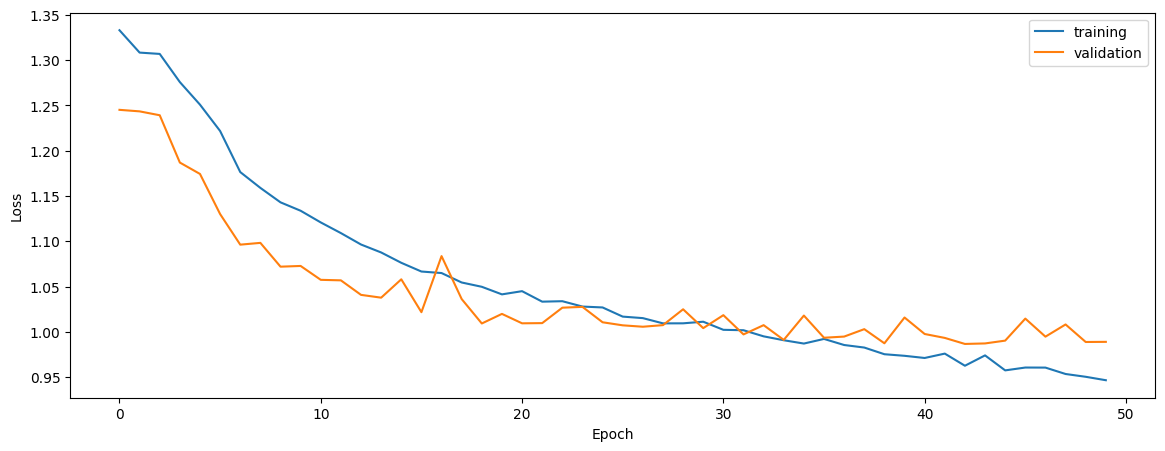

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6536740436535098
0.6564651462994836
0.6205771999476463


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6536740436535098
0.6564651462994836
0.6205771999476463


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6514947934161908
0.6519969193530641
0.6268713284062915


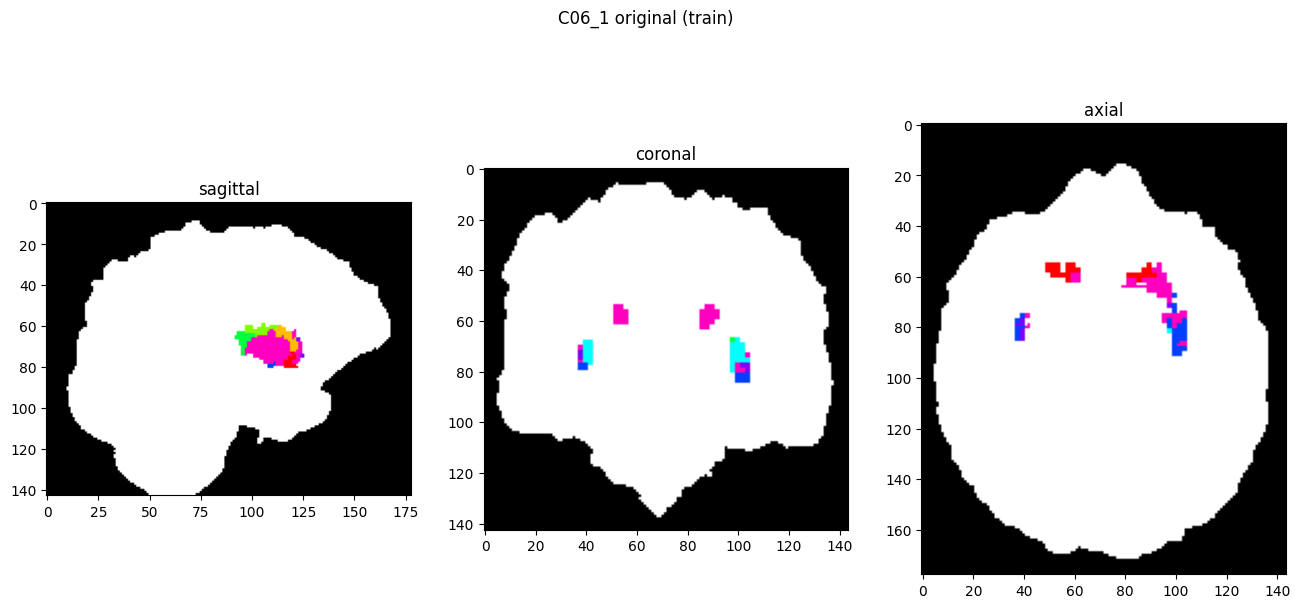

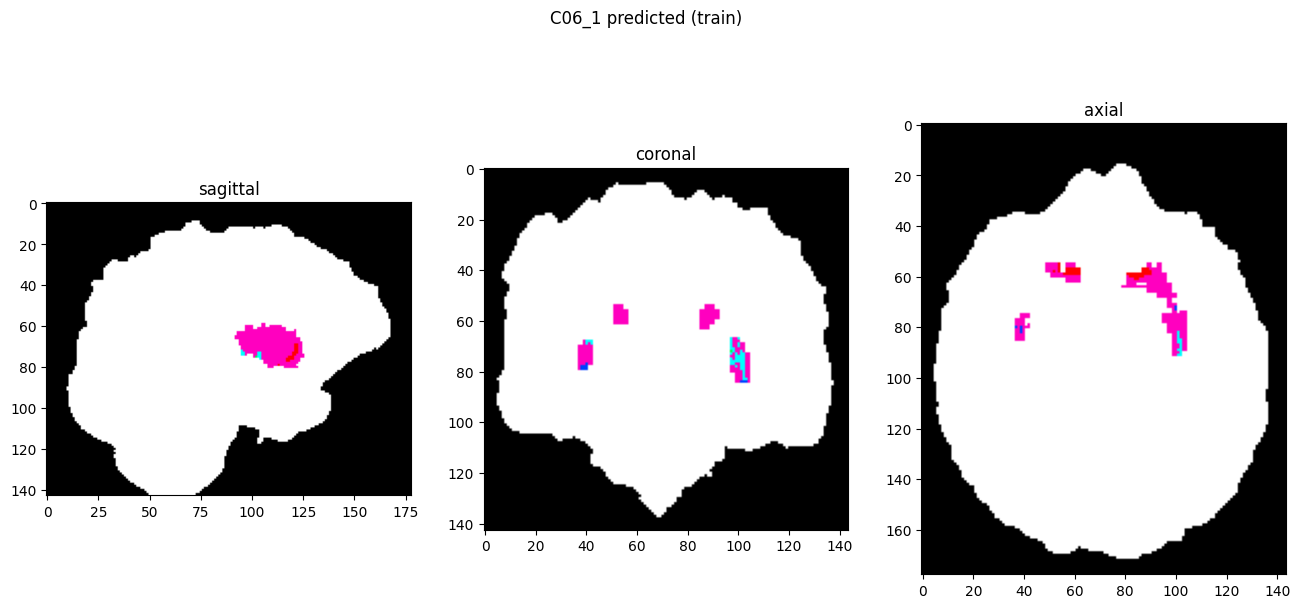

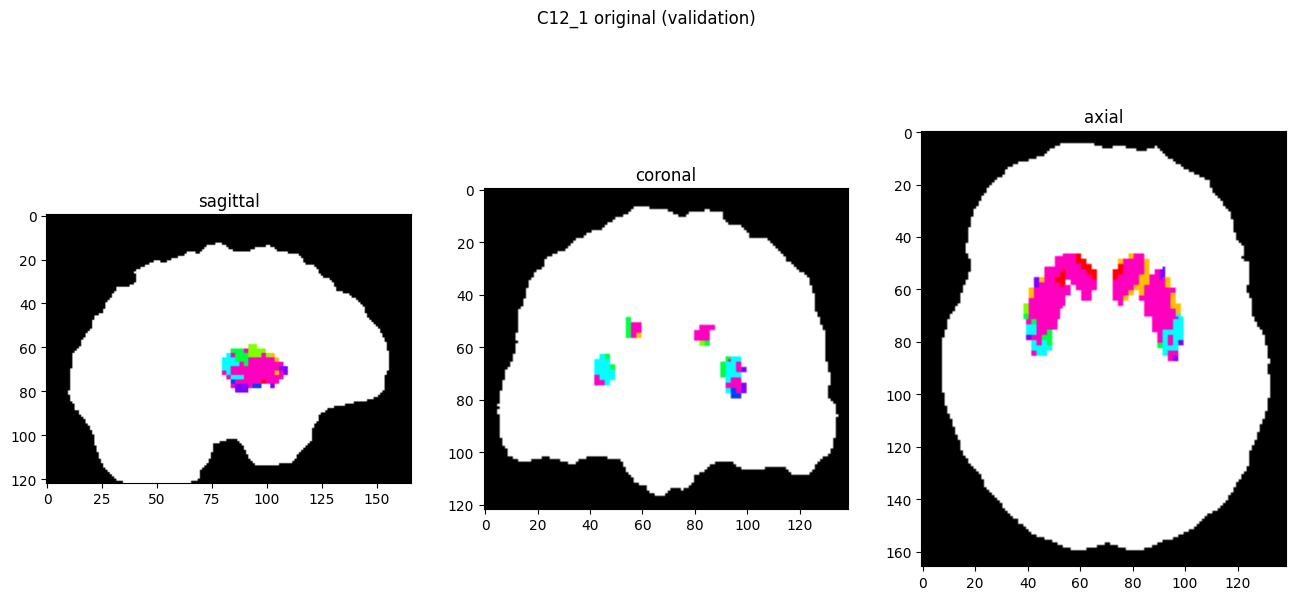

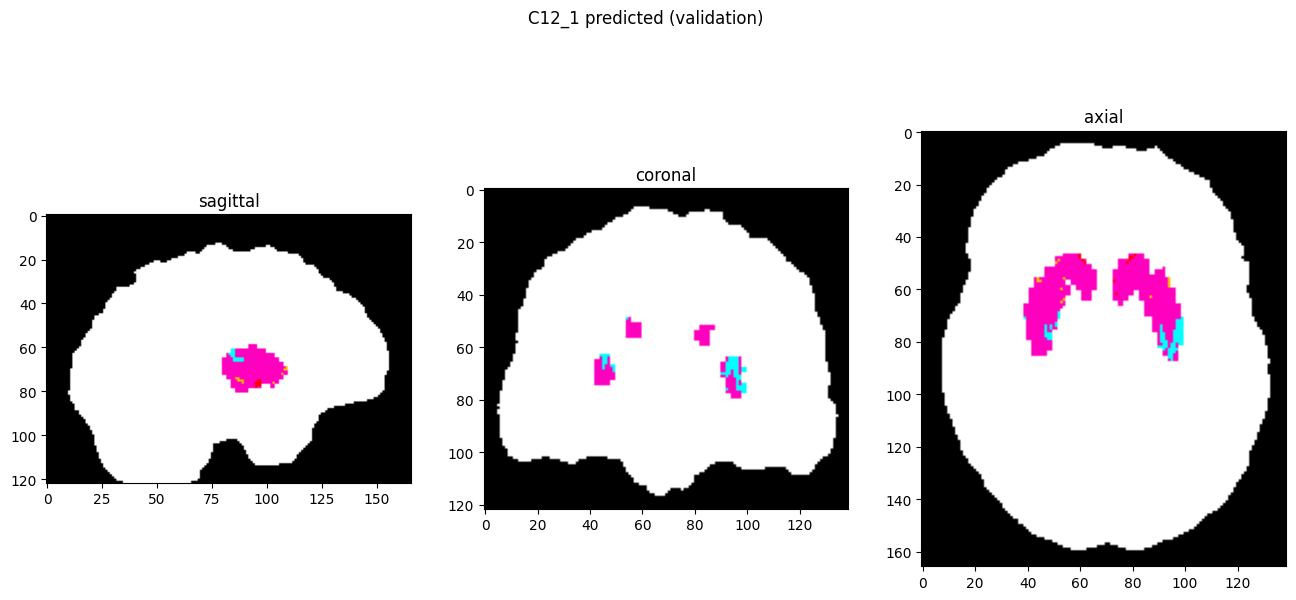

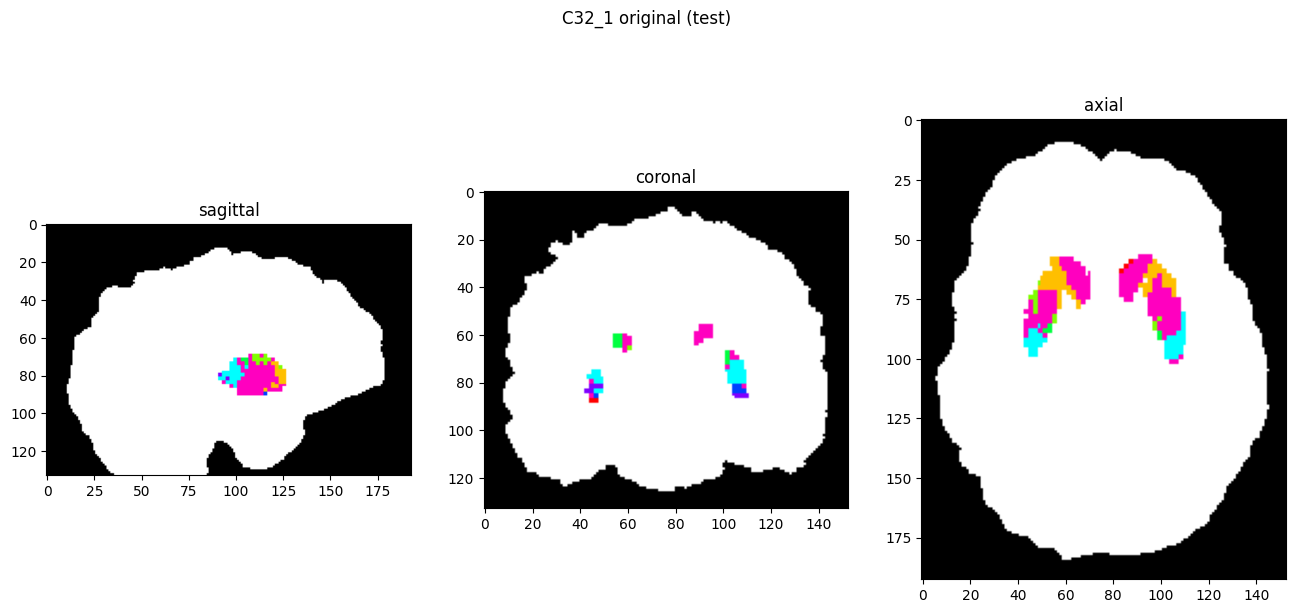

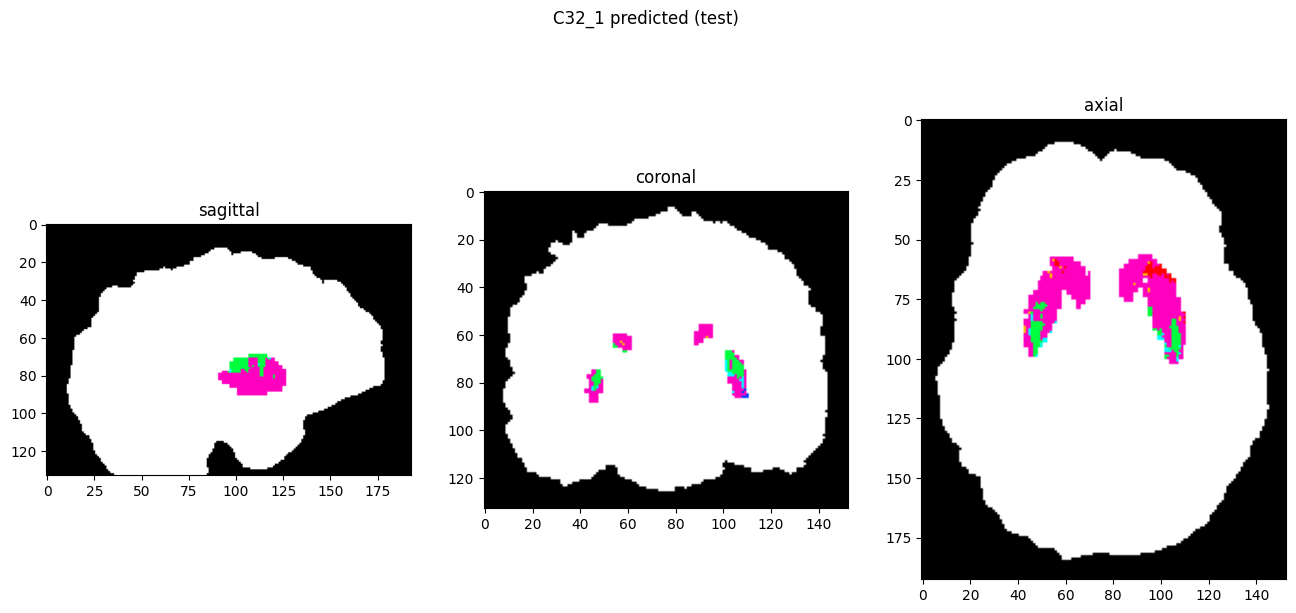

In [10]:
showResults(model, gen, threshold=0)